In [1]:
source("/Users/wyx/Desktop/dissertation/wholecode.R")

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Warning message:
“package ‘rms’ was built under R version 4.3.3”
Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:base’:

    format.pval, units


Warning message in .recacheSubclasses(def@className, def, env):
“undefined subclass "ndiMatrix" of class "replValueSp"; definition not updated”

Attaching package: ‘DescTools’


The following objects are masked from ‘package:Hmisc’:

    %nin%, Label, Mean, Quantile



Attaching package: ‘dplyr’


The following objects are masked from ‘package:Hmisc’:

    src, summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [5]:
library(xgboost)
library(pROC)
library(DescTools)
library(ModelMetrics)
library(rms)


# 设置随机种子以保证可重复性
set.seed(123)

# 数据生成模块
# 数据生成偏移的data_shifted_age模块
generate_shifted_data_cpd_2_ml <- function(seed, beta_cpd_start, beta_cpd_end) {
  set.seed(seed)
  data <- generate_shifted_data_cpd(
    time_periods = 2,
    n = 9602,
    target_mortality_rate = 0.2,
    age_mean = 64.6,
    age_sd = 12.5,
    sex_prob = 0.309,
    cpd_prob = 0.107,
    pcs_prob = 0.282,
    cps_prob = 0.241, 
    beta_age = 0.0285181,
    beta_sex = 0.2196434,
    beta_cpd_start = beta_cpd_start,
    beta_cpd_end = beta_cpd_end,
    beta_pcs = 1.118599,
    beta_cps = 1.086517
  )
  return(data)
}

generate_shifted_data_cpd_2_ml(1,0.2,0.3)

experiments_cpd <- list(
  list(name = "gradual_shifted_cpd_1", beta_cpd_start = 0.1886564, beta_cpd_end = 0.1886564),
  list(name = "gradual_shifted_cpd_2", beta_cpd_start = 0.1886564, beta_cpd_end = 0.2598779),
  list(name = "gradual_shifted_cpd_3", beta_cpd_start = 0.1886564, beta_cpd_end = 0.357987),
  list(name = "gradual_shifted_cpd_4", beta_cpd_start = 0.1886564, beta_cpd_end = 0.4931341),
  list(name = "gradual_shifted_cpd_5", beta_cpd_start = 0.1886564, beta_cpd_end = 0.679302),
  list(name = "gradual_shifted_cpd_6", beta_cpd_start = 0.1886564, beta_cpd_end = 0.9357519),
  list(name = "gradual_shifted_cpd_7", beta_cpd_start = 0.1886564, beta_cpd_end = 1.2890166),
  list(name = "gradual_shifted_cpd_8", beta_cpd_start = 0.1886564, beta_cpd_end = 1.7756459),
  list(name = "gradual_shifted_cpd_9", beta_cpd_start = 0.1886564, beta_cpd_end = 2.4459872),
  list(name = "gradual_shifted_cpd_10", beta_cpd_start = 0.1886564, beta_cpd_end = 3.369395)
)



# 循环200个随机种子，生成数据并计算性能指标
set.seed(123)  # 确保结果可重复
num_simulations <- 200

results_shifted_cpd_2_ml <- data.frame()

for (exp in experiments_cpd) {
    results <- data.frame(auc = numeric(num_simulations), o_e = numeric(num_simulations), c_slope = numeric(num_simulations), brier_score = numeric(num_simulations))
    for (i in 1:num_simulations) {
      # 设置随机种子
      set.seed(i)

      data_shifted_xgb <- generate_shifted_data_cpd_2_ml(i, exp$beta_cpd_start, exp$beta_cpd_end)

      # 确保 mortality 变量是因子类型
      data_shifted_xgb$mortality <- as.factor(data_shifted_xgb$mortality)
      data_val$mortality <- as.factor(data_val$mortality)

      # 转换数据格式
      dtrain <- xgb.DMatrix(data = as.matrix(data_shifted_xgb[, -6]), label = as.numeric(data_shifted_xgb$mortality) - 1)
      dval <- xgb.DMatrix(data = as.matrix(data_val[, -6]), label = as.numeric(data_val$mortality) - 1)

      # 设置参数
      params <- list(
        booster = "gbtree",
        objective = "binary:logistic",
        eta = 0.1,
        max_depth = 3,
        eval_metric = "auc"
      )

      # 训练模型
      xgb_model <- xgb.train(params, dtrain, nrounds = 50)


      # 预测
      predictions <- predict(xgb_model, dval)

      # 确保测试集的mortality变量是二进制数值类型
      test_mortality <- as.numeric(data_val$mortality) - 1

      # 计算 AUC
      auc <- roc(data_val$mortality, predictions)$auc
      print(paste("auc:", auc))

      # 绘制 ROC 曲线
      #plot.roc(roc_obj, main = paste("ROC Curve (AUC =", round(auc_value, 2), ")"), col = "blue")

      # 计算 O/E 比率
      observed <- sum(test_mortality)
      expected <- sum(predictions)
      oe_ratio <- observed / expected
      print(paste("O/E 比率:", oe_ratio))

      # 计算校准斜率 (C-slope)
      # 绘制校准曲线并提取斜率
      calibration <- val.prob(predictions, test_mortality, xlab="Predicted Probability", ylab="Observed Probability", pl = FALSE, smooth = FALSE)

      c_slope <- calibration["Slope"]

      print(paste("c_slope:", c_slope))

      # 计算 Brier 分数
      brier_score <- BrierScore(test_mortality, predictions)
      print(paste("Brier 分数:", brier_score))

      # 保存结果
      results[i, ] <- c(auc = auc, o_e = oe_ratio, c_slope = c_slope, brier_score = brier_score)

    }

    # 计算中位数、25%和75%的性能指标
    median_metrics_shifted_cpd_2_ml <- apply(results, 2, median)
    quantile_25_metrics_shifted_cpd_2_ml <- apply(results, 2, quantile, probs = 0.25)
    quantile_75_metrics_shifted_cpd_2_ml <- apply(results, 2, quantile, probs = 0.75)

    # 将实验名称和结果添加到总的结果数据框
    summary_metrics_shifted_cpd_2_ml <- data.frame(
        experiment = exp$name,
        auc_median = median_metrics_shifted_cpd_2_ml['auc'],
        auc_25 = quantile_25_metrics_shifted_cpd_2_ml['auc'],
        auc_75 = quantile_75_metrics_shifted_cpd_2_ml['auc'],
        o_e_median = median_metrics_shifted_cpd_2_ml['o_e'],
        o_e_25 = quantile_25_metrics_shifted_cpd_2_ml['o_e'],
        o_e_75 = quantile_75_metrics_shifted_cpd_2_ml['o_e'],
        c_slope_median = median_metrics_shifted_cpd_2_ml['c_slope'],
        c_slope_25 = quantile_25_metrics_shifted_cpd_2_ml['c_slope'],
        c_slope_75 = quantile_75_metrics_shifted_cpd_2_ml['c_slope'],
        brier_score_median = median_metrics_shifted_cpd_2_ml['brier_score'],
        brier_score_25 = quantile_25_metrics_shifted_cpd_2_ml['brier_score'],
        brier_score_75 = quantile_75_metrics_shifted_cpd_2_ml['brier_score']
    )
    
    results_shifted_cpd_2_ml <- rbind(results_shifted_cpd_2_ml, summary_metrics_shifted_cpd_2_ml)
    
}


# 打印最终结果
results_shifted_cpd_2_ml


age,sex,chronic_pulmonary_disease,previous_cardiac_surgery,critical_preoperative_state,mortality
<dbl>,<int>,<int>,<int>,<int>,<int>
49.28550,0,0,1,0,0
81.03034,0,0,0,0,0
48.97791,0,0,0,0,0
77.81127,0,0,1,0,1
77.91689,0,0,0,0,0
63.00561,0,0,0,0,0
63.60380,0,0,0,1,0
75.66590,0,1,0,0,0
78.35455,0,0,0,0,1


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721773029066186"
[1] "O/E 比率: 1.00492761969956"
[1] "c_slope: 1.08214770411894"
[1] "Brier 分数: 0.144193146413868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723537064337265"
[1] "O/E 比率: 0.955001966760982"
[1] "c_slope: 1.19941220580017"
[1] "Brier 分数: 0.143980096355089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723517811564865"
[1] "O/E 比率: 0.988600208928995"
[1] "c_slope: 1.08122462022372"
[1] "Brier 分数: 0.143396795196087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718153507855131"
[1] "O/E 比率: 1.00164799288804"
[1] "c_slope: 1.09493627589171"
[1] "Brier 分数: 0.144258225653696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720014150787713"
[1] "O/E 比率: 0.990912345614894"
[1] "c_slope: 1.10504295691046"
[1] "Brier 分数: 0.143862397757292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721534432208238"
[1] "O/E 比率: 0.980381851326794"
[1] "c_slope: 1.14469027901473"
[1] "Brier 分数: 0.144227573403214"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719648348112128"
[1] "O/E 比率: 1.01156058928414"
[1] "c_slope: 1.07812913234873"
[1] "Brier 分数: 0.144121861068161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721309587330576"
[1] "O/E 比率: 1.013353877848"
[1] "c_slope: 1.16546988223026"
[1] "Brier 分数: 0.144503858186405"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720519192263686"
[1] "O/E 比率: 1.00380396563145"
[1] "c_slope: 1.08266387156942"
[1] "Brier 分数: 0.143922795971256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723186045040486"
[1] "O/E 比率: 0.961384802333983"
[1] "c_slope: 1.09138901561778"
[1] "Brier 分数: 0.143441053126001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722764203045238"
[1] "O/E 比率: 0.975505984934262"
[1] "c_slope: 1.15194171663635"
[1] "Brier 分数: 0.143565674468126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723434268284633"
[1] "O/E 比率: 1.00002338347098"
[1] "c_slope: 1.08297112810434"
[1] "Brier 分数: 0.14376233763498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723621295216511"
[1] "O/E 比率: 0.963476042054943"
[1] "c_slope: 1.10251095762575"
[1] "Brier 分数: 0.143748661478479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725633897531245"
[1] "O/E 比率: 0.960293245989541"
[1] "c_slope: 1.12579976032525"
[1] "Brier 分数: 0.143565836560028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722663813589157"
[1] "O/E 比率: 0.992408386265836"
[1] "c_slope: 1.12549976028033"
[1] "Brier 分数: 0.143953623869618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724901260781553"
[1] "O/E 比率: 0.98253959437278"
[1] "c_slope: 1.11271174865818"
[1] "Brier 分数: 0.143456058719802"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718222611556064"
[1] "O/E 比率: 0.972111215569476"
[1] "c_slope: 1.08646702289099"
[1] "Brier 分数: 0.14480868564646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718867235631931"
[1] "O/E 比率: 0.990987687379142"
[1] "c_slope: 1.0885341247816"
[1] "Brier 分数: 0.144057998674571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724745519604823"
[1] "O/E 比率: 0.98525081316553"
[1] "c_slope: 1.10197665952435"
[1] "Brier 分数: 0.143919637951351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721977589772927"
[1] "O/E 比率: 1.00955321993512"
[1] "c_slope: 1.05632875400863"
[1] "Brier 分数: 0.143874405414578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723913180998064"
[1] "O/E 比率: 0.956587804879745"
[1] "c_slope: 1.10051123034114"
[1] "Brier 分数: 0.143999623480913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721604223508185"
[1] "O/E 比率: 1.02228212932954"
[1] "c_slope: 1.10644411438837"
[1] "Brier 分数: 0.143798301650612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722296635715543"
[1] "O/E 比率: 1.00741433498967"
[1] "c_slope: 1.0857379651699"
[1] "Brier 分数: 0.144227347424541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719624282146629"
[1] "O/E 比率: 0.992331424048872"
[1] "c_slope: 1.07162392463457"
[1] "Brier 分数: 0.14442149970526"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724156934848618"
[1] "O/E 比率: 0.959244298177372"
[1] "c_slope: 1.16468474061115"
[1] "Brier 分数: 0.143503153158902"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722217218029396"
[1] "O/E 比率: 0.974062476438774"
[1] "c_slope: 1.10558388222966"
[1] "Brier 分数: 0.143733954307426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72652777624978"
[1] "O/E 比率: 0.948332262681202"
[1] "c_slope: 1.18464430915877"
[1] "Brier 分数: 0.143146221351797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721514148037317"
[1] "O/E 比率: 1.00651409833317"
[1] "c_slope: 1.11592326297214"
[1] "Brier 分数: 0.144268976712476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718718714244851"
[1] "O/E 比率: 0.986485190547384"
[1] "c_slope: 1.04714626208707"
[1] "Brier 分数: 0.144818000000561"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457539385671"
[1] "O/E 比率: 1.00627567031853"
[1] "c_slope: 1.07485945615222"
[1] "Brier 分数: 0.144509686816446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380291762014"
[1] "O/E 比率: 0.979328921746256"
[1] "c_slope: 1.13750133996741"
[1] "Brier 分数: 0.143370121369158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722061476852667"
[1] "O/E 比率: 0.99093894726061"
[1] "c_slope: 1.09037980843788"
[1] "Brier 分数: 0.143984266768799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724335710592325"
[1] "O/E 比率: 1.00222333435687"
[1] "c_slope: 1.16592972837149"
[1] "Brier 分数: 0.143717971144744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724468761001584"
[1] "O/E 比率: 1.02367389625555"
[1] "c_slope: 1.0839218170054"
[1] "Brier 分数: 0.143664779967634"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721550246985566"
[1] "O/E 比率: 1.00998790239816"
[1] "c_slope: 1.10051574732354"
[1] "Brier 分数: 0.143406783751875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 0.978532846593878"
[1] "c_slope: 1.12384210269821"
[1] "Brier 分数: 0.144094934153727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719419033840873"
[1] "O/E 比率: 1.03674577821105"
[1] "c_slope: 1.14236914460482"
[1] "Brier 分数: 0.144900043242548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724380060728745"
[1] "O/E 比率: 0.972210700260228"
[1] "c_slope: 1.13756868092105"
[1] "Brier 分数: 0.143891547505863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723468304435839"
[1] "O/E 比率: 0.982927147535179"
[1] "c_slope: 1.18853754198297"
[1] "Brier 分数: 0.143988741966043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721669201615033"
[1] "O/E 比率: 1.00988965174407"
[1] "c_slope: 1.09406582947784"
[1] "Brier 分数: 0.143979356230844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71953076868069"
[1] "O/E 比率: 1.01729952225077"
[1] "c_slope: 1.08573921299724"
[1] "Brier 分数: 0.144730412945924"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720299160579123"
[1] "O/E 比率: 1.01138910560137"
[1] "c_slope: 1.03042402206373"
[1] "Brier 分数: 0.144023425676649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721501771255061"
[1] "O/E 比率: 1.00160504983675"
[1] "c_slope: 1.09948284011625"
[1] "Brier 分数: 0.143937404869003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565599696356"
[1] "O/E 比率: 1.00666514052442"
[1] "c_slope: 1.09080739396335"
[1] "Brier 分数: 0.143730306611837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72121091687203"
[1] "O/E 比率: 1.02483408757357"
[1] "c_slope: 1.09660168123487"
[1] "Brier 分数: 0.144272641465091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721580501342193"
[1] "O/E 比率: 0.988844873352793"
[1] "c_slope: 1.10156960696854"
[1] "Brier 分数: 0.14398102194156"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718611792598134"
[1] "O/E 比率: 0.986224493186296"
[1] "c_slope: 1.05093638019653"
[1] "Brier 分数: 0.144997199617433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721488019274776"
[1] "O/E 比率: 0.961168824217245"
[1] "c_slope: 1.12714126929008"
[1] "Brier 分数: 0.143606187345784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722761108849674"
[1] "O/E 比率: 0.983298375105411"
[1] "c_slope: 1.12782919988439"
[1] "Brier 分数: 0.143872276838606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718509684144517"
[1] "O/E 比率: 0.990792222827176"
[1] "c_slope: 1.11536243474758"
[1] "Brier 分数: 0.144995925808882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720939659060905"
[1] "O/E 比率: 1.02433550733258"
[1] "c_slope: 1.09485439512072"
[1] "Brier 分数: 0.144384199505344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328039737722"
[1] "O/E 比率: 0.989619673513951"
[1] "c_slope: 1.09277588602432"
[1] "Brier 分数: 0.144081498689691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71853203111248"
[1] "O/E 比率: 1.03443269117005"
[1] "c_slope: 1.16055633480838"
[1] "Brier 分数: 0.144871913265688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720825173825031"
[1] "O/E 比率: 0.954103875351946"
[1] "c_slope: 1.09999988495478"
[1] "Brier 分数: 0.143931517815111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721681922196796"
[1] "O/E 比率: 0.984049519281821"
[1] "c_slope: 1.16604992002793"
[1] "Brier 分数: 0.143815202762256"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723565255896849"
[1] "O/E 比率: 0.982226013820414"
[1] "c_slope: 1.11117886979068"
[1] "Brier 分数: 0.143690670288751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720846145594966"
[1] "O/E 比率: 1.00423153571727"
[1] "c_slope: 1.12897735149329"
[1] "Brier 分数: 0.143864348043825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721081648257349"
[1] "O/E 比率: 1.03208969092499"
[1] "c_slope: 1.1020153841334"
[1] "Brier 分数: 0.144250924527425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723308093865517"
[1] "O/E 比率: 0.995894180355195"
[1] "c_slope: 0.999320708645806"
[1] "Brier 分数: 0.14402354839294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723802133757261"
[1] "O/E 比率: 0.969203324128175"
[1] "c_slope: 1.21463813206208"
[1] "Brier 分数: 0.14406641565702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720696592809364"
[1] "O/E 比率: 1.01858315058124"
[1] "c_slope: 1.16945595561088"
[1] "Brier 分数: 0.143855300954661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722455814887344"
[1] "O/E 比率: 0.99809777816261"
[1] "c_slope: 1.107123707382"
[1] "Brier 分数: 0.143951358191568"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724391749911987"
[1] "O/E 比率: 0.985660817585286"
[1] "c_slope: 1.15766812095294"
[1] "Brier 分数: 0.144159462485089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722325858673649"
[1] "O/E 比率: 0.990553624593658"
[1] "c_slope: 1.16414429716115"
[1] "Brier 分数: 0.14352528028399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723727529264214"
[1] "O/E 比率: 1.01216745784637"
[1] "c_slope: 1.09597739714325"
[1] "Brier 分数: 0.144042603768689"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718064807582292"
[1] "O/E 比率: 1.01778598447807"
[1] "c_slope: 1.10005998399"
[1] "Brier 分数: 0.144730795729179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718859328243267"
[1] "O/E 比率: 0.978495712775133"
[1] "c_slope: 1.04907594590262"
[1] "Brier 分数: 0.144231928800968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718187887805844"
[1] "O/E 比率: 0.968970158474719"
[1] "c_slope: 1.11462393648917"
[1] "Brier 分数: 0.144468690117076"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721733492122866"
[1] "O/E 比率: 0.978190885634165"
[1] "c_slope: 1.11598708743079"
[1] "Brier 分数: 0.143803422240481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298016414364"
[1] "O/E 比率: 1.04905447736107"
[1] "c_slope: 1.10073182956141"
[1] "Brier 分数: 0.144633366073178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71920622194596"
[1] "O/E 比率: 0.958204588033341"
[1] "c_slope: 1.16975918002564"
[1] "Brier 分数: 0.144176151239989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595859553776"
[1] "O/E 比率: 0.958535939397503"
[1] "c_slope: 1.10110890024731"
[1] "Brier 分数: 0.143767920152287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724364933550431"
[1] "O/E 比率: 0.998272961469656"
[1] "c_slope: 1.18035282711998"
[1] "Brier 分数: 0.143583885800241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716860477908819"
[1] "O/E 比率: 0.989906764755968"
[1] "c_slope: 1.09178152553424"
[1] "Brier 分数: 0.145020936385575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720041310948777"
[1] "O/E 比率: 0.987549690803267"
[1] "c_slope: 1.18379981552287"
[1] "Brier 分数: 0.144790032858102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72124564062225"
[1] "O/E 比率: 0.979374201935071"
[1] "c_slope: 1.12261319804662"
[1] "Brier 分数: 0.144054646119511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722138487942264"
[1] "O/E 比率: 0.99663421574182"
[1] "c_slope: 1.05628028335611"
[1] "Brier 分数: 0.143530874083994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720377203067242"
[1] "O/E 比率: 0.990289023009322"
[1] "c_slope: 1.20877064132035"
[1] "Brier 分数: 0.144193678552244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724860348640204"
[1] "O/E 比率: 0.959389510318655"
[1] "c_slope: 1.13362959498926"
[1] "Brier 分数: 0.143687182458367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720546696224256"
[1] "O/E 比率: 0.995823392549264"
[1] "c_slope: 1.15361068703137"
[1] "Brier 分数: 0.144156826778291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721675390006161"
[1] "O/E 比率: 1.00942472262035"
[1] "c_slope: 1.17364791999059"
[1] "Brier 分数: 0.144034495628454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723937246963563"
[1] "O/E 比率: 0.990917049815677"
[1] "c_slope: 1.10653901023427"
[1] "Brier 分数: 0.143527451680596"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718982064667312"
[1] "O/E 比率: 0.974487911776267"
[1] "c_slope: 1.09671298921964"
[1] "Brier 分数: 0.144092839690553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723077404396233"
[1] "O/E 比率: 0.986229042921932"
[1] "c_slope: 1.12846452224686"
[1] "Brier 分数: 0.143599620533002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719323113778384"
[1] "O/E 比率: 1.03884842575409"
[1] "c_slope: 1.08845109236919"
[1] "Brier 分数: 0.144500668446982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721005668566274"
[1] "O/E 比率: 0.962725275196765"
[1] "c_slope: 1.10087292311565"
[1] "Brier 分数: 0.143727412486695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72582608145573"
[1] "O/E 比率: 0.989350972819394"
[1] "c_slope: 1.13714792043763"
[1] "Brier 分数: 0.143220411283444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722895534456962"
[1] "O/E 比率: 1.00778013580143"
[1] "c_slope: 1.0549529841819"
[1] "Brier 分数: 0.143938021119769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722144676333392"
[1] "O/E 比率: 0.994007300531325"
[1] "c_slope: 1.07946258825901"
[1] "Brier 分数: 0.143339317032178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722610524665552"
[1] "O/E 比率: 0.970912501184328"
[1] "c_slope: 1.08630005240076"
[1] "Brier 分数: 0.143713188384928"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718087154550255"
[1] "O/E 比率: 1.01638910708231"
[1] "c_slope: 1.14444733111388"
[1] "Brier 分数: 0.144102830935112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721074772267207"
[1] "O/E 比率: 0.982853095401988"
[1] "c_slope: 1.07461244123166"
[1] "Brier 分数: 0.143355460932685"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721036610521915"
[1] "O/E 比率: 0.932958966241939"
[1] "c_slope: 1.04361712279634"
[1] "Brier 分数: 0.144106050471184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724282077869213"
[1] "O/E 比率: 0.979514318572097"
[1] "c_slope: 1.16305674789727"
[1] "Brier 分数: 0.144025245352535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722773829431438"
[1] "O/E 比率: 1.01473745948778"
[1] "c_slope: 1.12910320745513"
[1] "Brier 分数: 0.144094237297559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72162760187467"
[1] "O/E 比率: 0.971257654492892"
[1] "c_slope: 1.09097382936058"
[1] "Brier 分数: 0.143902635524666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718958686300827"
[1] "O/E 比率: 0.978200778399548"
[1] "c_slope: 1.12873960955137"
[1] "Brier 分数: 0.144335693979414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721368720845802"
[1] "O/E 比率: 0.982324780439324"
[1] "c_slope: 1.10118518025411"
[1] "Brier 分数: 0.143656194692276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722333078463299"
[1] "O/E 比率: 0.987818077544008"
[1] "c_slope: 1.03542280259615"
[1] "Brier 分数: 0.143371053780181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722596085086252"
[1] "O/E 比率: 1.0045462446404"
[1] "c_slope: 1.14641057922167"
[1] "Brier 分数: 0.143757178284627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723643985983982"
[1] "O/E 比率: 0.96891649551108"
[1] "c_slope: 1.09405485395822"
[1] "Brier 分数: 0.143936647675887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724979647069178"
[1] "O/E 比率: 0.991372280696553"
[1] "c_slope: 1.10556114987954"
[1] "Brier 分数: 0.143348850791388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722399087968667"
[1] "O/E 比率: 1.00540832484557"
[1] "c_slope: 1.07943897431315"
[1] "Brier 分数: 0.143983505422646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724779211956522"
[1] "O/E 比率: 0.971688917681534"
[1] "c_slope: 1.12484319642271"
[1] "Brier 分数: 0.143471617644424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72467882250044"
[1] "O/E 比率: 0.994476753906321"
[1] "c_slope: 1.09326893881404"
[1] "Brier 分数: 0.143668781779312"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721971401381799"
[1] "O/E 比率: 0.99598707285921"
[1] "c_slope: 1.13579432994929"
[1] "Brier 分数: 0.144110918500129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381097628058"
[1] "O/E 比率: 1.01531594019636"
[1] "c_slope: 1.10918397061346"
[1] "Brier 分数: 0.143919090708821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722711945520155"
[1] "O/E 比率: 1.00235323325075"
[1] "c_slope: 1.13528319653561"
[1] "Brier 分数: 0.143984866270889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212173803028"
[1] "O/E 比率: 1.00550345883036"
[1] "c_slope: 1.07575614430566"
[1] "Brier 分数: 0.143957210857818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722469223068122"
[1] "O/E 比率: 1.02005891754708"
[1] "c_slope: 1.0700524262123"
[1] "Brier 分数: 0.143620374744086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720359669292378"
[1] "O/E 比率: 0.964234872216952"
[1] "c_slope: 1.0802167137517"
[1] "Brier 分数: 0.143924627448354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725144327033093"
[1] "O/E 比率: 0.982603249417746"
[1] "c_slope: 1.09669757076942"
[1] "Brier 分数: 0.143256145791944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717997422878895"
[1] "O/E 比率: 0.978148586504307"
[1] "c_slope: 1.12259127505801"
[1] "Brier 分数: 0.144592367658967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725603986974124"
[1] "O/E 比率: 0.9849631765005"
[1] "c_slope: 1.10897637834797"
[1] "Brier 分数: 0.14292710363982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723206673010914"
[1] "O/E 比率: 0.954972408959757"
[1] "c_slope: 1.1444175782772"
[1] "Brier 分数: 0.144259697956428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71484134340345"
[1] "O/E 比率: 1.03736290445294"
[1] "c_slope: 1.05255583780441"
[1] "Brier 分数: 0.144879901027266"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720291596989967"
[1] "O/E 比率: 0.998961717300628"
[1] "c_slope: 1.21663520116738"
[1] "Brier 分数: 0.144445319781116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723245178555712"
[1] "O/E 比率: 0.980400185007192"
[1] "c_slope: 1.0457506503564"
[1] "Brier 分数: 0.143745812122019"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718350161173209"
[1] "O/E 比率: 0.972621220196228"
[1] "c_slope: 1.10192021917053"
[1] "Brier 分数: 0.144257857987129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722814053973772"
[1] "O/E 比率: 0.991854862759129"
[1] "c_slope: 1.08449159280899"
[1] "Brier 分数: 0.143904659511432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72336757118025"
[1] "O/E 比率: 0.949763417604259"
[1] "c_slope: 1.0515452562262"
[1] "Brier 分数: 0.143784974914463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727656126232177"
[1] "O/E 比率: 0.973289711534573"
[1] "c_slope: 1.10039592435388"
[1] "Brier 分数: 0.142911434470922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720734754554656"
[1] "O/E 比率: 1.00764157212113"
[1] "c_slope: 1.09325900554912"
[1] "Brier 分数: 0.144628792522251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725048406970604"
[1] "O/E 比率: 1.01627552825784"
[1] "c_slope: 1.04322139589086"
[1] "Brier 分数: 0.142685670865327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722995236314029"
[1] "O/E 比率: 1.00643555744629"
[1] "c_slope: 1.18244905083601"
[1] "Brier 分数: 0.143556040070978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.729541178929766"
[1] "O/E 比率: 0.992561501966409"
[1] "c_slope: 1.08881634099527"
[1] "Brier 分数: 0.142542094640726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722890377464355"
[1] "O/E 比率: 1.01547943430027"
[1] "c_slope: 1.10542536202159"
[1] "Brier 分数: 0.143774405081597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721087149049463"
[1] "O/E 比率: 1.0100751049759"
[1] "c_slope: 1.10170005432264"
[1] "Brier 分数: 0.144577748171385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721575344349586"
[1] "O/E 比率: 0.969101598181039"
[1] "c_slope: 1.15972070491577"
[1] "Brier 分数: 0.14400134783729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722237502200317"
[1] "O/E 比率: 1.00289028647603"
[1] "c_slope: 1.07621274639486"
[1] "Brier 分数: 0.143559034209054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720016557384263"
[1] "O/E 比率: 0.984855536193567"
[1] "c_slope: 1.1305696132123"
[1] "Brier 分数: 0.144168446235981"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723380979361028"
[1] "O/E 比率: 1.02318779484819"
[1] "c_slope: 1.02363762559788"
[1] "Brier 分数: 0.143964556844885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72115453375286"
[1] "O/E 比率: 1.00154318680492"
[1] "c_slope: 1.06878933102484"
[1] "Brier 分数: 0.14407275237302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722912036833304"
[1] "O/E 比率: 0.991337140189741"
[1] "c_slope: 1.13325479352469"
[1] "Brier 分数: 0.144000491239306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724168967831368"
[1] "O/E 比率: 0.977587732724393"
[1] "c_slope: 1.07025025737526"
[1] "Brier 分数: 0.143388659380034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720328383537229"
[1] "O/E 比率: 0.971915066012508"
[1] "c_slope: 1.09011841553975"
[1] "Brier 分数: 0.144124611422515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723910774401514"
[1] "O/E 比率: 0.944190051447242"
[1] "c_slope: 1.06799731023777"
[1] "Brier 分数: 0.143981589138327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721993748349762"
[1] "O/E 比率: 1.01044075896397"
[1] "c_slope: 1.11485912712844"
[1] "Brier 分数: 0.143751232449143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720558729207006"
[1] "O/E 比率: 0.94816288545251"
[1] "c_slope: 1.08854126649024"
[1] "Brier 分数: 0.144122906191288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721725584734202"
[1] "O/E 比率: 1.02540704367809"
[1] "c_slope: 1.18678456183623"
[1] "Brier 分数: 0.144452905842308"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721817379202605"
[1] "O/E 比率: 0.989057360113105"
[1] "c_slope: 1.14871530916814"
[1] "Brier 分数: 0.144059781179901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720616143724696"
[1] "O/E 比率: 1.00714019084503"
[1] "c_slope: 1.08970369017101"
[1] "Brier 分数: 0.144355438952175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722562048935047"
[1] "O/E 比率: 1.04037378688287"
[1] "c_slope: 1.12411296859687"
[1] "Brier 分数: 0.143781815536379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722598147883295"
[1] "O/E 比率: 0.979243851772451"
[1] "c_slope: 1.07075699944265"
[1] "Brier 分数: 0.144079394723077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719506702715191"
[1] "O/E 比率: 1.01786073915512"
[1] "c_slope: 1.10084011591777"
[1] "Brier 分数: 0.144417392114734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723361726588629"
[1] "O/E 比率: 0.996527458589742"
[1] "c_slope: 1.10963260323917"
[1] "Brier 分数: 0.144061049063116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725505316515578"
[1] "O/E 比率: 0.941497928946967"
[1] "c_slope: 1.10853853685473"
[1] "Brier 分数: 0.143963219772121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874106121281"
[1] "O/E 比率: 0.976340445525105"
[1] "c_slope: 1.10452885683486"
[1] "Brier 分数: 0.143641071026351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719644910117057"
[1] "O/E 比率: 0.956098432004158"
[1] "c_slope: 1.05299666099676"
[1] "Brier 分数: 0.144105682857348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723686273323359"
[1] "O/E 比率: 1.00621105782593"
[1] "c_slope: 1.12556048505355"
[1] "Brier 分数: 0.143774465112225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720672870643373"
[1] "O/E 比率: 0.971449235208305"
[1] "c_slope: 1.1461186243591"
[1] "Brier 分数: 0.144334250300196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721537182604295"
[1] "O/E 比率: 0.978200369356852"
[1] "c_slope: 1.04851331923822"
[1] "Brier 分数: 0.143997795488005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724661976324591"
[1] "O/E 比率: 0.98443797183442"
[1] "c_slope: 1.16314134137389"
[1] "Brier 分数: 0.143401327257327"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722010594525612"
[1] "O/E 比率: 0.978569162040726"
[1] "c_slope: 1.12608380918978"
[1] "Brier 分数: 0.14426881166179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719436911415244"
[1] "O/E 比率: 0.98433587014656"
[1] "c_slope: 1.11154128114508"
[1] "Brier 分数: 0.144332701758602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720733379356627"
[1] "O/E 比率: 1.00179850790632"
[1] "c_slope: 1.09737140218739"
[1] "Brier 分数: 0.144317090092462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718802601324591"
[1] "O/E 比率: 0.999570324941368"
[1] "c_slope: 1.04288155621"
[1] "Brier 分数: 0.144237691674618"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71977383493223"
[1] "O/E 比率: 0.985898107355456"
[1] "c_slope: 1.06995791916777"
[1] "Brier 分数: 0.144396713022508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725106165287801"
[1] "O/E 比率: 1.00293000629746"
[1] "c_slope: 1.15294995452"
[1] "Brier 分数: 0.143348391851212"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722717446312269"
[1] "O/E 比率: 0.950047061663972"
[1] "c_slope: 1.07431308152847"
[1] "Brier 分数: 0.143699895415695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722910317835768"
[1] "O/E 比率: 0.979330762271672"
[1] "c_slope: 1.16416905675234"
[1] "Brier 分数: 0.143934595561912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720930376474212"
[1] "O/E 比率: 1.042780865231"
[1] "c_slope: 1.05291210174"
[1] "Brier 分数: 0.144354305039894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722196933858476"
[1] "O/E 比率: 1.00537090481105"
[1] "c_slope: 1.07077706219606"
[1] "Brier 分数: 0.143570023386428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010825558881"
[1] "O/E 比率: 0.99870956180206"
[1] "c_slope: 1.04615584697433"
[1] "Brier 分数: 0.144380046232771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720537757437071"
[1] "O/E 比率: 1.03538325608416"
[1] "c_slope: 1.0560155767652"
[1] "Brier 分数: 0.144095831209163"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723041649247492"
[1] "O/E 比率: 0.991369706367484"
[1] "c_slope: 1.10510747551465"
[1] "Brier 分数: 0.14360156831229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721006012365781"
[1] "O/E 比率: 0.971535019180367"
[1] "c_slope: 1.12615730632483"
[1] "Brier 分数: 0.144241787053388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717774296998768"
[1] "O/E 比率: 0.977667806407679"
[1] "c_slope: 1.06159895272242"
[1] "Brier 分数: 0.14444689365713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720443900171625"
[1] "O/E 比率: 1.01860887537113"
[1] "c_slope: 1.11340090698949"
[1] "Brier 分数: 0.144430965521599"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717869529462243"
[1] "O/E 比率: 0.963837094918434"
[1] "c_slope: 1.04570880741827"
[1] "Brier 分数: 0.144672737273597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720381672460834"
[1] "O/E 比率: 0.978377506628061"
[1] "c_slope: 1.09390026583093"
[1] "Brier 分数: 0.143681664991348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72475789638708"
[1] "O/E 比率: 1.00201599180568"
[1] "c_slope: 1.092405623595"
[1] "Brier 分数: 0.1435962876894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719896571356275"
[1] "O/E 比率: 1.02117212610147"
[1] "c_slope: 1.12455322327685"
[1] "Brier 分数: 0.143806773332373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72250532201637"
[1] "O/E 比率: 0.974845580623561"
[1] "c_slope: 1.09840232643209"
[1] "Brier 分数: 0.143894238863389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718770284170921"
[1] "O/E 比率: 0.98740434308774"
[1] "c_slope: 1.06940511303426"
[1] "Brier 分数: 0.144229470871464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725141920436543"
[1] "O/E 比率: 1.01047657376472"
[1] "c_slope: 1.13458275475007"
[1] "Brier 分数: 0.143445567286844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723025834470164"
[1] "O/E 比率: 0.959972583035435"
[1] "c_slope: 1.01226652311779"
[1] "Brier 分数: 0.14404455383963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718041773015314"
[1] "O/E 比率: 0.990904255181074"
[1] "c_slope: 1.04338759724815"
[1] "Brier 分数: 0.144478504122447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719634252332336"
[1] "O/E 比率: 0.959966045763711"
[1] "c_slope: 1.04816494582394"
[1] "Brier 分数: 0.143988500516579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721985840961098"
[1] "O/E 比率: 1.0089233323162"
[1] "c_slope: 1.1365570569235"
[1] "Brier 分数: 0.143442060252095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721864135935575"
[1] "O/E 比率: 1.00036464392706"
[1] "c_slope: 1.10726721852382"
[1] "Brier 分数: 0.143805446813243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058269890864"
[1] "O/E 比率: 0.976084379242245"
[1] "c_slope: 1.06084036697351"
[1] "Brier 分数: 0.144948157877002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720818297834888"
[1] "O/E 比率: 0.973951827647851"
[1] "c_slope: 1.02338560836167"
[1] "Brier 分数: 0.144268076275049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718321969613624"
[1] "O/E 比率: 1.01340497357716"
[1] "c_slope: 1.10851266108382"
[1] "Brier 分数: 0.144757223741286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722772110433902"
[1] "O/E 比率: 0.996947936388393"
[1] "c_slope: 1.16194430228583"
[1] "Brier 分数: 0.143763829452823"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721198540089773"
[1] "O/E 比率: 0.993113556802863"
[1] "c_slope: 1.11798925159433"
[1] "Brier 分数: 0.143969457618607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719247134087309"
[1] "O/E 比率: 1.01590788780827"
[1] "c_slope: 1.13345363124571"
[1] "Brier 分数: 0.144125927958647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717425684298539"
[1] "O/E 比率: 0.976156959995133"
[1] "c_slope: 1.09768390344549"
[1] "Brier 分数: 0.144355419376209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721913643064601"
[1] "O/E 比率: 1.00724197384611"
[1] "c_slope: 1.08801458769391"
[1] "Brier 分数: 0.14436352392505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726492021101039"
[1] "O/E 比率: 0.975142109396675"
[1] "c_slope: 1.1280486195173"
[1] "Brier 分数: 0.143318735273368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 0.953513945704109"
[1] "c_slope: 1.09845846891248"
[1] "Brier 分数: 0.143835402456649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719821623063721"
[1] "O/E 比率: 0.990133330095391"
[1] "c_slope: 1.10456443550338"
[1] "Brier 分数: 0.144880542488507"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722483318847914"
[1] "O/E 比率: 0.998962619536995"
[1] "c_slope: 1.0449769583481"
[1] "Brier 分数: 0.143545656070483"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720305348970252"
[1] "O/E 比率: 1.03322075940075"
[1] "c_slope: 1.05840862145653"
[1] "Brier 分数: 0.145036840600082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722324827275128"
[1] "O/E 比率: 0.947355890639735"
[1] "c_slope: 1.10896808465092"
[1] "Brier 分数: 0.143695394208359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720704156398521"
[1] "O/E 比率: 0.970991880559601"
[1] "c_slope: 1.13362381615528"
[1] "Brier 分数: 0.143929638133367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721495239064425"
[1] "O/E 比率: 0.968857772808893"
[1] "c_slope: 1.13625953280612"
[1] "Brier 分数: 0.144167235801179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720676652437951"
[1] "O/E 比率: 0.991265357787895"
[1] "c_slope: 1.1163465963253"
[1] "Brier 分数: 0.144505337170297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720595515754269"
[1] "O/E 比率: 0.994898399860778"
[1] "c_slope: 1.1097448474767"
[1] "Brier 分数: 0.144181782605494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726459016348354"
[1] "O/E 比率: 1.00847927603788"
[1] "c_slope: 1.18765965136696"
[1] "Brier 分数: 0.143678547917066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7223138256909"
[1] "O/E 比率: 0.990094657876334"
[1] "c_slope: 1.09716672078166"
[1] "Brier 分数: 0.144125899847731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72482734388752"
[1] "O/E 比率: 0.953427595229554"
[1] "c_slope: 1.18905848703949"
[1] "Brier 分数: 0.143887595283465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722208623041718"
[1] "O/E 比率: 0.985220266708127"
[1] "c_slope: 1.08091953398266"
[1] "Brier 分数: 0.143543919504331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716478516656399"
[1] "O/E 比率: 1.00421348938392"
[1] "c_slope: 1.05782848655544"
[1] "Brier 分数: 0.144132034900781"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721263861996127"
[1] "O/E 比率: 0.989486206828806"
[1] "c_slope: 1.0670420312437"
[1] "Brier 分数: 0.144285138861099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721797438831192"
[1] "O/E 比率: 0.978264435821947"
[1] "c_slope: 1.14677988616407"
[1] "Brier 分数: 0.144036006716513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723961312929062"
[1] "O/E 比率: 1.03097047120885"
[1] "c_slope: 1.15264351253601"
[1] "Brier 分数: 0.143682669706603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719868723596198"
[1] "O/E 比率: 1.00734795309403"
[1] "c_slope: 1.13541504589972"
[1] "Brier 分数: 0.144265652893809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722484350246435"
[1] "O/E 比率: 1.01212045869505"
[1] "c_slope: 1.07758516560348"
[1] "Brier 分数: 0.143653015050972"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723388886749692"
[1] "O/E 比率: 0.956655460681494"
[1] "c_slope: 1.07476890984509"
[1] "Brier 分数: 0.143717692052637"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72184075756909"
[1] "O/E 比率: 0.974656427341051"
[1] "c_slope: 1.11423458704221"
[1] "Brier 分数: 0.143873486629895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723166104669072"
[1] "O/E 比率: 0.99063448340947"
[1] "c_slope: 1.07346682529866"
[1] "Brier 分数: 0.143856071608039"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726542215829079"
[1] "O/E 比率: 0.96710983690309"
[1] "c_slope: 1.13706079135862"
[1] "Brier 分数: 0.143183939666674"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719616030958458"
[1] "O/E 比率: 1.01875710797243"
[1] "c_slope: 1.11280996782496"
[1] "Brier 分数: 0.144477677860819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720415364812533"
[1] "O/E 比率: 0.992265406783007"
[1] "c_slope: 1.10378168810771"
[1] "Brier 分数: 0.144129765837123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724642723552192"
[1] "O/E 比率: 1.00283528517597"
[1] "c_slope: 1.14306019497787"
[1] "Brier 分数: 0.144120570519621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724545428291674"
[1] "O/E 比率: 0.979540823696344"
[1] "c_slope: 1.12299561538939"
[1] "Brier 分数: 0.143309706641367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724074766766414"
[1] "O/E 比率: 0.997213446033756"
[1] "c_slope: 1.12849404727424"
[1] "Brier 分数: 0.14385749694069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723812447742475"
[1] "O/E 比率: 0.996823758740949"
[1] "c_slope: 1.17075756973615"
[1] "Brier 分数: 0.144101835247442"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720590014962155"
[1] "O/E 比率: 1.00679616698657"
[1] "c_slope: 1.04666326667303"
[1] "Brier 分数: 0.144049238624793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722824711758493"
[1] "O/E 比率: 0.962021953196462"
[1] "c_slope: 1.09774454274563"
[1] "Brier 分数: 0.144039330607276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722328265270199"
[1] "O/E 比率: 1.02182426713956"
[1] "c_slope: 1.10695772893752"
[1] "Brier 分数: 0.143831862378577"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722112015380215"
[1] "O/E 比率: 0.988814743075738"
[1] "c_slope: 1.11679632047662"
[1] "Brier 分数: 0.143748827820287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721686735389896"
[1] "O/E 比率: 1.02424381479099"
[1] "c_slope: 1.06232174540665"
[1] "Brier 分数: 0.143793059566591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724912949964795"
[1] "O/E 比率: 0.962202152298058"
[1] "c_slope: 1.18685669411545"
[1] "Brier 分数: 0.143430032054548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722045318275832"
[1] "O/E 比率: 0.970367087653547"
[1] "c_slope: 1.10251415587431"
[1] "Brier 分数: 0.143807583263365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725012651821862"
[1] "O/E 比率: 0.950868544071822"
[1] "c_slope: 1.18212806960473"
[1] "Brier 分数: 0.143362233406878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720933470669776"
[1] "O/E 比率: 1.02041208584462"
[1] "c_slope: 1.13674982172389"
[1] "Brier 分数: 0.144691625757033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718850389456082"
[1] "O/E 比率: 0.986503630782839"
[1] "c_slope: 1.0491894212015"
[1] "Brier 分数: 0.144733688891595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720205647113184"
[1] "O/E 比率: 1.00884248751402"
[1] "c_slope: 1.07102309465985"
[1] "Brier 分数: 0.144413667748619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721197508691252"
[1] "O/E 比率: 0.969926954792051"
[1] "c_slope: 1.08452708775224"
[1] "Brier 分数: 0.14376384353843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7212480472188"
[1] "O/E 比率: 0.991672952914556"
[1] "c_slope: 1.0831393898726"
[1] "Brier 分数: 0.144138919552964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719727765798275"
[1] "O/E 比率: 1.03510779610217"
[1] "c_slope: 1.16793738465446"
[1] "Brier 分数: 0.144686727845003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719361275523675"
[1] "O/E 比率: 0.99431362956701"
[1] "c_slope: 1.05326384153634"
[1] "Brier 分数: 0.144431904397837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721809128014434"
[1] "O/E 比率: 1.0086757217019"
[1] "c_slope: 1.10028158254782"
[1] "Brier 分数: 0.14339685991572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720444243971132"
[1] "O/E 比率: 0.977031390817266"
[1] "c_slope: 1.11431774478381"
[1] "Brier 分数: 0.144036736664142"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720361388289914"
[1] "O/E 比率: 1.03736143555505"
[1] "c_slope: 1.141042160614"
[1] "Brier 分数: 0.144867986382699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722320357881535"
[1] "O/E 比率: 0.998319814530307"
[1] "c_slope: 1.09097855892548"
[1] "Brier 分数: 0.14422814350978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723165417070058"
[1] "O/E 比率: 0.977600431508365"
[1] "c_slope: 1.18013796016014"
[1] "Brier 分数: 0.144127470230497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719888663967611"
[1] "O/E 比率: 0.980611338285404"
[1] "c_slope: 1.05930096967418"
[1] "Brier 分数: 0.144387936922466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717266161327231"
[1] "O/E 比率: 1.03174393514816"
[1] "c_slope: 1.07905008360806"
[1] "Brier 分数: 0.144804332251525"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719760082951945"
[1] "O/E 比率: 1.0434953811325"
[1] "c_slope: 1.0818507937803"
[1] "Brier 分数: 0.144258080348188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719632189535293"
[1] "O/E 比率: 0.992909080418745"
[1] "c_slope: 1.11076771406557"
[1] "Brier 分数: 0.144488014758251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72364776777856"
[1] "O/E 比率: 1.00732752013482"
[1] "c_slope: 1.08621545786366"
[1] "Brier 分数: 0.143831948869477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715725251936279"
[1] "O/E 比率: 0.999200409536773"
[1] "c_slope: 1.11512652733718"
[1] "Brier 分数: 0.14450350122597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722249878982573"
[1] "O/E 比率: 0.990832858736608"
[1] "c_slope: 1.09744098710226"
[1] "Brier 分数: 0.143953614661488"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717759169820454"
[1] "O/E 比率: 0.990478737178043"
[1] "c_slope: 1.050616533098"
[1] "Brier 分数: 0.145130017680844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715937376232177"
[1] "O/E 比率: 0.974217916976155"
[1] "c_slope: 1.03439227282988"
[1] "Brier 分数: 0.144620957810573"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726506460680338"
[1] "O/E 比率: 0.968715420049854"
[1] "c_slope: 1.08629135080773"
[1] "Brier 分数: 0.143203980930942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721237389434078"
[1] "O/E 比率: 0.963547186243984"
[1] "c_slope: 1.11659083659015"
[1] "Brier 分数: 0.143841847611205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721321620313325"
[1] "O/E 比率: 1.01876494139598"
[1] "c_slope: 1.09396926826887"
[1] "Brier 分数: 0.14358041625374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723726497865693"
[1] "O/E 比率: 1.00801034743311"
[1] "c_slope: 1.16585082432499"
[1] "Brier 分数: 0.143799075414342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723079123393769"
[1] "O/E 比率: 1.01393629536544"
[1] "c_slope: 1.10618403950623"
[1] "Brier 分数: 0.145068877877272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72184797735874"
[1] "O/E 比率: 0.953897987250941"
[1] "c_slope: 1.08561647308544"
[1] "Brier 分数: 0.143951824539087"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722248159985038"
[1] "O/E 比率: 0.980031088832763"
[1] "c_slope: 1.08650473959351"
[1] "Brier 分数: 0.143990321192935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722219968425453"
[1] "O/E 比率: 0.956324448738424"
[1] "c_slope: 1.09832165399411"
[1] "Brier 分数: 0.143736935428571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725967726852667"
[1] "O/E 比率: 0.99222382367571"
[1] "c_slope: 1.17131223086048"
[1] "Brier 分数: 0.143051038016573"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721652355439183"
[1] "O/E 比率: 1.03397306246937"
[1] "c_slope: 1.1005833442362"
[1] "Brier 分数: 0.144220366329154"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72229216632195"
[1] "O/E 比率: 0.990741801639415"
[1] "c_slope: 1.06543520082139"
[1] "Brier 分数: 0.143867213282071"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724353244367189"
[1] "O/E 比率: 0.970429934053633"
[1] "c_slope: 1.20246509811708"
[1] "Brier 分数: 0.143980272848611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721106401821862"
[1] "O/E 比率: 1.02542534112586"
[1] "c_slope: 1.15261634672991"
[1] "Brier 分数: 0.144088828671533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724327803203661"
[1] "O/E 比率: 1.0039502864782"
[1] "c_slope: 1.12427384421245"
[1] "Brier 分数: 0.143774605213818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71928288923605"
[1] "O/E 比率: 0.960773089910863"
[1] "c_slope: 1.12953908268526"
[1] "Brier 分数: 0.144292011343675"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722115453375286"
[1] "O/E 比率: 0.989056323127419"
[1] "c_slope: 1.14503944952036"
[1] "Brier 分数: 0.143559011862031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724472542796163"
[1] "O/E 比率: 1.01163853215148"
[1] "c_slope: 1.08907343586203"
[1] "Brier 分数: 0.143930478743336"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718248396519099"
[1] "O/E 比率: 1.02233611904335"
[1] "c_slope: 1.10632539890483"
[1] "Brier 分数: 0.144759650720058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719381215895089"
[1] "O/E 比率: 0.976242655447917"
[1] "c_slope: 1.0560044782264"
[1] "Brier 分数: 0.144294734862592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719642159721"
[1] "O/E 比率: 0.975866296934767"
[1] "c_slope: 1.09120559676361"
[1] "Brier 分数: 0.143884066146863"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718672645110896"
[1] "O/E 比率: 0.983625099862038"
[1] "c_slope: 1.09930924883777"
[1] "Brier 分数: 0.14416399233794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058613690371"
[1] "O/E 比率: 1.05067246375035"
[1] "c_slope: 1.11337407322094"
[1] "Brier 分数: 0.14467273205233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723750563831192"
[1] "O/E 比率: 1.00238784307646"
[1] "c_slope: 1.19707574213024"
[1] "Brier 分数: 0.143616620441871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719120959668192"
[1] "O/E 比率: 0.957224454094142"
[1] "c_slope: 1.10937779519166"
[1] "Brier 分数: 0.143824965337532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724816342303292"
[1] "O/E 比率: 0.998128117691608"
[1] "c_slope: 1.18619708696025"
[1] "Brier 分数: 0.143551343766227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721522743024996"
[1] "O/E 比率: 1.0212613129248"
[1] "c_slope: 1.10969781959604"
[1] "Brier 分数: 0.144202309178917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722358863426333"
[1] "O/E 比率: 1.02213841258824"
[1] "c_slope: 1.10548565856376"
[1] "Brier 分数: 0.144208863561867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721803283422813"
[1] "O/E 比率: 0.969998873686453"
[1] "c_slope: 1.08629032649451"
[1] "Brier 分数: 0.144219760622092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72157843854515"
[1] "O/E 比率: 0.998996702787476"
[1] "c_slope: 1.05804222162002"
[1] "Brier 分数: 0.143505201719512"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721175161723288"
[1] "O/E 比率: 0.99126125353355"
[1] "c_slope: 1.22221016730096"
[1] "Brier 分数: 0.144211874674471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721814628806548"
[1] "O/E 比率: 0.95305463832143"
[1] "c_slope: 1.14549445924382"
[1] "Brier 分数: 0.144086863006171"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72226706895793"
[1] "O/E 比率: 0.980621231048235"
[1] "c_slope: 1.10796577642252"
[1] "Brier 分数: 0.143974217806354"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7230131138884"
[1] "O/E 比率: 1.01124695592405"
[1] "c_slope: 1.18113335258802"
[1] "Brier 分数: 0.144027496336756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72367527173913"
[1] "O/E 比率: 0.991344394904097"
[1] "c_slope: 1.10512400181157"
[1] "Brier 分数: 0.14352165982778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721415821378279"
[1] "O/E 比率: 0.961213038818993"
[1] "c_slope: 1.12957112365586"
[1] "Brier 分数: 0.143771568312989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718712525853723"
[1] "O/E 比率: 0.964636666933832"
[1] "c_slope: 1.09017011961835"
[1] "Brier 分数: 0.144431056763149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721058957489879"
[1] "O/E 比率: 1.03749308623655"
[1] "c_slope: 1.08841007131569"
[1] "Brier 分数: 0.144185133595672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722442750506073"
[1] "O/E 比率: 0.994649898299678"
[1] "c_slope: 1.1185276242784"
[1] "Brier 分数: 0.143940832625736"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724494202165112"
[1] "O/E 比率: 0.985558463411694"
[1] "c_slope: 1.12369763771394"
[1] "Brier 分数: 0.14333537509216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722518730197148"
[1] "O/E 比率: 0.967688104353765"
[1] "c_slope: 1.0291182530012"
[1] "Brier 分数: 0.144176466760275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720050249735962"
[1] "O/E 比率: 0.95880663967438"
[1] "c_slope: 1.08270848848213"
[1] "Brier 分数: 0.143440256841608"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722583020704981"
[1] "O/E 比率: 0.969145425479637"
[1] "c_slope: 1.08177796967135"
[1] "Brier 分数: 0.143417972331344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719262261265622"
[1] "O/E 比率: 1.01324209586314"
[1] "c_slope: 1.14145675438837"
[1] "Brier 分数: 0.143915617502307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723356913395529"
[1] "O/E 比率: 0.953752972348957"
[1] "c_slope: 1.08423609683409"
[1] "Brier 分数: 0.14305950063951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722953292774159"
[1] "O/E 比率: 0.965082627113086"
[1] "c_slope: 1.06201112926253"
[1] "Brier 分数: 0.143881733129066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723005206499736"
[1] "O/E 比率: 0.973939205487358"
[1] "c_slope: 1.16013359806087"
[1] "Brier 分数: 0.144267845285353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724237727732793"
[1] "O/E 比率: 1.0005198400565"
[1] "c_slope: 1.13396012218943"
[1] "Brier 分数: 0.144045235957036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721256986005985"
[1] "O/E 比率: 0.972057650422012"
[1] "c_slope: 1.08796582207721"
[1] "Brier 分数: 0.144085181863043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716792749405914"
[1] "O/E 比率: 1.00857461352102"
[1] "c_slope: 1.11923879698079"
[1] "Brier 分数: 0.144570918790124"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72251735499912"
[1] "O/E 比率: 0.98771823368491"
[1] "c_slope: 1.03133837257323"
[1] "Brier 分数: 0.14421369105273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721869292928182"
[1] "O/E 比率: 0.990687067296158"
[1] "c_slope: 1.0369046614099"
[1] "Brier 分数: 0.143533110695962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723415703111248"
[1] "O/E 比率: 1.0080939331377"
[1] "c_slope: 1.15343133823038"
[1] "Brier 分数: 0.14362416757512"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72316163527548"
[1] "O/E 比率: 1.01008726251951"
[1] "c_slope: 1.06588848483982"
[1] "Brier 分数: 0.143324991464583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725266032058616"
[1] "O/E 比率: 0.991436471081658"
[1] "c_slope: 1.10694838567996"
[1] "Brier 分数: 0.143195150244248"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724583590036965"
[1] "O/E 比率: 1.0068630606426"
[1] "c_slope: 1.09139777918446"
[1] "Brier 分数: 0.143759117494118"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725478156354515"
[1] "O/E 比率: 0.97044048600572"
[1] "c_slope: 1.11357950178789"
[1] "Brier 分数: 0.143600566401848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725383267690547"
[1] "O/E 比率: 0.994501007968746"
[1] "c_slope: 1.10295564468718"
[1] "Brier 分数: 0.143570050711271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722635278230065"
[1] "O/E 比率: 0.995571609690515"
[1] "c_slope: 1.13628120775217"
[1] "Brier 分数: 0.144251568855864"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722159459712199"
[1] "O/E 比率: 1.01273102847148"
[1] "c_slope: 1.10526747633036"
[1] "Brier 分数: 0.143919629859503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718716651447808"
[1] "O/E 比率: 0.989883323672076"
[1] "c_slope: 1.06848920043999"
[1] "Brier 分数: 0.144349246870168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721207822676465"
[1] "O/E 比率: 1.02204681860112"
[1] "c_slope: 1.13556410970482"
[1] "Brier 分数: 0.143692750710106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722813710174265"
[1] "O/E 比率: 0.993615210893505"
[1] "c_slope: 1.1033120203645"
[1] "Brier 分数: 0.143198447784777"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721093337440591"
[1] "O/E 比率: 0.967904039320714"
[1] "c_slope: 1.06185520335175"
[1] "Brier 分数: 0.143943386746192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725613613360324"
[1] "O/E 比率: 0.982410686261369"
[1] "c_slope: 1.09603732425815"
[1] "Brier 分数: 0.143346195730065"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718645141150326"
[1] "O/E 比率: 1.00762528160597"
[1] "c_slope: 1.08964689368417"
[1] "Brier 分数: 0.144804408843031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725405958458018"
[1] "O/E 比率: 0.984827052988249"
[1] "c_slope: 1.10654561636046"
[1] "Brier 分数: 0.142884326778614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723494089398873"
[1] "O/E 比率: 0.954297215390055"
[1] "c_slope: 1.14698015098921"
[1] "Brier 分数: 0.144320164504491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715625206279704"
[1] "O/E 比率: 1.0398702337414"
[1] "c_slope: 1.05233525220506"
[1] "Brier 分数: 0.144955756843005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72045524555536"
[1] "O/E 比率: 0.998469982428672"
[1] "c_slope: 1.20696837357696"
[1] "Brier 分数: 0.144288693914654"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723000393306636"
[1] "O/E 比率: 0.963328293408124"
[1] "c_slope: 1.05461834455238"
[1] "Brier 分数: 0.144078880839491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717761232617497"
[1] "O/E 比率: 0.993100465203766"
[1] "c_slope: 1.07160329912274"
[1] "Brier 分数: 0.144252784333235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721623476280584"
[1] "O/E 比率: 0.994302403690853"
[1] "c_slope: 1.08972968897397"
[1] "Brier 分数: 0.143884099517542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724238071532301"
[1] "O/E 比率: 0.948429281421955"
[1] "c_slope: 1.05822445928406"
[1] "Brier 分数: 0.143591200497345"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723624733211582"
[1] "O/E 比率: 0.980950793802662"
[1] "c_slope: 1.14376400874999"
[1] "Brier 分数: 0.14393909657383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721067896277064"
[1] "O/E 比率: 1.00585499915676"
[1] "c_slope: 1.09293655556477"
[1] "Brier 分数: 0.144488284475551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725278065041366"
[1] "O/E 比率: 0.975586020427869"
[1] "c_slope: 1.10191732442152"
[1] "Brier 分数: 0.142922831160625"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722429342325295"
[1] "O/E 比率: 1.0020652404684"
[1] "c_slope: 1.18473685021132"
[1] "Brier 分数: 0.143833372073947"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725755946356275"
[1] "O/E 比率: 0.985372948601356"
[1] "c_slope: 1.17784929513498"
[1] "Brier 分数: 0.143630907219764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722179056284105"
[1] "O/E 比率: 1.00062160038029"
[1] "c_slope: 1.07820034786974"
[1] "Brier 分数: 0.143826254258227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721326089706918"
[1] "O/E 比率: 1.02691536037688"
[1] "c_slope: 1.08265339593285"
[1] "Brier 分数: 0.144487219757952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722025721703925"
[1] "O/E 比率: 0.966700740727608"
[1] "c_slope: 1.16448979629973"
[1] "Brier 分数: 0.143976783779082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721046924507129"
[1] "O/E 比率: 1.00278254251209"
[1] "c_slope: 1.07204103247369"
[1] "Brier 分数: 0.143650789277857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719927513311917"
[1] "O/E 比率: 0.980434304977289"
[1] "c_slope: 1.10563009446703"
[1] "Brier 分数: 0.143907379538996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723953061740891"
[1] "O/E 比率: 1.02847439698396"
[1] "c_slope: 1.03371321789423"
[1] "Brier 分数: 0.14411497333181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723287122095582"
[1] "O/E 比率: 1.00449391112394"
[1] "c_slope: 1.06637684929105"
[1] "Brier 分数: 0.144087370589901"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7180314590301"
[1] "O/E 比率: 0.941721502790828"
[1] "c_slope: 1.06726055421787"
[1] "Brier 分数: 0.144266176908368"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721212635869565"
[1] "O/E 比率: 1.0104561828329"
[1] "c_slope: 1.06068289150212"
[1] "Brier 分数: 0.144005609352999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721044517910579"
[1] "O/E 比率: 0.974334973747322"
[1] "c_slope: 1.11152376039698"
[1] "Brier 分数: 0.143985359268771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723255148741419"
[1] "O/E 比率: 0.943412326662539"
[1] "c_slope: 1.0653419852492"
[1] "Brier 分数: 0.143995686927112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721010481759373"
[1] "O/E 比率: 1.01041496382922"
[1] "c_slope: 1.10185042215674"
[1] "Brier 分数: 0.144034482734786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722155334118113"
[1] "O/E 比率: 0.961768609367437"
[1] "c_slope: 1.06711282252513"
[1] "Brier 分数: 0.144253637686497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725511161107199"
[1] "O/E 比率: 1.01283199547131"
[1] "c_slope: 1.16456974786082"
[1] "Brier 分数: 0.143853906082237"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723303624471924"
[1] "O/E 比率: 0.969239185192535"
[1] "c_slope: 1.21099168977064"
[1] "Brier 分数: 0.144112165326961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719782429919908"
[1] "O/E 比率: 1.00915329196632"
[1] "c_slope: 1.11042544727274"
[1] "Brier 分数: 0.144225178821033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721098494433198"
[1] "O/E 比率: 1.03816555262814"
[1] "c_slope: 1.10939402434061"
[1] "Brier 分数: 0.143896799156167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723863673869037"
[1] "O/E 比率: 0.988022945983732"
[1] "c_slope: 1.11859732498676"
[1] "Brier 分数: 0.143207368897158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720143419402394"
[1] "O/E 比率: 1.01158607195521"
[1] "c_slope: 1.11186952943449"
[1] "Brier 分数: 0.144628891872245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723222487788241"
[1] "O/E 比率: 0.994562933792986"
[1] "c_slope: 1.10607063233556"
[1] "Brier 分数: 0.144012185341184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721857603744939"
[1] "O/E 比率: 0.970774232460584"
[1] "c_slope: 1.1215474447193"
[1] "Brier 分数: 0.144110088579432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719725359201725"
[1] "O/E 比率: 0.981717601388818"
[1] "c_slope: 1.16567405838002"
[1] "Brier 分数: 0.14432031995222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721426822962507"
[1] "O/E 比率: 0.957642952913538"
[1] "c_slope: 1.05628877984711"
[1] "Brier 分数: 0.144184645127699"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72382379312621"
[1] "O/E 比率: 1.00616028843787"
[1] "c_slope: 1.11793284993696"
[1] "Brier 分数: 0.14376314377767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719882131776976"
[1] "O/E 比率: 1.01930720357804"
[1] "c_slope: 1.10742471191216"
[1] "Brier 分数: 0.143936472146028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722891408862876"
[1] "O/E 比率: 0.977890034501585"
[1] "c_slope: 1.10911038678416"
[1] "Brier 分数: 0.143309158628262"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720838582005809"
[1] "O/E 比率: 0.999968628899208"
[1] "c_slope: 1.06529637258898"
[1] "Brier 分数: 0.143910999532692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722069040441824"
[1] "O/E 比率: 0.976200236999998"
[1] "c_slope: 1.12531287977839"
[1] "Brier 分数: 0.144254658513752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720280251606231"
[1] "O/E 比率: 0.982370506262307"
[1] "c_slope: 1.11490338956467"
[1] "Brier 分数: 0.144209531966408"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722559642338497"
[1] "O/E 比率: 1.03504653969721"
[1] "c_slope: 1.08595170733285"
[1] "Brier 分数: 0.143777114720353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719351305337969"
[1] "O/E 比率: 1.00418963280026"
[1] "c_slope: 1.05370279388397"
[1] "Brier 分数: 0.144028691980648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724133900281641"
[1] "O/E 比率: 0.996638527379679"
[1] "c_slope: 1.14082544388988"
[1] "Brier 分数: 0.143886565486176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725103758691252"
[1] "O/E 比率: 1.0018813046888"
[1] "c_slope: 1.15369434987945"
[1] "Brier 分数: 0.143339841981906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722973920744587"
[1] "O/E 比率: 0.952158840502156"
[1] "c_slope: 1.08244952318487"
[1] "Brier 分数: 0.143676798383062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718426484663792"
[1] "O/E 比率: 0.960982493877865"
[1] "c_slope: 1.13689432371154"
[1] "Brier 分数: 0.144321836739497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721948710614328"
[1] "O/E 比率: 1.03950533593794"
[1] "c_slope: 1.05045401558847"
[1] "Brier 分数: 0.144270976995084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723702088100686"
[1] "O/E 比率: 1.01342695651273"
[1] "c_slope: 1.0592618784025"
[1] "Brier 分数: 0.143337868723828"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720835831609752"
[1] "O/E 比率: 1.00012915231007"
[1] "c_slope: 1.04600769149835"
[1] "Brier 分数: 0.144351435721258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721455702121105"
[1] "O/E 比率: 1.00703347742918"
[1] "c_slope: 1.0549836961114"
[1] "Brier 分数: 0.144271649177074"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722818179567858"
[1] "O/E 比率: 0.991296866644289"
[1] "c_slope: 1.10598418260106"
[1] "Brier 分数: 0.143837912972705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72134018548671"
[1] "O/E 比率: 0.972127002122239"
[1] "c_slope: 1.11601918888118"
[1] "Brier 分数: 0.144195112677801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719274981847386"
[1] "O/E 比率: 0.977219107907536"
[1] "c_slope: 1.0714815298454"
[1] "Brier 分数: 0.144296542817154"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720979196004225"
[1] "O/E 比率: 1.01953463414341"
[1] "c_slope: 1.07216042253604"
[1] "Brier 分数: 0.144360488836821"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721457077319134"
[1] "O/E 比率: 0.99015141112219"
[1] "c_slope: 1.09725850625635"
[1] "Brier 分数: 0.144186469464356"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721782655452385"
[1] "O/E 比率: 0.967775603558432"
[1] "c_slope: 1.08462186103115"
[1] "Brier 分数: 0.143804439046198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724043481011266"
[1] "O/E 比率: 0.996439623160845"
[1] "c_slope: 1.05829572443518"
[1] "Brier 分数: 0.143912118119682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723364476984686"
[1] "O/E 比率: 1.00204876738982"
[1] "c_slope: 1.15617381770933"
[1] "Brier 分数: 0.1435621080129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722608118069002"
[1] "O/E 比率: 0.971095207771907"
[1] "c_slope: 1.09503925648827"
[1] "Brier 分数: 0.143869256231705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727514824634747"
[1] "O/E 比率: 0.992740989153662"
[1] "c_slope: 1.07342391959759"
[1] "Brier 分数: 0.14317237216963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7240885187467"
[1] "O/E 比率: 1.0081932997313"
[1] "c_slope: 1.12667531575486"
[1] "Brier 分数: 0.143505158841957"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723318064051223"
[1] "O/E 比率: 0.955503328486256"
[1] "c_slope: 1.09686637256263"
[1] "Brier 分数: 0.144225854573122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718154195454145"
[1] "O/E 比率: 0.990553885240117"
[1] "c_slope: 1.03967831922054"
[1] "Brier 分数: 0.144427979209209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721299960944376"
[1] "O/E 比率: 0.961889198389613"
[1] "c_slope: 1.04971031865345"
[1] "Brier 分数: 0.143820404655086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722218249427918"
[1] "O/E 比率: 0.989617080790419"
[1] "c_slope: 1.06393024869769"
[1] "Brier 分数: 0.143765945127976"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72145157652702"
[1] "O/E 比率: 1.00199281851365"
[1] "c_slope: 1.10669945106159"
[1] "Brier 分数: 0.143827869161031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724329522201197"
[1] "O/E 比率: 0.961457603903688"
[1] "c_slope: 1.09569607493234"
[1] "Brier 分数: 0.143605018288793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723224206785777"
[1] "O/E 比率: 1.00738834154451"
[1] "c_slope: 1.04850023935994"
[1] "Brier 分数: 0.143260453843708"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720243465058969"
[1] "O/E 比率: 0.971517704245862"
[1] "c_slope: 1.14058374409865"
[1] "Brier 分数: 0.144311537050462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721626226676641"
[1] "O/E 比率: 0.996610679416997"
[1] "c_slope: 1.15683834253826"
[1] "Brier 分数: 0.14370204919479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721403100796515"
[1] "O/E 比率: 0.992779580574872"
[1] "c_slope: 1.12425075415511"
[1] "Brier 分数: 0.143761702835697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721874793720296"
[1] "O/E 比率: 1.02219330210374"
[1] "c_slope: 1.13819616707413"
[1] "Brier 分数: 0.143636365371891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719580619609224"
[1] "O/E 比率: 0.97218651827952"
[1] "c_slope: 1.0853555937473"
[1] "Brier 分数: 0.144341410582746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722265349960394"
[1] "O/E 比率: 1.01876645596966"
[1] "c_slope: 1.09093249077779"
[1] "Brier 分数: 0.143812495667734"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725926814711318"
[1] "O/E 比率: 0.979055985463085"
[1] "c_slope: 1.12731378206978"
[1] "Brier 分数: 0.143399175849862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720287127596374"
[1] "O/E 比率: 0.953863067988896"
[1] "c_slope: 1.08513790324782"
[1] "Brier 分数: 0.143981181510471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718076840565041"
[1] "O/E 比率: 0.989432241824087"
[1] "c_slope: 1.09382343779042"
[1] "Brier 分数: 0.145085418590031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723685241924837"
[1] "O/E 比率: 0.999299362413426"
[1] "c_slope: 1.05607418317869"
[1] "Brier 分数: 0.143382917245712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721365970449745"
[1] "O/E 比率: 1.02017578138753"
[1] "c_slope: 1.05221141646523"
[1] "Brier 分数: 0.144112091637801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719274981847386"
[1] "O/E 比率: 0.943727563186705"
[1] "c_slope: 1.06433643027672"
[1] "Brier 分数: 0.144555819902085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720399550035205"
[1] "O/E 比率: 0.971517221273532"
[1] "c_slope: 1.14825210305526"
[1] "Brier 分数: 0.143935765211495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719985615428622"
[1] "O/E 比率: 0.97040015697185"
[1] "c_slope: 1.13714543940037"
[1] "Brier 分数: 0.144390503856297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720404363228305"
[1] "O/E 比率: 0.988303790432471"
[1] "c_slope: 1.06945445221514"
[1] "Brier 分数: 0.144292778922301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7189332451373"
[1] "O/E 比率: 0.997028203245003"
[1] "c_slope: 1.10459351792728"
[1] "Brier 分数: 0.144328127749079"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721555403978173"
[1] "O/E 比率: 0.98693728528046"
[1] "c_slope: 1.10704437829577"
[1] "Brier 分数: 0.144126971162959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721995811146805"
[1] "O/E 比率: 0.988404978928494"
[1] "c_slope: 1.1008725053931"
[1] "Brier 分数: 0.144027861371702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721073397069178"
[1] "O/E 比率: 0.974836931318561"
[1] "c_slope: 1.14270218749737"
[1] "Brier 分数: 0.144601063849193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722062852050695"
[1] "O/E 比率: 0.981427529280354"
[1] "c_slope: 1.08526964542144"
[1] "Brier 分数: 0.143610822199787"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721047612106143"
[1] "O/E 比率: 1.01004409042742"
[1] "c_slope: 1.11457079412009"
[1] "Brier 分数: 0.144129842401673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721503146453089"
[1] "O/E 比率: 0.987876568655055"
[1] "c_slope: 1.07461733030688"
[1] "Brier 分数: 0.144227933458032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72346211604471"
[1] "O/E 比率: 0.991023602386636"
[1] "c_slope: 1.12413068671321"
[1] "Brier 分数: 0.144408318729663"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719917199326703"
[1] "O/E 比率: 1.0142121344166"
[1] "c_slope: 1.08029198120662"
[1] "Brier 分数: 0.144423543448338"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720938627662383"
[1] "O/E 比率: 1.00937238651347"
[1] "c_slope: 1.1234784411159"
[1] "Brier 分数: 0.144398790900701"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720666682252244"
[1] "O/E 比率: 1.01271554404125"
[1] "c_slope: 1.07687888937224"
[1] "Brier 分数: 0.143763014719286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724224663351523"
[1] "O/E 比率: 0.961245966570809"
[1] "c_slope: 1.09796312584785"
[1] "Brier 分数: 0.143446336316278"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722306262101743"
[1] "O/E 比率: 0.977148052279982"
[1] "c_slope: 1.12965384145449"
[1] "Brier 分数: 0.143711924583849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722792394604823"
[1] "O/E 比率: 0.989835772787934"
[1] "c_slope: 1.06748783785777"
[1] "Brier 分数: 0.143915494714635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725007494829255"
[1] "O/E 比率: 0.968119205257034"
[1] "c_slope: 1.15097465071783"
[1] "Brier 分数: 0.143342386628647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723533626342193"
[1] "O/E 比率: 1.00791554404706"
[1] "c_slope: 1.09934724892127"
[1] "Brier 分数: 0.144223421327822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721314744323183"
[1] "O/E 比率: 0.994949304241437"
[1] "c_slope: 1.13600631125786"
[1] "Brier 分数: 0.144210617877513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724453977622778"
[1] "O/E 比率: 1.00512657316576"
[1] "c_slope: 1.1338800467765"
[1] "Brier 分数: 0.144121131512974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719128523257349"
[1] "O/E 比率: 0.968730379118147"
[1] "c_slope: 1.08886009773816"
[1] "Brier 分数: 0.144715517071257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722873531288506"
[1] "O/E 比率: 0.957783127091727"
[1] "c_slope: 1.07329052226215"
[1] "Brier 分数: 0.143456214003209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725703345031685"
[1] "O/E 比率: 0.984084926559367"
[1] "c_slope: 1.11372548047889"
[1] "Brier 分数: 0.143716893637995"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721889233299595"
[1] "O/E 比率: 1.00283576221939"
[1] "c_slope: 1.08960697553401"
[1] "Brier 分数: 0.143603648059311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724967957885936"
[1] "O/E 比率: 0.970183608642326"
[1] "c_slope: 1.15319952542099"
[1] "Brier 分数: 0.14344493247452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724202660183066"
[1] "O/E 比率: 1.00248043674848"
[1] "c_slope: 1.09973697427056"
[1] "Brier 分数: 0.143667114889713"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720233151073755"
[1] "O/E 比率: 0.985637028662461"
[1] "c_slope: 1.09827074926157"
[1] "Brier 分数: 0.143860440422726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720919718689491"
[1] "O/E 比率: 1.0044501247559"
[1] "c_slope: 1.02639246840651"
[1] "Brier 分数: 0.143807236283648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725082786921317"
[1] "O/E 比率: 0.962941476177419"
[1] "c_slope: 1.17514928499329"
[1] "Brier 分数: 0.14334589154938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722098950998944"
[1] "O/E 比率: 0.952532691186717"
[1] "c_slope: 1.17224053112672"
[1] "Brier 分数: 0.143908973154697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72507281673561"
[1] "O/E 比率: 0.955165065057311"
[1] "c_slope: 1.19576820787611"
[1] "Brier 分数: 0.143076789424957"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720420178005633"
[1] "O/E 比率: 1.02483332902211"
[1] "c_slope: 1.14619707430673"
[1] "Brier 分数: 0.144929992440758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71861832478877"
[1] "O/E 比率: 0.985109678449614"
[1] "c_slope: 1.04469542128789"
[1] "Brier 分数: 0.144839759983973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721286552763598"
[1] "O/E 比率: 0.998730048353813"
[1] "c_slope: 1.11226703403843"
[1] "Brier 分数: 0.144504480842301"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718472553797747"
[1] "O/E 比率: 0.971266259855192"
[1] "c_slope: 1.07918077284163"
[1] "Brier 分数: 0.143987747605741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721415133779264"
[1] "O/E 比率: 0.992370640788522"
[1] "c_slope: 1.07520749080168"
[1] "Brier 分数: 0.144180889236729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720319788549551"
[1] "O/E 比率: 1.04310982080144"
[1] "c_slope: 1.19701159018907"
[1] "Brier 分数: 0.144151638354454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717860590675057"
[1] "O/E 比率: 0.989830325928195"
[1] "c_slope: 1.04739529288058"
[1] "Brier 分数: 0.144414878859547"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721271769384791"
[1] "O/E 比率: 1.00562649378328"
[1] "c_slope: 1.0938700997031"
[1] "Brier 分数: 0.143331673034706"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719698886639676"
[1] "O/E 比率: 1.00422768921996"
[1] "c_slope: 1.12650662739892"
[1] "Brier 分数: 0.143547746676174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719043260979581"
[1] "O/E 比率: 1.03826214293229"
[1] "c_slope: 1.14034638480613"
[1] "Brier 分数: 0.145002344521286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722471629664672"
[1] "O/E 比率: 0.968299065837113"
[1] "c_slope: 1.13088799892739"
[1] "Brier 分数: 0.144024205802335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721740368113008"
[1] "O/E 比率: 0.979521425502567"
[1] "c_slope: 1.08085072336669"
[1] "Brier 分数: 0.144652404800041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71921825492871"
[1] "O/E 比率: 1.00665404911052"
[1] "c_slope: 1.04363388594126"
[1] "Brier 分数: 0.14408888721135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718302716841225"
[1] "O/E 比率: 1.02897042625347"
[1] "c_slope: 1.08841285154556"
[1] "Brier 分数: 0.145010927487707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719190063369125"
[1] "O/E 比率: 1.01261470169665"
[1] "c_slope: 1.03829200817734"
[1] "Brier 分数: 0.144076396903444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72305265083172"
[1] "O/E 比率: 1.00471575607117"
[1] "c_slope: 1.12438949629141"
[1] "Brier 分数: 0.143828499532102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723196015226193"
[1] "O/E 比率: 1.01062627812686"
[1] "c_slope: 1.0959194869477"
[1] "Brier 分数: 0.143736619759002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718798819530012"
[1] "O/E 比率: 0.991642209847179"
[1] "c_slope: 1.130387755756"
[1] "Brier 分数: 0.144380048189276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720358981693364"
[1] "O/E 比率: 0.990815815442153"
[1] "c_slope: 1.09873199327757"
[1] "Brier 分数: 0.144072905093132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718417545876606"
[1] "O/E 比率: 0.990806114580356"
[1] "c_slope: 1.05706854599092"
[1] "Brier 分数: 0.145137875056755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721170692329695"
[1] "O/E 比率: 0.964303247972946"
[1] "c_slope: 1.13193573221129"
[1] "Brier 分数: 0.143864317949659"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727186496105439"
[1] "O/E 比率: 0.965631404621782"
[1] "c_slope: 1.0834066131637"
[1] "Brier 分数: 0.143294871280306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719024008207182"
[1] "O/E 比率: 0.995794533069463"
[1] "c_slope: 1.12829115743583"
[1] "Brier 分数: 0.144834840085688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718889926399402"
[1] "O/E 比率: 1.01831539341334"
[1] "c_slope: 1.08485020287238"
[1] "Brier 分数: 0.144557030594946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720776354295019"
[1] "O/E 比率: 1.0237191182557"
[1] "c_slope: 1.10167255914671"
[1] "Brier 分数: 0.143740623194234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7203558874978"
[1] "O/E 比率: 1.01399607673423"
[1] "c_slope: 1.11747910924698"
[1] "Brier 分数: 0.144657767745305"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720193270330928"
[1] "O/E 比率: 0.953213063832968"
[1] "c_slope: 1.08116063349546"
[1] "Brier 分数: 0.144216751808046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720981946400282"
[1] "O/E 比率: 0.989675897366081"
[1] "c_slope: 1.08432427294499"
[1] "Brier 分数: 0.143938197435681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718614199194684"
[1] "O/E 比率: 0.999653263359372"
[1] "c_slope: 1.10107374262862"
[1] "Brier 分数: 0.14420897527056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724336054391832"
[1] "O/E 比率: 1.00679885348855"
[1] "c_slope: 1.15150179998252"
[1] "Brier 分数: 0.143296514911982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714859908576835"
[1] "O/E 比率: 1.0178929249162"
[1] "c_slope: 1.00078221403562"
[1] "Brier 分数: 0.144752598609022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720383735257877"
[1] "O/E 比率: 0.986249334113775"
[1] "c_slope: 1.06893609067699"
[1] "Brier 分数: 0.144147936291213"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725403551861468"
[1] "O/E 比率: 0.994257460364648"
[1] "c_slope: 1.15973940623653"
[1] "Brier 分数: 0.143094528081462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723254461142405"
[1] "O/E 比率: 1.01339439411615"
[1] "c_slope: 1.07976761699539"
[1] "Brier 分数: 0.143839552190503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72233170326527"
[1] "O/E 比率: 0.986627114712912"
[1] "c_slope: 1.1410765394418"
[1] "Brier 分数: 0.144072270057073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719451007195036"
[1] "O/E 比率: 0.961919500326184"
[1] "c_slope: 1.13181543419475"
[1] "Brier 分数: 0.144360310062779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722821273763422"
[1] "O/E 比率: 0.934626041727234"
[1] "c_slope: 1.11449846474335"
[1] "Brier 分数: 0.143816639036621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720367576681042"
[1] "O/E 比率: 1.00960735887541"
[1] "c_slope: 1.07910383454723"
[1] "Brier 分数: 0.143893850536748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719308674199085"
[1] "O/E 比率: 1.01630413930811"
[1] "c_slope: 1.10611075722653"
[1] "Brier 分数: 0.144437387954522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721658887629819"
[1] "O/E 比率: 1.00578261125888"
[1] "c_slope: 1.16575663036745"
[1] "Brier 分数: 0.143832957883921"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722654874801971"
[1] "O/E 比率: 0.973964045755625"
[1] "c_slope: 1.13647332652818"
[1] "Brier 分数: 0.143969150379546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71918353117849"
[1] "O/E 比率: 0.98708292323693"
[1] "c_slope: 1.09362113729245"
[1] "Brier 分数: 0.144247761173849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721200946686323"
[1] "O/E 比率: 1.04726992693734"
[1] "c_slope: 1.11838336481917"
[1] "Brier 分数: 0.144371379272836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719580963408731"
[1] "O/E 比率: 0.977813563070777"
[1] "c_slope: 1.16107830797185"
[1] "Brier 分数: 0.144217137230827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721138718975533"
[1] "O/E 比率: 0.957298316547158"
[1] "c_slope: 1.0940650374463"
[1] "Brier 分数: 0.144100379147334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724976209074107"
[1] "O/E 比率: 0.997176772705266"
[1] "c_slope: 1.17207422300006"
[1] "Brier 分数: 0.143713728244127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719906885341489"
[1] "O/E 比率: 1.0047106913415"
[1] "c_slope: 1.04706941282314"
[1] "Brier 分数: 0.144500641526505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719779679523851"
[1] "O/E 比率: 1.02112723130212"
[1] "c_slope: 1.1002228516829"
[1] "Brier 分数: 0.144424572283177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726192915529836"
[1] "O/E 比率: 0.978774101555122"
[1] "c_slope: 1.16206098151511"
[1] "Brier 分数: 0.143247802644058"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725917188325119"
[1] "O/E 比率: 0.972839064549297"
[1] "c_slope: 1.11973771015948"
[1] "Brier 分数: 0.143483227015316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720698655606407"
[1] "O/E 比率: 1.03249109809168"
[1] "c_slope: 1.13073343550743"
[1] "Brier 分数: 0.143892418691993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720066408312797"
[1] "O/E 比率: 0.944239979539302"
[1] "c_slope: 1.1372476409988"
[1] "Brier 分数: 0.1445672271667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719875943385848"
[1] "O/E 比率: 0.975776758311973"
[1] "c_slope: 1.15735434687454"
[1] "Brier 分数: 0.144247007165598"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723267869323183"
[1] "O/E 比率: 1.0104432869686"
[1] "c_slope: 1.1157970734536"
[1] "Brier 分数: 0.143509363667319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722677565569442"
[1] "O/E 比率: 0.989761198074411"
[1] "c_slope: 1.11002357118803"
[1] "Brier 分数: 0.143632466630448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723542908928886"
[1] "O/E 比率: 0.993735408566801"
[1] "c_slope: 1.14101800583306"
[1] "Brier 分数: 0.143493008887393"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721574312951065"
[1] "O/E 比率: 0.966939137403118"
[1] "c_slope: 1.10194217668266"
[1] "Brier 分数: 0.144069539990749"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719019882613096"
[1] "O/E 比率: 1.03797305753592"
[1] "c_slope: 1.10225697764017"
[1] "Brier 分数: 0.144317805507819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721414789979757"
[1] "O/E 比率: 0.98132382779719"
[1] "c_slope: 1.07979114222758"
[1] "Brier 分数: 0.143933539084919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726375129268615"
[1] "O/E 比率: 0.982717029315609"
[1] "c_slope: 1.11837555104099"
[1] "Brier 分数: 0.143312356480093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725229245511354"
[1] "O/E 比率: 0.992148991167463"
[1] "c_slope: 1.11702047151523"
[1] "Brier 分数: 0.143392797973349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723000737106143"
[1] "O/E 比率: 0.952054462391264"
[1] "c_slope: 1.05283719598341"
[1] "Brier 分数: 0.143983676635856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724683291894033"
[1] "O/E 比率: 0.982598264121859"
[1] "c_slope: 1.10030991713552"
[1] "Brier 分数: 0.143486256378003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721924300849322"
[1] "O/E 比率: 1.01975507727978"
[1] "c_slope: 1.14965948708872"
[1] "Brier 分数: 0.144169863960293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721381785227073"
[1] "O/E 比率: 0.983193732244822"
[1] "c_slope: 1.11708868283"
[1] "Brier 分数: 0.143705837318275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721638603458898"
[1] "O/E 比率: 0.96651821642801"
[1] "c_slope: 1.05442444865824"
[1] "Brier 分数: 0.144217742281382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71494792125066"
[1] "O/E 比率: 0.963191645798699"
[1] "c_slope: 1.11014513573403"
[1] "Brier 分数: 0.145200964013728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719664506688963"
[1] "O/E 比率: 1.00835379025012"
[1] "c_slope: 1.11858562233744"
[1] "Brier 分数: 0.144427570548033"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717019313281112"
[1] "O/E 比率: 0.963262984974202"
[1] "c_slope: 1.07215564379675"
[1] "Brier 分数: 0.14467582438228"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719399437268967"
[1] "O/E 比率: 1.02490735129744"
[1] "c_slope: 1.10448940308539"
[1] "Brier 分数: 0.144873177965996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722411464750924"
[1] "O/E 比率: 0.987594209726603"
[1] "c_slope: 1.07566023909533"
[1] "Brier 分数: 0.143654068518421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719735329387432"
[1] "O/E 比率: 0.967557987750952"
[1] "c_slope: 1.00836219057317"
[1] "Brier 分数: 0.143833850182682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721061020286921"
[1] "O/E 比率: 1.00010740881173"
[1] "c_slope: 1.06541783675097"
[1] "Brier 分数: 0.144206301813093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720941034258933"
[1] "O/E 比率: 0.967974726557971"
[1] "c_slope: 1.07770923530114"
[1] "Brier 分数: 0.144029105736001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724496952561169"
[1] "O/E 比率: 0.993725052240654"
[1] "c_slope: 1.10085777942593"
[1] "Brier 分数: 0.143365764074885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722962919160359"
[1] "O/E 比率: 1.00833359818437"
[1] "c_slope: 1.08876439064505"
[1] "Brier 分数: 0.143990194008015"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725328947368421"
[1] "O/E 比率: 0.968864459956626"
[1] "c_slope: 1.10744380335357"
[1] "Brier 分数: 0.143622990176373"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723509216577187"
[1] "O/E 比率: 0.999140467792774"
[1] "c_slope: 1.08197929944338"
[1] "Brier 分数: 0.144261360994519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722159115912691"
[1] "O/E 比率: 1.00267179827554"
[1] "c_slope: 1.11757550163445"
[1] "Brier 分数: 0.143816491767586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722373303005633"
[1] "O/E 比率: 0.977601953280065"
[1] "c_slope: 1.11031945627293"
[1] "Brier 分数: 0.14380853887133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72435186916916"
[1] "O/E 比率: 0.994017499669973"
[1] "c_slope: 1.08083644966055"
[1] "Brier 分数: 0.143867751320281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719180436982926"
[1] "O/E 比率: 1.0165472276039"
[1] "c_slope: 1.11064667459857"
[1] "Brier 分数: 0.143870365937832"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721372158840873"
[1] "O/E 比率: 0.994476892187003"
[1] "c_slope: 1.10233732257939"
[1] "Brier 分数: 0.143313896265544"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718521373327759"
[1] "O/E 比率: 0.960077002883925"
[1] "c_slope: 1.07607208396842"
[1] "Brier 分数: 0.144213296823567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725105821488294"
[1] "O/E 比率: 0.98347892963247"
[1] "c_slope: 1.1000498301718"
[1] "Brier 分数: 0.143443755652001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722969795150502"
[1] "O/E 比率: 1.001584255431"
[1] "c_slope: 1.13629615908326"
[1] "Brier 分数: 0.143845381324097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725650399907587"
[1] "O/E 比率: 0.987847228672677"
[1] "c_slope: 1.10550700823218"
[1] "Brier 分数: 0.142991136336964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72456983805668"
[1] "O/E 比率: 1.01003128090318"
[1] "c_slope: 1.15344493409243"
[1] "Brier 分数: 0.14358246763913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715205083281993"
[1] "O/E 比率: 1.03767747163338"
[1] "c_slope: 1.03907291881963"
[1] "Brier 分数: 0.145075321318772"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72204669347386"
[1] "O/E 比率: 1.00107626951864"
[1] "c_slope: 1.15546426636432"
[1] "Brier 分数: 0.143929529860657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720656024467523"
[1] "O/E 比率: 0.965284104195578"
[1] "c_slope: 1.01126207797092"
[1] "Brier 分数: 0.144520793770767"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716919611424045"
[1] "O/E 比率: 0.991166110254334"
[1] "c_slope: 1.06470592639814"
[1] "Brier 分数: 0.144391884183445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721001886771695"
[1] "O/E 比率: 0.992690078743973"
[1] "c_slope: 1.0650965377257"
[1] "Brier 分数: 0.144215400764978"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723278183308396"
[1] "O/E 比率: 0.948200976857276"
[1] "c_slope: 1.04096823936962"
[1] "Brier 分数: 0.143820972496833"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724265231693364"
[1] "O/E 比率: 0.977881513218006"
[1] "c_slope: 1.1395398599178"
[1] "Brier 分数: 0.143838073193744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722942291189931"
[1] "O/E 比率: 1.00380901077125"
[1] "c_slope: 1.11274294888452"
[1] "Brier 分数: 0.144349461649761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724707701659039"
[1] "O/E 比率: 0.975954448535328"
[1] "c_slope: 1.10497088139183"
[1] "Brier 分数: 0.142986337792461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721774404264214"
[1] "O/E 比率: 1.00542142213855"
[1] "c_slope: 1.14912977010885"
[1] "Brier 分数: 0.143758905739964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726174006556944"
[1] "O/E 比率: 0.987256744071184"
[1] "c_slope: 1.17265656914907"
[1] "Brier 分数: 0.143652720031257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721693955179546"
[1] "O/E 比率: 1.00424593528308"
[1] "c_slope: 1.07101696374711"
[1] "Brier 分数: 0.143981820987229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716202789451681"
[1] "O/E 比率: 1.02484174890012"
[1] "c_slope: 1.05263174557821"
[1] "Brier 分数: 0.1451344003611"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722257786371237"
[1] "O/E 比率: 0.974485153057098"
[1] "c_slope: 1.09754037611123"
[1] "Brier 分数: 0.144040506745724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720940690459426"
[1] "O/E 比率: 1.03711216532082"
[1] "c_slope: 1.13071071447483"
[1] "Brier 分数: 0.1439149920309"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719298360213871"
[1] "O/E 比率: 0.977240904519765"
[1] "c_slope: 1.10108538616454"
[1] "Brier 分数: 0.143946051407032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725370547108784"
[1] "O/E 比率: 1.02763231092759"
[1] "c_slope: 1.04468895136402"
[1] "Brier 分数: 0.143878451273936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722233032806724"
[1] "O/E 比率: 0.984035607804247"
[1] "c_slope: 1.0347361054605"
[1] "Brier 分数: 0.143647200397018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716982182934343"
[1] "O/E 比率: 0.945178164496395"
[1] "c_slope: 1.07078886582374"
[1] "Brier 分数: 0.144431929456786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722679972165992"
[1] "O/E 比率: 0.970665104922337"
[1] "c_slope: 1.09022219254863"
[1] "Brier 分数: 0.143866586804296"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722082448622602"
[1] "O/E 比率: 1.01417349721961"
[1] "c_slope: 1.10823449142035"
[1] "Brier 分数: 0.144184651255261"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722511854207006"
[1] "O/E 比率: 0.945146192797687"
[1] "c_slope: 1.06986339115858"
[1] "Brier 分数: 0.144096823917988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719260542268087"
[1] "O/E 比率: 1.00297980045778"
[1] "c_slope: 1.1018509038469"
[1] "Brier 分数: 0.144526870363914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720347636309629"
[1] "O/E 比率: 0.958792576744348"
[1] "c_slope: 1.08843057328877"
[1] "Brier 分数: 0.143997895225695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720350730505193"
[1] "O/E 比率: 1.00312292981543"
[1] "c_slope: 1.11671179965213"
[1] "Brier 分数: 0.144491746331898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721165191537581"
[1] "O/E 比率: 0.996818891607495"
[1] "c_slope: 1.08837034417244"
[1] "Brier 分数: 0.143959643397628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723797664363668"
[1] "O/E 比率: 0.998817545762012"
[1] "c_slope: 1.18039961082436"
[1] "Brier 分数: 0.144047389829885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716091398411371"
[1] "O/E 比率: 1.01006458721093"
[1] "c_slope: 1.0815940928851"
[1] "Brier 分数: 0.14466747943888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723264087528604"
[1] "O/E 比率: 1.00473426013513"
[1] "c_slope: 1.18092284857863"
[1] "Brier 分数: 0.143981409177367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722176993487062"
[1] "O/E 比率: 1.02877790342149"
[1] "c_slope: 1.15026708736706"
[1] "Brier 分数: 0.144978008315148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720010368993135"
[1] "O/E 比率: 0.999374281560384"
[1] "c_slope: 1.13682173833696"
[1] "Brier 分数: 0.144690405566407"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72263115263598"
[1] "O/E 比率: 0.959844820087526"
[1] "c_slope: 1.07245527222828"
[1] "Brier 分数: 0.14426762011889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719622906948601"
[1] "O/E 比率: 0.977824530073598"
[1] "c_slope: 1.16848596547187"
[1] "Brier 分数: 0.144231494728779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720072596703925"
[1] "O/E 比率: 0.975406603291422"
[1] "c_slope: 1.05509868189466"
[1] "Brier 分数: 0.14416716268112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723208735807956"
[1] "O/E 比率: 1.00103399827094"
[1] "c_slope: 1.09827928556219"
[1] "Brier 分数: 0.143962430167376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720095287471396"
[1] "O/E 比率: 0.972263112558353"
[1] "c_slope: 1.15177271513789"
[1] "Brier 分数: 0.144561266150965"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724021134043302"
[1] "O/E 比率: 0.974451255551913"
[1] "c_slope: 1.11313193393286"
[1] "Brier 分数: 0.143160854821854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72067321444288"
[1] "O/E 比率: 0.990882857687036"
[1] "c_slope: 1.14107884544036"
[1] "Brier 分数: 0.143902506708457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721203353282873"
[1] "O/E 比率: 0.994943975737356"
[1] "c_slope: 1.09014086727402"
[1] "Brier 分数: 0.143888947968909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726080493091005"
[1] "O/E 比率: 0.997499910413897"
[1] "c_slope: 1.06423187884616"
[1] "Brier 分数: 0.142820658366265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718437142448513"
[1] "O/E 比率: 1.02152552601851"
[1] "c_slope: 1.11708705674259"
[1] "Brier 分数: 0.144939264963919"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721648573644605"
[1] "O/E 比率: 0.976963075889817"
[1] "c_slope: 1.1922322150357"
[1] "Brier 分数: 0.144218384809754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722050131468931"
[1] "O/E 比率: 0.954361760906401"
[1] "c_slope: 1.10382930879218"
[1] "Brier 分数: 0.144254201830918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724845221461891"
[1] "O/E 比率: 1.0007002435769"
[1] "c_slope: 1.14564696307352"
[1] "Brier 分数: 0.143403938727724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722339266854427"
[1] "O/E 比率: 0.953471111767516"
[1] "c_slope: 1.07661899917421"
[1] "Brier 分数: 0.143944357558617"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717426028098046"
[1] "O/E 比率: 0.958792034774047"
[1] "c_slope: 1.13501924959565"
[1] "Brier 分数: 0.144564086650977"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720833768812709"
[1] "O/E 比率: 1.04426024633569"
[1] "c_slope: 1.03760531744055"
[1] "Brier 分数: 0.144516068020378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724192002398345"
[1] "O/E 比率: 0.995833918976071"
[1] "c_slope: 1.12151755261794"
[1] "Brier 分数: 0.143671034770724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721443669138356"
[1] "O/E 比率: 0.996347797583372"
[1] "c_slope: 1.0415776958101"
[1] "Brier 分数: 0.144324547277963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718929119543214"
[1] "O/E 比率: 0.998509043862419"
[1] "c_slope: 1.10503097997297"
[1] "Brier 分数: 0.144333443820003"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721500052257525"
[1] "O/E 比率: 0.9682572609403"
[1] "c_slope: 1.1344305229566"
[1] "Brier 分数: 0.14376710854582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72048515611248"
[1] "O/E 比率: 0.971209927791136"
[1] "c_slope: 1.11532125924873"
[1] "Brier 分数: 0.144250251157761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719046698974652"
[1] "O/E 比率: 0.982916083332756"
[1] "c_slope: 1.13176396216142"
[1] "Brier 分数: 0.144584609839521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719206909544974"
[1] "O/E 比率: 0.961083215827745"
[1] "c_slope: 1.0713761168212"
[1] "Brier 分数: 0.144902064246322"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717803863756381"
[1] "O/E 比率: 0.965329631004868"
[1] "c_slope: 1.05762129057571"
[1] "Brier 分数: 0.144773077070275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720353824700757"
[1] "O/E 比率: 0.970617192386903"
[1] "c_slope: 1.0745216237519"
[1] "Brier 分数: 0.143902493031147"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725415928643725"
[1] "O/E 比率: 0.992763965052083"
[1] "c_slope: 1.13421288638005"
[1] "Brier 分数: 0.14373531112646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722237502200317"
[1] "O/E 比率: 1.04353800617727"
[1] "c_slope: 1.15810341632747"
[1] "Brier 分数: 0.143853575986424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721556091577187"
[1] "O/E 比率: 0.964907071261679"
[1] "c_slope: 1.0608813804973"
[1] "Brier 分数: 0.143849241770788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.727435063149093"
[1] "O/E 比率: 0.992909422071603"
[1] "c_slope: 1.07991761990432"
[1] "Brier 分数: 0.143213500220605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723137913109488"
[1] "O/E 比率: 1.01114728393656"
[1] "c_slope: 1.11411598729953"
[1] "Brier 分数: 0.143550764884028"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72311728513906"
[1] "O/E 比率: 0.956644921512881"
[1] "c_slope: 1.09747543787268"
[1] "Brier 分数: 0.144253631655616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714784272685267"
[1] "O/E 比率: 0.99205575714932"
[1] "c_slope: 1.01686438471257"
[1] "Brier 分数: 0.144579495797477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718664737722232"
[1] "O/E 比率: 0.950497227602584"
[1] "c_slope: 1.04764982595484"
[1] "Brier 分数: 0.144420576846387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722303855505193"
[1] "O/E 比率: 0.989350804810465"
[1] "c_slope: 1.07494344704766"
[1] "Brier 分数: 0.143650196340957"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724096082335856"
[1] "O/E 比率: 1.01454577110102"
[1] "c_slope: 1.12598406481901"
[1] "Brier 分数: 0.143482393157574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720034091159127"
[1] "O/E 比率: 0.973866474289209"
[1] "c_slope: 1.06640858395537"
[1] "Brier 分数: 0.144980129873881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723646392580532"
[1] "O/E 比率: 1.00682269445547"
[1] "c_slope: 1.04865907345026"
[1] "Brier 分数: 0.143351944008367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721714583149974"
[1] "O/E 比率: 0.968888337155585"
[1] "c_slope: 1.15164484410667"
[1] "Brier 分数: 0.144308490769091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726104215256997"
[1] "O/E 比率: 1.01569399516501"
[1] "c_slope: 1.13219190204133"
[1] "Brier 分数: 0.143186804289361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719876630984862"
[1] "O/E 比率: 0.97330391867764"
[1] "c_slope: 1.06236923458424"
[1] "Brier 分数: 0.144251365621456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717888094635628"
[1] "O/E 比率: 1.02143632875292"
[1] "c_slope: 1.10641186226415"
[1] "Brier 分数: 0.144659205623134"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722801677191516"
[1] "O/E 比率: 0.970141977070014"
[1] "c_slope: 1.10162753729513"
[1] "Brier 分数: 0.144290203407999"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717432216489174"
[1] "O/E 比率: 1.04216179163267"
[1] "c_slope: 1.11520652588908"
[1] "Brier 分数: 0.144753719323415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726106965653054"
[1] "O/E 比率: 1.00044565236591"
[1] "c_slope: 1.14056773552134"
[1] "Brier 分数: 0.143210028325987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724896103788946"
[1] "O/E 比率: 0.984488966402585"
[1] "c_slope: 1.08238250049817"
[1] "Brier 分数: 0.143894872682348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719392905078331"
[1] "O/E 比率: 1.00457210382822"
[1] "c_slope: 1.06468794729937"
[1] "Brier 分数: 0.144792301740006"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722613618861116"
[1] "O/E 比率: 0.967999485383048"
[1] "c_slope: 1.10384206364251"
[1] "Brier 分数: 0.143911495585581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719966018856715"
[1] "O/E 比率: 1.03572141727243"
[1] "c_slope: 1.07389481342272"
[1] "Brier 分数: 0.145081223270038"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722051162867453"
[1] "O/E 比率: 0.942956462791469"
[1] "c_slope: 1.14412978315316"
[1] "Brier 分数: 0.143839296713029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719580275809717"
[1] "O/E 比率: 0.96873080461298"
[1] "c_slope: 1.13616902958729"
[1] "Brier 分数: 0.143989026064853"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720091505676817"
[1] "O/E 比率: 0.969489637807386"
[1] "c_slope: 1.15627266107203"
[1] "Brier 分数: 0.144157836687758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722655906200493"
[1] "O/E 比率: 0.988529738081603"
[1] "c_slope: 1.07098530578049"
[1] "Brier 分数: 0.144125237808595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721033516326351"
[1] "O/E 比率: 0.95118924930447"
[1] "c_slope: 1.1277718628188"
[1] "Brier 分数: 0.143899126967645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720817610235874"
[1] "O/E 比率: 0.988301664785459"
[1] "c_slope: 1.10401955208865"
[1] "Brier 分数: 0.144549973997188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721840413769583"
[1] "O/E 比率: 0.985955432666128"
[1] "c_slope: 1.09636522994251"
[1] "Brier 分数: 0.143973161327231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720441493575075"
[1] "O/E 比率: 0.978501262743282"
[1] "c_slope: 1.14883771039592"
[1] "Brier 分数: 0.144782416902225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722550359751804"
[1] "O/E 比率: 0.988608029813216"
[1] "c_slope: 1.09278138060477"
[1] "Brier 分数: 0.14374163079647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71996911305228"
[1] "O/E 比率: 0.993702979102431"
[1] "c_slope: 1.10191164216005"
[1] "Brier 分数: 0.143992758470769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71984809562577"
[1] "O/E 比率: 0.987753175188063"
[1] "c_slope: 1.09988799342906"
[1] "Brier 分数: 0.144163012389478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723670802345538"
[1] "O/E 比率: 0.989225485572997"
[1] "c_slope: 1.12452289174236"
[1] "Brier 分数: 0.144333802024392"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720027902767999"
[1] "O/E 比率: 1.02053030619257"
[1] "c_slope: 1.09501265127532"
[1] "Brier 分数: 0.144049569672722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723563193099806"
[1] "O/E 比率: 1.01180527927777"
[1] "c_slope: 1.18079799419745"
[1] "Brier 分数: 0.144127448513574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721701174969196"
[1] "O/E 比率: 0.965973494721272"
[1] "c_slope: 1.20364980333361"
[1] "Brier 分数: 0.144080403110423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724919825954938"
[1] "O/E 比率: 0.973097909709626"
[1] "c_slope: 1.14188327982327"
[1] "Brier 分数: 0.14385830890455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724007725862524"
[1] "O/E 比率: 0.987672478779482"
[1] "c_slope: 1.12013983062897"
[1] "Brier 分数: 0.143383964646098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723882239042422"
[1] "O/E 比率: 1.02850508320664"
[1] "c_slope: 1.10513314022667"
[1] "Brier 分数: 0.143779054177434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724076829563457"
[1] "O/E 比率: 0.968109408783886"
[1] "c_slope: 1.14098880185186"
[1] "Brier 分数: 0.143503364184512"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722784143416652"
[1] "O/E 比率: 1.00801051916842"
[1] "c_slope: 1.0745490196457"
[1] "Brier 分数: 0.144399428574712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719063201350995"
[1] "O/E 比率: 0.988245891604507"
[1] "c_slope: 1.07622484064006"
[1] "Brier 分数: 0.144412697359732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724706670260517"
[1] "O/E 比率: 1.00204998483624"
[1] "c_slope: 1.18736299383521"
[1] "Brier 分数: 0.143687589791593"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723055401227777"
[1] "O/E 比率: 0.984447409738231"
[1] "c_slope: 1.11940950683483"
[1] "Brier 分数: 0.143479104177195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722617744455202"
[1] "O/E 比率: 0.960190623189707"
[1] "c_slope: 1.06740055030715"
[1] "Brier 分数: 0.143591074085311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724156247249604"
[1] "O/E 比率: 0.972439000814508"
[1] "c_slope: 1.09669872057152"
[1] "Brier 分数: 0.144327094236258"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720113852644781"
[1] "O/E 比率: 1.00997687710588"
[1] "c_slope: 1.04205923082081"
[1] "Brier 分数: 0.144249016391938"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725606393570674"
[1] "O/E 比率: 0.969325228733972"
[1] "c_slope: 1.15022702556623"
[1] "Brier 分数: 0.143522741413615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721447450932934"
[1] "O/E 比率: 1.02426625880223"
[1] "c_slope: 1.1239171271956"
[1] "Brier 分数: 0.144100381146756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720892214728921"
[1] "O/E 比率: 0.960059841844311"
[1] "c_slope: 1.09829238944051"
[1] "Brier 分数: 0.144353217451286"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721826317989791"
[1] "O/E 比率: 1.02807600066671"
[1] "c_slope: 1.06617208163583"
[1] "Brier 分数: 0.143755071293765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724355307164232"
[1] "O/E 比率: 0.960041964030599"
[1] "c_slope: 1.15336960042441"
[1] "Brier 分数: 0.143461229375141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72244068770903"
[1] "O/E 比率: 0.962321205582776"
[1] "c_slope: 1.19181044997547"
[1] "Brier 分数: 0.144028903150353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723912149599542"
[1] "O/E 比率: 0.959013585067578"
[1] "c_slope: 1.14021361121644"
[1] "Brier 分数: 0.143533636067412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719559304039782"
[1] "O/E 比率: 0.980625925871532"
[1] "c_slope: 1.12166860366934"
[1] "Brier 分数: 0.14475985129683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716824035161063"
[1] "O/E 比率: 0.984386483988885"
[1] "c_slope: 1.0861348603416"
[1] "Brier 分数: 0.14517935545089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72023005687819"
[1] "O/E 比率: 1.00765709543373"
[1] "c_slope: 1.06321026633988"
[1] "Brier 分数: 0.144573561425764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719450663395529"
[1] "O/E 比率: 0.982480130026891"
[1] "c_slope: 1.07141160889865"
[1] "Brier 分数: 0.144046890635169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722787581411723"
[1] "O/E 比率: 0.991014205888668"
[1] "c_slope: 1.08749337691365"
[1] "Brier 分数: 0.143266311492631"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719981833634043"
[1] "O/E 比率: 1.04878209699544"
[1] "c_slope: 1.11911997066972"
[1] "Brier 分数: 0.144482995747788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720563886199613"
[1] "O/E 比率: 1.03756113910388"
[1] "c_slope: 1.07916474008049"
[1] "Brier 分数: 0.144511741433825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722340985851963"
[1] "O/E 比率: 1.00532824949533"
[1] "c_slope: 1.10709603530127"
[1] "Brier 分数: 0.143240586696235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72040848882239"
[1] "O/E 比率: 0.976890031494825"
[1] "c_slope: 1.13116845452731"
[1] "Brier 分数: 0.14395215012313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719613624361908"
[1] "O/E 比率: 1.03832195300299"
[1] "c_slope: 1.14661864696935"
[1] "Brier 分数: 0.145011777330574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719591277393945"
[1] "O/E 比率: 0.972202525329097"
[1] "c_slope: 1.11427876289216"
[1] "Brier 分数: 0.143640722984508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720927969877662"
[1] "O/E 比率: 0.976947536261108"
[1] "c_slope: 1.07721437327075"
[1] "Brier 分数: 0.144811703999462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720952035843161"
[1] "O/E 比率: 1.01422293358235"
[1] "c_slope: 1.05710232301983"
[1] "Brier 分数: 0.144373551434051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719477479757085"
[1] "O/E 比率: 1.00083801086216"
[1] "c_slope: 1.07730298505985"
[1] "Brier 分数: 0.144774693704683"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72271607111424"
[1] "O/E 比率: 1.02969735499559"
[1] "c_slope: 1.10630729514592"
[1] "Brier 分数: 0.144043243057843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721554716379159"
[1] "O/E 比率: 0.986356748586124"
[1] "c_slope: 1.10951640901666"
[1] "Brier 分数: 0.144019658642892"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720418802807604"
[1] "O/E 比率: 0.98688853190002"
[1] "c_slope: 1.0776231341126"
[1] "Brier 分数: 0.143829121580727"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719766271343073"
[1] "O/E 比率: 0.97711238439053"
[1] "c_slope: 1.12555287666165"
[1] "Brier 分数: 0.144360281615382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723266494125154"
[1] "O/E 比率: 1.00931338956586"
[1] "c_slope: 1.02820244980263"
[1] "Brier 分数: 0.143815336962896"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720285752398345"
[1] "O/E 比率: 1.01984011114553"
[1] "c_slope: 1.06327327964082"
[1] "Brier 分数: 0.144564489568462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715318880918852"
[1] "O/E 比率: 0.976242616014098"
[1] "c_slope: 1.02874112866215"
[1] "Brier 分数: 0.144568446487747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726562156200493"
[1] "O/E 比率: 0.965476086378413"
[1] "c_slope: 1.09086579299529"
[1] "Brier 分数: 0.143233337043207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720562854801091"
[1] "O/E 比率: 0.997027393387865"
[1] "c_slope: 1.12626319451933"
[1] "Brier 分数: 0.144776099240883"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72006606451329"
[1] "O/E 比率: 1.02085185672895"
[1] "c_slope: 1.10300009988036"
[1] "Brier 分数: 0.14376795584993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722731885891568"
[1] "O/E 比率: 0.991878980376674"
[1] "c_slope: 1.08157789880116"
[1] "Brier 分数: 0.143780974016185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711086365186587"
[1] "O/E 比率: 1.00942686280487"
[1] "c_slope: 1.09920218176611"
[1] "Brier 分数: 0.145626736619958"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725226838914804"
[1] "O/E 比率: 0.997901718353688"
[1] "c_slope: 1.10188555874899"
[1] "Brier 分数: 0.14367569157149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722217218029396"
[1] "O/E 比率: 0.988587118081188"
[1] "c_slope: 1.11399988141701"
[1] "Brier 分数: 0.143835582475141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719639409324943"
[1] "O/E 比率: 0.979560016621649"
[1] "c_slope: 1.12617910012576"
[1] "Brier 分数: 0.144316803777167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722379835196268"
[1] "O/E 比率: 1.00312223493258"
[1] "c_slope: 1.1142199962005"
[1] "Brier 分数: 0.143642824181623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719112020881007"
[1] "O/E 比率: 0.991539143840845"
[1] "c_slope: 1.01521254324952"
[1] "Brier 分数: 0.144152200640564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719428660227073"
[1] "O/E 比率: 0.987003985434672"
[1] "c_slope: 1.06368722928639"
[1] "Brier 分数: 0.144377060855756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723935871765534"
[1] "O/E 比率: 0.968611684647075"
[1] "c_slope: 1.20315654531444"
[1] "Brier 分数: 0.144130495049791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722065602446752"
[1] "O/E 比率: 1.00921223264312"
[1] "c_slope: 1.10651260636604"
[1] "Brier 分数: 0.143855326757786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725746663769583"
[1] "O/E 比率: 0.989502180951803"
[1] "c_slope: 1.15917280910039"
[1] "Brier 分数: 0.143036999561083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72000143020595"
[1] "O/E 比率: 0.967493581058704"
[1] "c_slope: 1.15788282688961"
[1] "Brier 分数: 0.144381978174402"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721525493421053"
[1] "O/E 比率: 0.98737629611685"
[1] "c_slope: 1.1409753344182"
[1] "Brier 分数: 0.143434909104554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72013551201373"
[1] "O/E 比率: 0.991792918233547"
[1] "c_slope: 1.06089616190574"
[1] "Brier 分数: 0.144049915583232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72081692263686"
[1] "O/E 比率: 0.999155266223771"
[1] "c_slope: 1.06313903704535"
[1] "Brier 分数: 0.144087901366113"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719585776601831"
[1] "O/E 比率: 1.00357169848501"
[1] "c_slope: 1.0796895741769"
[1] "Brier 分数: 0.144385175059975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720293315987502"
[1] "O/E 比率: 0.969788894833689"
[1] "c_slope: 1.22370574330589"
[1] "Brier 分数: 0.144402888440607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72229216632195"
[1] "O/E 比率: 0.974533234405116"
[1] "c_slope: 1.1146454531752"
[1] "Brier 分数: 0.143870599769691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720992260385495"
[1] "O/E 比率: 1.04668292540141"
[1] "c_slope: 1.13347106689856"
[1] "Brier 分数: 0.144705147565592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719387404286217"
[1] "O/E 比率: 0.956579881711501"
[1] "c_slope: 1.16261862499162"
[1] "Brier 分数: 0.144256938994831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722921319419996"
[1] "O/E 比率: 0.964490832394793"
[1] "c_slope: 1.11920315897553"
[1] "Brier 分数: 0.143782007259707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720682497029572"
[1] "O/E 比率: 1.01879017297766"
[1] "c_slope: 1.19060409261823"
[1] "Brier 分数: 0.144414650642438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721805346219856"
[1] "O/E 比率: 1.00905284604137"
[1] "c_slope: 1.09048612046507"
[1] "Brier 分数: 0.144455377171913"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719436567615737"
[1] "O/E 比率: 1.00931846812389"
[1] "c_slope: 1.16775322067663"
[1] "Brier 分数: 0.144520198755381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721847289759725"
[1] "O/E 比率: 0.972854246436041"
[1] "c_slope: 1.09886942029803"
[1] "Brier 分数: 0.144241302372193"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721797438831192"
[1] "O/E 比率: 1.00235703203007"
[1] "c_slope: 1.06457745277954"
[1] "Brier 分数: 0.143589171131957"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719488137541806"
[1] "O/E 比率: 1.03494410893567"
[1] "c_slope: 1.12817665937583"
[1] "Brier 分数: 0.144318866684254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721866198732617"
[1] "O/E 比率: 0.967003301986529"
[1] "c_slope: 1.17809460573823"
[1] "Brier 分数: 0.143890711958882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722010250726105"
[1] "O/E 比率: 0.981464526299394"
[1] "c_slope: 1.15855989561496"
[1] "Brier 分数: 0.14404063923792"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723562849300299"
[1] "O/E 比率: 1.01292488049806"
[1] "c_slope: 1.11698072712247"
[1] "Brier 分数: 0.143581252519091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722104795590565"
[1] "O/E 比率: 0.99091443696357"
[1] "c_slope: 1.09814673947144"
[1] "Brier 分数: 0.143806616129092"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722986985125858"
[1] "O/E 比率: 0.990689657480923"
[1] "c_slope: 1.12418293497422"
[1] "Brier 分数: 0.143765078218168"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722769703837353"
[1] "O/E 比率: 0.982519336133759"
[1] "c_slope: 1.12428575091023"
[1] "Brier 分数: 0.143511432486717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719481605351171"
[1] "O/E 比率: 1.01897866817012"
[1] "c_slope: 1.09215946392596"
[1] "Brier 分数: 0.144204671335965"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723076029198205"
[1] "O/E 比率: 0.964721845640298"
[1] "c_slope: 1.08625463472606"
[1] "Brier 分数: 0.143832520409818"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719606748371766"
[1] "O/E 比率: 0.995382386102816"
[1] "c_slope: 1.03539953581849"
[1] "Brier 分数: 0.143658659601225"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725149140226193"
[1] "O/E 比率: 0.99212860984313"
[1] "c_slope: 1.13077009053019"
[1] "Brier 分数: 0.143525786236074"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720905279110192"
[1] "O/E 比率: 0.949908470927633"
[1] "c_slope: 1.03402255697964"
[1] "Brier 分数: 0.144195133389829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721932552037493"
[1] "O/E 比率: 0.970381384989143"
[1] "c_slope: 1.07005052533091"
[1] "Brier 分数: 0.143704936418439"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721378347232001"
[1] "O/E 比率: 0.995251070189895"
[1] "c_slope: 1.12965332413158"
[1] "Brier 分数: 0.144024492609626"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720137231011266"
[1] "O/E 比率: 0.977823213964264"
[1] "c_slope: 1.10095858040463"
[1] "Brier 分数: 0.143968293690655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721319557516282"
[1] "O/E 比率: 0.941889945616039"
[1] "c_slope: 1.04601926303398"
[1] "Brier 分数: 0.14423482772042"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721522743024996"
[1] "O/E 比率: 0.971156923741877"
[1] "c_slope: 1.13119699781285"
[1] "Brier 分数: 0.144444436073688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717119702737194"
[1] "O/E 比率: 1.01625440876285"
[1] "c_slope: 1.11268657549007"
[1] "Brier 分数: 0.145297416755748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721106058022355"
[1] "O/E 比率: 0.978599315854009"
[1] "c_slope: 1.13195488725297"
[1] "Brier 分数: 0.143837466679621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717682846329872"
[1] "O/E 比率: 1.02219453080307"
[1] "c_slope: 1.0953258339731"
[1] "Brier 分数: 0.145014008495477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722094137805844"
[1] "O/E 比率: 0.981881285556436"
[1] "c_slope: 1.10529178496485"
[1] "Brier 分数: 0.143954848604141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722611212264566"
[1] "O/E 比率: 0.953912456512306"
[1] "c_slope: 1.06166638570016"
[1] "Brier 分数: 0.143457204726093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720842707599894"
[1] "O/E 比率: 1.00614796890235"
[1] "c_slope: 1.03402636821114"
[1] "Brier 分数: 0.144223326385658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721891983695652"
[1] "O/E 比率: 0.963795740789457"
[1] "c_slope: 1.06535631944711"
[1] "Brier 分数: 0.144128650244846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724583590036965"
[1] "O/E 比率: 0.996755041550012"
[1] "c_slope: 1.1069907694276"
[1] "Brier 分数: 0.143491678989844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7203510743047"
[1] "O/E 比率: 1.01430347053717"
[1] "c_slope: 1.05105570903827"
[1] "Brier 分数: 0.144621469181419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725348887739835"
[1] "O/E 比率: 1.00349603008132"
[1] "c_slope: 1.10340704909788"
[1] "Brier 分数: 0.143471767674253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721888889500088"
[1] "O/E 比率: 1.03699563618551"
[1] "c_slope: 1.1034503021942"
[1] "Brier 分数: 0.144655100764512"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720805921052632"
[1] "O/E 比率: 0.998319749007029"
[1] "c_slope: 1.09789443583709"
[1] "Brier 分数: 0.144085832640084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721476330091533"
[1] "O/E 比率: 0.999728335180179"
[1] "c_slope: 1.06671821577251"
[1] "Brier 分数: 0.144608137970809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722750451064953"
[1] "O/E 比率: 0.99241089162321"
[1] "c_slope: 1.07264044560545"
[1] "Brier 分数: 0.143841293253098"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720591390160183"
[1] "O/E 比率: 1.01828435376085"
[1] "c_slope: 1.11135377504824"
[1] "Brier 分数: 0.143940551630742"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7212336076395"
[1] "O/E 比率: 0.999091130076868"
[1] "c_slope: 1.1003662077571"
[1] "Brier 分数: 0.143687890216222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720481374317902"
[1] "O/E 比率: 0.971323425511497"
[1] "c_slope: 1.08081969699089"
[1] "Brier 分数: 0.143923691986846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721343279682274"
[1] "O/E 比率: 1.03460650031421"
[1] "c_slope: 1.04789709149443"
[1] "Brier 分数: 0.144131027866844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718056556394121"
[1] "O/E 比率: 0.978987663874773"
[1] "c_slope: 1.14023786163351"
[1] "Brier 分数: 0.144317350779238"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724879601412603"
[1] "O/E 比率: 0.980197522768627"
[1] "c_slope: 1.07657919582734"
[1] "Brier 分数: 0.14331642697125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722964294358388"
[1] "O/E 比率: 0.956307541420945"
[1] "c_slope: 1.1603100944578"
[1] "Brier 分数: 0.144474353723378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71334925354251"
[1] "O/E 比率: 1.03784030106884"
[1] "c_slope: 1.04133713268886"
[1] "Brier 分数: 0.145285079954757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723180544248372"
[1] "O/E 比率: 0.998689339563424"
[1] "c_slope: 1.14866817819437"
[1] "Brier 分数: 0.143868433093843"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721490769670833"
[1] "O/E 比率: 0.965235554770618"
[1] "c_slope: 1.00220773756703"
[1] "Brier 分数: 0.144163679327666"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719466478172857"
[1] "O/E 比率: 0.981038526320731"
[1] "c_slope: 1.12860613260018"
[1] "Brier 分数: 0.143978453819955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720893246127442"
[1] "O/E 比率: 0.994486625056132"
[1] "c_slope: 1.08344635071566"
[1] "Brier 分数: 0.144120972982967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723287809694596"
[1] "O/E 比率: 0.947483212966154"
[1] "c_slope: 1.04141270119979"
[1] "Brier 分数: 0.143890275263414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724344649379511"
[1] "O/E 比率: 0.975210378101728"
[1] "c_slope: 1.11414667243147"
[1] "Brier 分数: 0.143927703028672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721254235609928"
[1] "O/E 比率: 1.00363906953646"
[1] "c_slope: 1.09330161365818"
[1] "Brier 分数: 0.144281560345458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72506319034941"
[1] "O/E 比率: 0.981848466579255"
[1] "c_slope: 1.11624470771901"
[1] "Brier 分数: 0.142958660577097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721717333546031"
[1] "O/E 比率: 0.998799644383291"
[1] "c_slope: 1.18409980540125"
[1] "Brier 分数: 0.143842428058119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725670340279"
[1] "O/E 比率: 0.976206737552061"
[1] "c_slope: 1.12695109779657"
[1] "Brier 分数: 0.14329568351302"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719464415375814"
[1] "O/E 比率: 0.975696161740206"
[1] "c_slope: 1.08196513186341"
[1] "Brier 分数: 0.14451762539894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715777165661855"
[1] "O/E 比率: 1.03087790173397"
[1] "c_slope: 1.06009942399451"
[1] "Brier 分数: 0.145268399926576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721479424287097"
[1] "O/E 比率: 0.971867342681202"
[1] "c_slope: 1.17790842718127"
[1] "Brier 分数: 0.144302606688892"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722165991902834"
[1] "O/E 比率: 1.00111044434358"
[1] "c_slope: 1.07834917471006"
[1] "Brier 分数: 0.143332188586282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721338122689667"
[1] "O/E 比率: 0.973194710128164"
[1] "c_slope: 1.15578133372445"
[1] "Brier 分数: 0.144124360579653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726939304259813"
[1] "O/E 比率: 0.994984406821125"
[1] "c_slope: 1.06625929813657"
[1] "Brier 分数: 0.143284497561672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722100669996479"
[1] "O/E 比率: 0.997307007684375"
[1] "c_slope: 1.06489125398414"
[1] "Brier 分数: 0.143796760398677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718099187533005"
[1] "O/E 比率: 0.982168305415633"
[1] "c_slope: 1.12085252856019"
[1] "Brier 分数: 0.144472879821099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721218136661679"
[1] "O/E 比率: 0.974683437607964"
[1] "c_slope: 1.08351958888089"
[1] "Brier 分数: 0.14403055026346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719764208546031"
[1] "O/E 比率: 0.964682427727682"
[1] "c_slope: 1.11046496457981"
[1] "Brier 分数: 0.144158531432942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721948366814821"
[1] "O/E 比率: 0.945610828801076"
[1] "c_slope: 1.0721233379282"
[1] "Brier 分数: 0.143905268301998"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718613167796163"
[1] "O/E 比率: 1.00557778668066"
[1] "c_slope: 1.09303260863794"
[1] "Brier 分数: 0.144592451935436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722264318561873"
[1] "O/E 比率: 0.958221106032063"
[1] "c_slope: 1.06215455516246"
[1] "Brier 分数: 0.144136034527419"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718049680403978"
[1] "O/E 比率: 1.00207288282489"
[1] "c_slope: 1.10213218757187"
[1] "Brier 分数: 0.144800121166496"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721765465477029"
[1] "O/E 比率: 0.991688083201471"
[1] "c_slope: 1.14327173514032"
[1] "Brier 分数: 0.144201211124686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722578207511882"
[1] "O/E 比率: 1.00138147498715"
[1] "c_slope: 1.18619359987166"
[1] "Brier 分数: 0.144312316645001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720601704145397"
[1] "O/E 比率: 1.02875791171764"
[1] "c_slope: 1.07391485597509"
[1] "Brier 分数: 0.144711302861198"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722594366088717"
[1] "O/E 比率: 0.975445310074156"
[1] "c_slope: 1.0796660545478"
[1] "Brier 分数: 0.143901777156459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719430379224608"
[1] "O/E 比率: 1.03083106181358"
[1] "c_slope: 1.07110350960983"
[1] "Brier 分数: 0.144757018861845"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724968989284457"
[1] "O/E 比率: 0.97536652783401"
[1] "c_slope: 1.08915001720147"
[1] "Brier 分数: 0.144177173680112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723560786503257"
[1] "O/E 比率: 0.956496598926084"
[1] "c_slope: 1.08598596646413"
[1] "Brier 分数: 0.144187922337209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722152583722056"
[1] "O/E 比率: 0.975530425372898"
[1] "c_slope: 1.17465138869133"
[1] "Brier 分数: 0.144124569981229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720102507261046"
[1] "O/E 比率: 0.97519859709335"
[1] "c_slope: 1.06067162884181"
[1] "Brier 分数: 0.144265137955554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722883501474212"
[1] "O/E 比率: 0.979544437856673"
[1] "c_slope: 1.13204260851358"
[1] "Brier 分数: 0.14381128120319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721100213430734"
[1] "O/E 比率: 0.973913209513666"
[1] "c_slope: 1.13798759847638"
[1] "Brier 分数: 0.144456639323594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723127599124274"
[1] "O/E 比率: 0.969501345099497"
[1] "c_slope: 1.0907540994635"
[1] "Brier 分数: 0.143121862440941"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719698542840169"
[1] "O/E 比率: 0.968009848131013"
[1] "c_slope: 1.17156163641458"
[1] "Brier 分数: 0.143881074117331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719342366550783"
[1] "O/E 比率: 0.991362700209112"
[1] "c_slope: 1.08235836476748"
[1] "Brier 分数: 0.143998458068815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717426028098046"
[1] "O/E 比率: 0.98377411876724"
[1] "c_slope: 1.12159483839584"
[1] "Brier 分数: 0.144485123759034"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720266843425453"
[1] "O/E 比率: 1.00853055464376"
[1] "c_slope: 1.07544203098242"
[1] "Brier 分数: 0.144308922265287"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720921781486534"
[1] "O/E 比率: 0.976910792154062"
[1] "c_slope: 1.09082983881469"
[1] "Brier 分数: 0.14417134190265"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721789875242035"
[1] "O/E 比率: 0.956469893409212"
[1] "c_slope: 1.10240899465434"
[1] "Brier 分数: 0.144280022395457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723485838210702"
[1] "O/E 比率: 0.988278493309617"
[1] "c_slope: 1.08751582875399"
[1] "Brier 分数: 0.143945487252768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721470141700405"
[1] "O/E 比率: 0.97317545371"
[1] "c_slope: 1.0821247367307"
[1] "Brier 分数: 0.143809083633151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718354286767295"
[1] "O/E 比率: 0.959005159442804"
[1] "c_slope: 1.12787772547751"
[1] "Brier 分数: 0.144545870459189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719475416960042"
[1] "O/E 比率: 1.03525297533483"
[1] "c_slope: 1.07563682130979"
[1] "Brier 分数: 0.14462660337673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724001537471396"
[1] "O/E 比率: 1.01724180819592"
[1] "c_slope: 1.07204894686726"
[1] "Brier 分数: 0.143483295443107"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720905279110192"
[1] "O/E 比率: 0.997909327933951"
[1] "c_slope: 1.03349094265535"
[1] "Brier 分数: 0.144546660979529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719421096637916"
[1] "O/E 比率: 1.00940754193192"
[1] "c_slope: 1.10692368310428"
[1] "Brier 分数: 0.144540930979857"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723187076439007"
[1] "O/E 比率: 0.984970702409098"
[1] "c_slope: 1.096294792831"
[1] "Brier 分数: 0.143642720025895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721318869917268"
[1] "O/E 比率: 0.967467189712642"
[1] "c_slope: 1.11231171047132"
[1] "Brier 分数: 0.144223703243569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718824604493047"
[1] "O/E 比率: 1.00990905028201"
[1] "c_slope: 1.0916045163956"
[1] "Brier 分数: 0.145284934722063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721389005016722"
[1] "O/E 比率: 0.960301224084705"
[1] "c_slope: 1.08682701111069"
[1] "Brier 分数: 0.144441941994649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718579131644957"
[1] "O/E 比率: 0.961923253363299"
[1] "c_slope: 1.06408531468938"
[1] "Brier 分数: 0.14462875586725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722539358167576"
[1] "O/E 比率: 0.953603952620188"
[1] "c_slope: 1.03779553704334"
[1] "Brier 分数: 0.14396668131323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721618319287977"
[1] "O/E 比率: 0.995625354279507"
[1] "c_slope: 1.11449237835853"
[1] "Brier 分数: 0.144098099996137"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718837325074811"
[1] "O/E 比率: 1.01251034403055"
[1] "c_slope: 1.11550037904429"
[1] "Brier 分数: 0.143923569766747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721034891524379"
[1] "O/E 比率: 1.02104677323618"
[1] "c_slope: 1.08437804954361"
[1] "Brier 分数: 0.144022115487589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72652296305668"
[1] "O/E 比率: 0.997618107689685"
[1] "c_slope: 1.08254070867299"
[1] "Brier 分数: 0.143291654978509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718426828463299"
[1] "O/E 比率: 0.979735726867341"
[1] "c_slope: 1.09681701985366"
[1] "Brier 分数: 0.144374031897658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722469223068122"
[1] "O/E 比率: 0.965198290588046"
[1] "c_slope: 1.00854400630085"
[1] "Brier 分数: 0.144200196448592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717593458458018"
[1] "O/E 比率: 0.978758002710732"
[1] "c_slope: 1.03492786148454"
[1] "Brier 分数: 0.144350642237453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718870673627002"
[1] "O/E 比率: 0.955813139369946"
[1] "c_slope: 1.03873293376658"
[1] "Brier 分数: 0.144429382689834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720193270330928"
[1] "O/E 比率: 0.989370272647617"
[1] "c_slope: 1.07106048385071"
[1] "Brier 分数: 0.143831022944822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722584739702517"
[1] "O/E 比率: 0.975871474448072"
[1] "c_slope: 1.14883234228201"
[1] "Brier 分数: 0.14415094313779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723939309760605"
[1] "O/E 比率: 0.977706298196805"
[1] "c_slope: 1.11054529175562"
[1] "Brier 分数: 0.143676703362313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719757676355395"
[1] "O/E 比率: 0.96067952099977"
[1] "c_slope: 1.00761451766332"
[1] "Brier 分数: 0.14413720719474"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718542001298187"
[1] "O/E 比率: 1.010483425126"
[1] "c_slope: 1.10970958473888"
[1] "Brier 分数: 0.144842994762068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723815541938039"
[1] "O/E 比率: 1.0058923583131"
[1] "c_slope: 1.13896744285842"
[1] "Brier 分数: 0.143497664663811"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722813022575251"
[1] "O/E 比率: 0.993222122645161"
[1] "c_slope: 1.16603173691075"
[1] "Brier 分数: 0.144636974836061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724227757547087"
[1] "O/E 比率: 0.981877753346314"
[1] "c_slope: 1.12029951441597"
[1] "Brier 分数: 0.143820278326431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718940808726457"
[1] "O/E 比率: 0.968996316534264"
[1] "c_slope: 1.08431594509361"
[1] "Brier 分数: 0.144669850671484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718705306064073"
[1] "O/E 比率: 0.997273328517242"
[1] "c_slope: 1.07522266374636"
[1] "Brier 分数: 0.144728404850756"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723943435354691"
[1] "O/E 比率: 0.974546099287668"
[1] "c_slope: 1.13572695693975"
[1] "Brier 分数: 0.143853269066836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7189380583304"
[1] "O/E 比率: 0.946825528164615"
[1] "c_slope: 1.13072496118704"
[1] "Brier 分数: 0.144140395147508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720281283004753"
[1] "O/E 比率: 1.00299162409898"
[1] "c_slope: 1.07326091800965"
[1] "Brier 分数: 0.144514367881196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72412324249692"
[1] "O/E 比率: 1.00475991088131"
[1] "c_slope: 1.13523959543523"
[1] "Brier 分数: 0.143940581928267"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718531343513466"
[1] "O/E 比率: 1.03212809904547"
[1] "c_slope: 1.07135715328515"
[1] "Brier 分数: 0.145105298124448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718495244565217"
[1] "O/E 比率: 0.940918321511588"
[1] "c_slope: 1.06053703064982"
[1] "Brier 分数: 0.144716659932667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71910927048495"
[1] "O/E 比率: 0.971136953863932"
[1] "c_slope: 1.12934846732547"
[1] "Brier 分数: 0.144206438601014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724843502464355"
[1] "O/E 比率: 1.00921163498157"
[1] "c_slope: 1.18145211309914"
[1] "Brier 分数: 0.143952251118867"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724057232991551"
[1] "O/E 比率: 0.974094720276542"
[1] "c_slope: 1.16124907298732"
[1] "Brier 分数: 0.143960095799688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721442637739835"
[1] "O/E 比率: 0.992556614645371"
[1] "c_slope: 1.09837124295676"
[1] "Brier 分数: 0.14413427698667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721093681240099"
[1] "O/E 比率: 0.98824311910147"
[1] "c_slope: 1.09968051388757"
[1] "Brier 分数: 0.144162240899281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720583138972012"
[1] "O/E 比率: 0.973564217343285"
[1] "c_slope: 1.0701180649331"
[1] "Brier 分数: 0.143968733222846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721928082643901"
[1] "O/E 比率: 0.960120617865466"
[1] "c_slope: 1.10373041300895"
[1] "Brier 分数: 0.14454049500836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725139170040486"
[1] "O/E 比率: 0.99538801815394"
[1] "c_slope: 1.15410976479679"
[1] "Brier 分数: 0.143211382247102"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719487106143285"
[1] "O/E 比率: 0.992492811965367"
[1] "c_slope: 1.10970055969233"
[1] "Brier 分数: 0.144039091610655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720071221505897"
[1] "O/E 比率: 0.945226312174308"
[1] "c_slope: 1.07951442291961"
[1] "Brier 分数: 0.144162871937111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724440569442"
[1] "O/E 比率: 0.987335288282527"
[1] "c_slope: 1.13108762785559"
[1] "Brier 分数: 0.144033612613386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723135506512938"
[1] "O/E 比率: 1.00155322690419"
[1] "c_slope: 1.13239054518236"
[1] "Brier 分数: 0.143831913609259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722977014940151"
[1] "O/E 比率: 1.01185890608"
[1] "c_slope: 1.17680682338287"
[1] "Brier 分数: 0.144332440070363"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717093230175145"
[1] "O/E 比率: 0.996754379829396"
[1] "c_slope: 1.07105369262189"
[1] "Brier 分数: 0.144849277231541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725710564821334"
[1] "O/E 比率: 0.974347164969681"
[1] "c_slope: 1.15428970723599"
[1] "Brier 分数: 0.143807244096271"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723445613668368"
[1] "O/E 比率: 0.986860359173228"
[1] "c_slope: 1.11587631265702"
[1] "Brier 分数: 0.143494596133801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719181468381447"
[1] "O/E 比率: 1.0473922082734"
[1] "c_slope: 1.06801638186464"
[1] "Brier 分数: 0.144544872412807"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722662438391128"
[1] "O/E 比率: 0.96338841987315"
[1] "c_slope: 1.11406023139289"
[1] "Brier 分数: 0.143856101145849"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720349699106671"
[1] "O/E 比率: 1.00634491689444"
[1] "c_slope: 1.05448778730845"
[1] "Brier 分数: 0.144843801826085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720226962682626"
[1] "O/E 比率: 0.987654968771831"
[1] "c_slope: 1.10248638614453"
[1] "Brier 分数: 0.143954129081454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726861261771695"
[1] "O/E 比率: 0.984730192945414"
[1] "c_slope: 1.14115841554857"
[1] "Brier 分数: 0.143737537167346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724013914253653"
[1] "O/E 比率: 0.976758537743755"
[1] "c_slope: 1.11186868691623"
[1] "Brier 分数: 0.143204014710095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722434155518395"
[1] "O/E 比率: 0.964303001271562"
[1] "c_slope: 1.07573389786398"
[1] "Brier 分数: 0.143528430971824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723490307604295"
[1] "O/E 比率: 0.966980717161543"
[1] "c_slope: 1.07672553578472"
[1] "Brier 分数: 0.144482082834454"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71931520638972"
[1] "O/E 比率: 1.00963366819663"
[1] "c_slope: 1.0397949872541"
[1] "Brier 分数: 0.144399075333391"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720414677213519"
[1] "O/E 比率: 0.963659145310521"
[1] "c_slope: 1.09634476967398"
[1] "Brier 分数: 0.144899300404378"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721772341467171"
[1] "O/E 比率: 1.02440579130092"
[1] "c_slope: 1.11722281609044"
[1] "Brier 分数: 0.14417875491383"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722464753674529"
[1] "O/E 比率: 0.960099443963098"
[1] "c_slope: 1.10529972956957"
[1] "Brier 分数: 0.144103890027771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720764665111776"
[1] "O/E 比率: 1.02384745569189"
[1] "c_slope: 1.06718450019938"
[1] "Brier 分数: 0.143832096517022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724150402657983"
[1] "O/E 比率: 0.959622748089685"
[1] "c_slope: 1.15327502050392"
[1] "Brier 分数: 0.143467317297414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722689598552192"
[1] "O/E 比率: 0.964063578210243"
[1] "c_slope: 1.19383968256152"
[1] "Brier 分数: 0.144132462547042"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723355194397993"
[1] "O/E 比率: 0.973180208369548"
[1] "c_slope: 1.09071011318109"
[1] "Brier 分数: 0.144080172045868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722660375594086"
[1] "O/E 比率: 0.987972321264132"
[1] "c_slope: 1.09777805374469"
[1] "Brier 分数: 0.144322994497748"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717200839420877"
[1] "O/E 比率: 0.976455631366857"
[1] "c_slope: 1.0201289571878"
[1] "Brier 分数: 0.145287606649153"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722121297966907"
[1] "O/E 比率: 1.01802940341862"
[1] "c_slope: 1.08965065189656"
[1] "Brier 分数: 0.144459556391091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719154652019891"
[1] "O/E 比率: 0.983448518704809"
[1] "c_slope: 1.10700846060562"
[1] "Brier 分数: 0.144301041346747"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722657968997536"
[1] "O/E 比率: 0.967166896509841"
[1] "c_slope: 1.09073975492376"
[1] "Brier 分数: 0.143905155990795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718021832643901"
[1] "O/E 比率: 1.02326455893984"
[1] "c_slope: 1.14021766479482"
[1] "Brier 分数: 0.144829650537175"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72292922680866"
[1] "O/E 比率: 1.00410621831392"
[1] "c_slope: 1.09002620395934"
[1] "Brier 分数: 0.143842530263907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723014145286921"
[1] "O/E 比率: 0.993816618015407"
[1] "c_slope: 1.10434935127124"
[1] "Brier 分数: 0.143324308979905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721123591797219"
[1] "O/E 比率: 0.994517455079757"
[1] "c_slope: 1.12148350986945"
[1] "Brier 分数: 0.144078266061026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719750456565745"
[1] "O/E 比率: 1.03456650459863"
[1] "c_slope: 1.14834307964963"
[1] "Brier 分数: 0.145122387481997"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717104919358388"
[1] "O/E 比率: 1.00973337731418"
[1] "c_slope: 1.07573202842847"
[1] "Brier 分数: 0.144550364656546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719435192417708"
[1] "O/E 比率: 1.01752471337327"
[1] "c_slope: 1.09876381310721"
[1] "Brier 分数: 0.145012750638186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719955017272487"
[1] "O/E 比率: 1.00834728352156"
[1] "c_slope: 1.0431360460554"
[1] "Brier 分数: 0.144351295442866"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718992378652526"
[1] "O/E 比率: 0.999742802496751"
[1] "c_slope: 1.06866691919543"
[1] "Brier 分数: 0.144174627825885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722430029924309"
[1] "O/E 比率: 1.02330220765715"
[1] "c_slope: 1.082902873655"
[1] "Brier 分数: 0.144410293856423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721982746765534"
[1] "O/E 比率: 0.9990001330681"
[1] "c_slope: 1.0940938412886"
[1] "Brier 分数: 0.14418185268044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723034085658335"
[1] "O/E 比率: 1.00587200632814"
[1] "c_slope: 1.08859146476861"
[1] "Brier 分数: 0.144147484933755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7169849333304"
[1] "O/E 比率: 1.00629280992316"
[1] "c_slope: 1.12901033432723"
[1] "Brier 分数: 0.1447419596296"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719041541982045"
[1] "O/E 比率: 0.991383184830995"
[1] "c_slope: 1.09341922924752"
[1] "Brier 分数: 0.144405675201023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718366663549551"
[1] "O/E 比率: 1.00575855948421"
[1] "c_slope: 1.06239933585082"
[1] "Brier 分数: 0.144399002794292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720427397795283"
[1] "O/E 比率: 0.967505724030489"
[1] "c_slope: 1.12462674452368"
[1] "Brier 分数: 0.143976683555448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721131499185883"
[1] "O/E 比率: 0.975784597055951"
[1] "c_slope: 1.08363053489873"
[1] "Brier 分数: 0.144220926482557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719079703727337"
[1] "O/E 比率: 0.989786054427391"
[1] "c_slope: 1.10861595194036"
[1] "Brier 分数: 0.14496522902274"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717314637057736"
[1] "O/E 比率: 0.988197361219701"
[1] "c_slope: 1.12776533824157"
[1] "Brier 分数: 0.145134563178022"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722001655738426"
[1] "O/E 比率: 0.993736942346552"
[1] "c_slope: 1.08380647937965"
[1] "Brier 分数: 0.143772738045932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722246097187995"
[1] "O/E 比率: 1.01708934991086"
[1] "c_slope: 1.1337453840569"
[1] "Brier 分数: 0.144440216081044"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718326782806724"
[1] "O/E 比率: 0.974941671338601"
[1] "c_slope: 1.04843837388022"
[1] "Brier 分数: 0.144544609779912"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720727878564513"
[1] "O/E 比率: 0.969726607163694"
[1] "c_slope: 1.066104628304"
[1] "Brier 分数: 0.144606500762323"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718724215036965"
[1] "O/E 比率: 0.990535926860607"
[1] "c_slope: 1.15391340105231"
[1] "Brier 分数: 0.144382042227891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723711370687379"
[1] "O/E 比率: 1.01733091929737"
[1] "c_slope: 1.16052320004233"
[1] "Brier 分数: 0.143711138635152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71949604493047"
[1] "O/E 比率: 0.988536596696228"
[1] "c_slope: 1.01694840518422"
[1] "Brier 分数: 0.144377246528273"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720224556086076"
[1] "O/E 比率: 0.995096470354722"
[1] "c_slope: 0.979544669186536"
[1] "Brier 分数: 0.144272589877403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726310838760782"
[1] "O/E 比率: 0.995627133765607"
[1] "c_slope: 1.16035336403461"
[1] "Brier 分数: 0.143422580043254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722317951284985"
[1] "O/E 比率: 1.01795651490189"
[1] "c_slope: 1.12308876286933"
[1] "Brier 分数: 0.144571778584438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721510022443232"
[1] "O/E 比率: 0.994490200725252"
[1] "c_slope: 1.11108091352761"
[1] "Brier 分数: 0.143942333969476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722912724432318"
[1] "O/E 比率: 0.984552881816377"
[1] "c_slope: 1.14441361694608"
[1] "Brier 分数: 0.144201018678889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724216068363844"
[1] "O/E 比率: 0.993245265709551"
[1] "c_slope: 1.13501682145375"
[1] "Brier 分数: 0.143470772860136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723623014214047"
[1] "O/E 比率: 1.00850443517816"
[1] "c_slope: 1.07292941757168"
[1] "Brier 分数: 0.144068452552339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720864023169336"
[1] "O/E 比率: 0.999631193855645"
[1] "c_slope: 1.0790697104996"
[1] "Brier 分数: 0.143867212629757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722971857947544"
[1] "O/E 比率: 1.01293294675915"
[1] "c_slope: 1.13148164211644"
[1] "Brier 分数: 0.143674949177657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720988822390424"
[1] "O/E 比率: 0.975531225301997"
[1] "c_slope: 1.10957714728561"
[1] "Brier 分数: 0.144128618297903"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719206909544974"
[1] "O/E 比率: 0.991359363245386"
[1] "c_slope: 1.09347046950513"
[1] "Brier 分数: 0.144514482090116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718330564601303"
[1] "O/E 比率: 1.04961822821402"
[1] "c_slope: 1.06967452446646"
[1] "Brier 分数: 0.144874386816257"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718501432956346"
[1] "O/E 比率: 0.956352339185842"
[1] "c_slope: 1.14579815288844"
[1] "Brier 分数: 0.144520863375272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722020220911811"
[1] "O/E 比率: 0.958415227739491"
[1] "c_slope: 1.10124814837673"
[1] "Brier 分数: 0.143456301276236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717965105725224"
[1] "O/E 比率: 1.01623160361728"
[1] "c_slope: 1.08147329395904"
[1] "Brier 分数: 0.144823028603299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722104795590565"
[1] "O/E 比率: 1.00651856842388"
[1] "c_slope: 1.07755367729591"
[1] "Brier 分数: 0.144642172936545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719443443605879"
[1] "O/E 比率: 1.01943060751913"
[1] "c_slope: 1.07392537518641"
[1] "Brier 分数: 0.144741151323885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720053343931526"
[1] "O/E 比率: 0.964375608213508"
[1] "c_slope: 1.1171578497823"
[1] "Brier 分数: 0.144027400328409"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723455927653582"
[1] "O/E 比率: 1.01037438018103"
[1] "c_slope: 1.10928478221929"
[1] "Brier 分数: 0.143728129541465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720534319442"
[1] "O/E 比率: 1.02831713825048"
[1] "c_slope: 1.12529313522682"
[1] "Brier 分数: 0.144229966231572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719849127024291"
[1] "O/E 比率: 0.94183552770641"
[1] "c_slope: 1.1319099495162"
[1] "Brier 分数: 0.144411976565746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722064571048231"
[1] "O/E 比率: 0.977408879163713"
[1] "c_slope: 1.15142399621118"
[1] "Brier 分数: 0.144180571624272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721434386551663"
[1] "O/E 比率: 0.985369341632779"
[1] "c_slope: 1.09331911000864"
[1] "Brier 分数: 0.143865250318178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725116479273015"
[1] "O/E 比率: 0.981482676798268"
[1] "c_slope: 1.10138169698237"
[1] "Brier 分数: 0.143483805756891"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719893820960218"
[1] "O/E 比率: 0.969485500081087"
[1] "c_slope: 1.10028331613057"
[1] "Brier 分数: 0.144334799274624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724299611644077"
[1] "O/E 比率: 0.98433701762971"
[1] "c_slope: 1.11979440751172"
[1] "Brier 分数: 0.143501975169184"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721229482045415"
[1] "O/E 比率: 1.00483659674202"
[1] "c_slope: 1.16916497623766"
[1] "Brier 分数: 0.14409162048979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724052763597958"
[1] "O/E 比率: 1.02110317479336"
[1] "c_slope: 1.1216013731285"
[1] "Brier 分数: 0.14384983812736"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723862986270023"
[1] "O/E 比率: 0.981232485935452"
[1] "c_slope: 1.10737360051583"
[1] "Brier 分数: 0.143646769791186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724030072830488"
[1] "O/E 比率: 0.994233050483255"
[1] "c_slope: 1.12731383212197"
[1] "Brier 分数: 0.143765203225854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721802939623306"
[1] "O/E 比率: 0.947285213924641"
[1] "c_slope: 1.03309894577808"
[1] "Brier 分数: 0.144026547026275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721548184188523"
[1] "O/E 比率: 0.979451989927476"
[1] "c_slope: 1.08685694428736"
[1] "Brier 分数: 0.143839268985558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722447219899666"
[1] "O/E 比率: 1.01459025210602"
[1] "c_slope: 1.15634575915354"
[1] "Brier 分数: 0.143735314975862"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71953317527724"
[1] "O/E 比率: 0.985067982135093"
[1] "c_slope: 1.07613008824563"
[1] "Brier 分数: 0.143574998113846"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718475304193804"
[1] "O/E 比率: 0.941625952068224"
[1] "c_slope: 1.02319542953367"
[1] "Brier 分数: 0.144901601048582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719457883185179"
[1] "O/E 比率: 0.987995903555145"
[1] "c_slope: 1.08924527402056"
[1] "Brier 分数: 0.144311116715956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719271200052808"
[1] "O/E 比率: 1.02539547429551"
[1] "c_slope: 1.14433299924604"
[1] "Brier 分数: 0.144669835984969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724234977336736"
[1] "O/E 比率: 0.961407401849439"
[1] "c_slope: 1.12588329439385"
[1] "Brier 分数: 0.143451072541174"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718886832203837"
[1] "O/E 比率: 0.981525641320247"
[1] "c_slope: 1.07755430462128"
[1] "Brier 分数: 0.144845923111007"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722793082203837"
[1] "O/E 比率: 0.979483521573938"
[1] "c_slope: 1.11706348779393"
[1] "Brier 分数: 0.14377287887207"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721250110015842"
[1] "O/E 比率: 0.986974936801866"
[1] "c_slope: 1.06404315165751"
[1] "Brier 分数: 0.143579643920448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7187451868069"
[1] "O/E 比率: 1.00135033558408"
[1] "c_slope: 1.07096675081032"
[1] "Brier 分数: 0.144324378466191"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723212173803028"
[1] "O/E 比率: 1.00237403057883"
[1] "c_slope: 1.04174507786631"
[1] "Brier 分数: 0.143600563205911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720359325492871"
[1] "O/E 比率: 1.01675201997147"
[1] "c_slope: 1.02854462745197"
[1] "Brier 分数: 0.144607199630613"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720307411767295"
[1] "O/E 比率: 1.03985534014733"
[1] "c_slope: 1.09851605454545"
[1] "Brier 分数: 0.145234341714218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720225243685091"
[1] "O/E 比率: 0.979356823957084"
[1] "c_slope: 1.02649861133318"
[1] "Brier 分数: 0.144373846734744"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721574312951065"
[1] "O/E 比率: 0.989062795100625"
[1] "c_slope: 1.06746290590148"
[1] "Brier 分数: 0.144580583837969"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719089673913043"
[1] "O/E 比率: 0.954592053420554"
[1] "c_slope: 1.1325789915865"
[1] "Brier 分数: 0.144325928032751"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719435880016722"
[1] "O/E 比率: 1.01626378101469"
[1] "c_slope: 1.09859497426125"
[1] "Brier 分数: 0.14440494774931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721778873657807"
[1] "O/E 比率: 0.991139444015448"
[1] "c_slope: 1.03870358832646"
[1] "Brier 分数: 0.143879351881276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718878237216159"
[1] "O/E 比率: 1.02086524494574"
[1] "c_slope: 1.12249306653693"
[1] "Brier 分数: 0.144165116660788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720135855813237"
[1] "O/E 比率: 0.999604774723445"
[1] "c_slope: 1.08415785387906"
[1] "Brier 分数: 0.144129431805192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72145638972012"
[1] "O/E 比率: 0.972858128768634"
[1] "c_slope: 1.09051159653155"
[1] "Brier 分数: 0.143841886490367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722317607485478"
[1] "O/E 比率: 1.02105122696641"
[1] "c_slope: 1.05896856298891"
[1] "Brier 分数: 0.144020491997711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719514266304348"
[1] "O/E 比率: 0.98858169089501"
[1] "c_slope: 1.09858189138506"
[1] "Brier 分数: 0.144372936600725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718325063809188"
[1] "O/E 比率: 0.992598920362024"
[1] "c_slope: 1.07440149326112"
[1] "Brier 分数: 0.144360198161868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71707225840521"
[1] "O/E 比率: 1.02774977588349"
[1] "c_slope: 1.10797836162147"
[1] "Brier 分数: 0.145210580841574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719057700558881"
[1] "O/E 比率: 1.0133157781066"
[1] "c_slope: 1.06476985867374"
[1] "Brier 分数: 0.144249502488333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721525493421053"
[1] "O/E 比率: 0.988429396623569"
[1] "c_slope: 1.10522254468983"
[1] "Brier 分数: 0.144360066124489"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721834569177962"
[1] "O/E 比率: 0.955776216215422"
[1] "c_slope: 1.04163425047047"
[1] "Brier 分数: 0.144149687298971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719860816207534"
[1] "O/E 比率: 0.940868089881661"
[1] "c_slope: 1.09520750310159"
[1] "Brier 分数: 0.144512290546145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719830218051399"
[1] "O/E 比率: 0.993628530811353"
[1] "c_slope: 1.07470701184866"
[1] "Brier 分数: 0.144242200204069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723708276491815"
[1] "O/E 比率: 0.978086315817877"
[1] "c_slope: 1.09778861769088"
[1] "Brier 分数: 0.143651840860513"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721744493707094"
[1] "O/E 比率: 0.979727421797713"
[1] "c_slope: 1.10963218280784"
[1] "Brier 分数: 0.144141805216591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72034866770815"
[1] "O/E 比率: 0.996159933020355"
[1] "c_slope: 1.0744111135095"
[1] "Brier 分数: 0.144502829107861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723976440107375"
[1] "O/E 比率: 1.00274289190535"
[1] "c_slope: 1.08382333190221"
[1] "Brier 分数: 0.14303009003851"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719371589508889"
[1] "O/E 比率: 0.987142589477754"
[1] "c_slope: 1.21618066324188"
[1] "Brier 分数: 0.144468862378143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722285977930822"
[1] "O/E 比率: 0.988280995081313"
[1] "c_slope: 1.14588414221175"
[1] "Brier 分数: 0.144240495283759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721542339596902"
[1] "O/E 比率: 0.974950854641689"
[1] "c_slope: 1.10704998233636"
[1] "Brier 分数: 0.144267287990791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717272005918852"
[1] "O/E 比率: 1.01352332441762"
[1] "c_slope: 1.09077291928008"
[1] "Brier 分数: 0.145317559599656"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721547496589509"
[1] "O/E 比率: 0.964827640838125"
[1] "c_slope: 1.15795169452526"
[1] "Brier 分数: 0.144428058391294"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723166448468579"
[1] "O/E 比率: 0.998002876998291"
[1] "c_slope: 1.10655227633753"
[1] "Brier 分数: 0.143752985270315"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721610068099806"
[1] "O/E 比率: 0.943772172909961"
[1] "c_slope: 1.07567616914413"
[1] "Brier 分数: 0.143606689673562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726225576483014"
[1] "O/E 比率: 0.991545057620947"
[1] "c_slope: 1.07859982086782"
[1] "Brier 分数: 0.143367857393602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721302711340433"
[1] "O/E 比率: 0.994265153676121"
[1] "c_slope: 1.04205333281128"
[1] "Brier 分数: 0.144218913274645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721752744895265"
[1] "O/E 比率: 0.987296286665097"
[1] "c_slope: 1.10542088097947"
[1] "Brier 分数: 0.14431236302376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722831243949129"
[1] "O/E 比率: 0.971391247966159"
[1] "c_slope: 1.07681800510439"
[1] "Brier 分数: 0.143961196017463"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717953416541982"
[1] "O/E 比率: 0.976921972105252"
[1] "c_slope: 1.06977081151619"
[1] "Brier 分数: 0.144895643997399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72294125979141"
[1] "O/E 比率: 0.941908210268522"
[1] "c_slope: 1.04212726959333"
[1] "Brier 分数: 0.1441624715229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719914105131139"
[1] "O/E 比率: 1.01374664056251"
[1] "c_slope: 1.06381552396038"
[1] "Brier 分数: 0.144514496779657"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723579007877134"
[1] "O/E 比率: 0.955934050858691"
[1] "c_slope: 1.06292462713911"
[1] "Brier 分数: 0.144022156974909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716534212176553"
[1] "O/E 比率: 0.997072071687667"
[1] "c_slope: 1.08474612779726"
[1] "Brier 分数: 0.145733406811771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718158664847738"
[1] "O/E 比率: 0.998746289809055"
[1] "c_slope: 1.15917182761934"
[1] "Brier 分数: 0.144835782916227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714999491176729"
[1] "O/E 比率: 1.01320368074918"
[1] "c_slope: 1.08893407755391"
[1] "Brier 分数: 0.145098808634956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72072822236402"
[1] "O/E 比率: 1.01443222303739"
[1] "c_slope: 1.09831859793245"
[1] "Brier 分数: 0.144589236267316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721459140116177"
[1] "O/E 比率: 0.973661444609461"
[1] "c_slope: 1.06648935222484"
[1] "Brier 分数: 0.144173308364047"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717000748107728"
[1] "O/E 比率: 1.00465340193143"
[1] "c_slope: 1.06877893368575"
[1] "Brier 分数: 0.145346473901187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715838705773631"
[1] "O/E 比率: 0.995782979611875"
[1] "c_slope: 1.07965767790864"
[1] "Brier 分数: 0.145051391008453"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722949854779088"
[1] "O/E 比率: 0.957858780800865"
[1] "c_slope: 1.08612245874704"
[1] "Brier 分数: 0.144255382728165"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723643298384967"
[1] "O/E 比率: 1.00050993356798"
[1] "c_slope: 1.10194687533264"
[1] "Brier 分数: 0.144285142972149"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721024921338673"
[1] "O/E 比率: 0.953836682083395"
[1] "c_slope: 1.04247645396192"
[1] "Brier 分数: 0.144367240493638"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721952836208414"
[1] "O/E 比率: 0.979092033184424"
[1] "c_slope: 1.120963986878"
[1] "Brier 分数: 0.144089482409548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720449400963739"
[1] "O/E 比率: 1.01958451968967"
[1] "c_slope: 1.10871337355092"
[1] "Brier 分数: 0.144324897038565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722787237612216"
[1] "O/E 比率: 0.97271338698014"
[1] "c_slope: 1.08628207683345"
[1] "Brier 分数: 0.14326104306045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72020014632107"
[1] "O/E 比率: 0.966237798620561"
[1] "c_slope: 1.15157163180108"
[1] "Brier 分数: 0.144012961147524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718598384417356"
[1] "O/E 比率: 1.03014758998313"
[1] "c_slope: 1.08187726919863"
[1] "Brier 分数: 0.144448861752292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716919955223552"
[1] "O/E 比率: 0.989980671749819"
[1] "c_slope: 1.11617920726626"
[1] "Brier 分数: 0.144736073493189"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718316125022003"
[1] "O/E 比率: 1.04261349359573"
[1] "c_slope: 1.10205248025333"
[1] "Brier 分数: 0.144866300406939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721021483343601"
[1] "O/E 比率: 0.98118846217094"
[1] "c_slope: 1.10824588565499"
[1] "Brier 分数: 0.144819970395078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721775091863228"
[1] "O/E 比率: 0.965156806302796"
[1] "c_slope: 1.11321536474031"
[1] "Brier 分数: 0.144296468345771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724227757547087"
[1] "O/E 比率: 0.998122071152871"
[1] "c_slope: 1.13851304732601"
[1] "Brier 分数: 0.143450838073654"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717354517800563"
[1] "O/E 比率: 0.946355346684765"
[1] "c_slope: 1.01688891154233"
[1] "Brier 分数: 0.14513706802506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716774184232529"
[1] "O/E 比率: 0.962746773728898"
[1] "c_slope: 1.11852636867539"
[1] "Brier 分数: 0.144756953340705"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721645135649533"
[1] "O/E 比率: 1.03033958326717"
[1] "c_slope: 1.09247628351344"
[1] "Brier 分数: 0.144082983439089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721910548869037"
[1] "O/E 比率: 1.00630569505887"
[1] "c_slope: 1.06506225804827"
[1] "Brier 分数: 0.14349431485664"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72079766986446"
[1] "O/E 比率: 0.996109351978868"
[1] "c_slope: 1.01245392752491"
[1] "Brier 分数: 0.144465804204499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719925450514874"
[1] "O/E 比率: 1.00522383462463"
[1] "c_slope: 1.09297587916254"
[1] "Brier 分数: 0.144542508732026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.726471049331104"
[1] "O/E 比率: 0.990591190390526"
[1] "c_slope: 1.123888578941"
[1] "Brier 分数: 0.143025945480942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719693385847562"
[1] "O/E 比率: 0.993063168879706"
[1] "c_slope: 1.0595051043059"
[1] "Brier 分数: 0.144649633589177"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721461546712727"
[1] "O/E 比率: 1.02213329860046"
[1] "c_slope: 1.06512758301524"
[1] "Brier 分数: 0.144231743353127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720657055866045"
[1] "O/E 比率: 0.965158974904137"
[1] "c_slope: 1.08221451305951"
[1] "Brier 分数: 0.144632217607926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717925224982397"
[1] "O/E 比率: 0.955924952109768"
[1] "c_slope: 1.04955880060292"
[1] "Brier 分数: 0.144906954714353"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722643185618729"
[1] "O/E 比率: 0.954398398029919"
[1] "c_slope: 1.055885831069"
[1] "Brier 分数: 0.14375451144428"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725120261067594"
[1] "O/E 比率: 0.993595124336709"
[1] "c_slope: 1.06130347643195"
[1] "Brier 分数: 0.144007345019967"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71882185409699"
[1] "O/E 比率: 1.00678077264281"
[1] "c_slope: 1.09475151678232"
[1] "Brier 分数: 0.144149488649461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722210342039254"
[1] "O/E 比率: 0.997466853974856"
[1] "c_slope: 1.10997305823409"
[1] "Brier 分数: 0.144186605675911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722752513861996"
[1] "O/E 比率: 0.964605617327022"
[1] "c_slope: 1.0215018058094"
[1] "Brier 分数: 0.144342167452002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722382241792818"
[1] "O/E 比率: 1.00000412225903"
[1] "c_slope: 1.10110132152434"
[1] "Brier 分数: 0.143854999185351"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720607548737018"
[1] "O/E 比率: 0.969758293275484"
[1] "c_slope: 1.01118070606667"
[1] "Brier 分数: 0.144409449166051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72365980076131"
[1] "O/E 比率: 0.972042455919036"
[1] "c_slope: 1.05648213202703"
[1] "Brier 分数: 0.144131112733516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721459483915684"
[1] "O/E 比率: 0.97446456532877"
[1] "c_slope: 1.11636135037772"
[1] "Brier 分数: 0.143579493471641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722592647091181"
[1] "O/E 比率: 0.993845646271336"
[1] "c_slope: 1.08998522152745"
[1] "Brier 分数: 0.143676787157729"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723261337132547"
[1] "O/E 比率: 1.00363243300341"
[1] "c_slope: 1.12081811163059"
[1] "Brier 分数: 0.14403413300299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72314719569618"
[1] "O/E 比率: 0.97402448171032"
[1] "c_slope: 1.09785086969908"
[1] "Brier 分数: 0.143942601500745"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719268105857243"
[1] "O/E 比率: 0.966176264243086"
[1] "c_slope: 1.02205717100458"
[1] "Brier 分数: 0.144218037533742"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721003261969724"
[1] "O/E 比率: 0.984578561464136"
[1] "c_slope: 1.16701612718972"
[1] "Brier 分数: 0.144567643427466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721732116924837"
[1] "O/E 比率: 0.964634735520039"
[1] "c_slope: 1.12307409647345"
[1] "Brier 分数: 0.14378954035119"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718778879158599"
[1] "O/E 比率: 1.04433583566467"
[1] "c_slope: 1.09186603934517"
[1] "Brier 分数: 0.145030565633591"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723824136925717"
[1] "O/E 比率: 0.980309636107709"
[1] "c_slope: 1.11383270785521"
[1] "Brier 分数: 0.143875686857586"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723242084360148"
[1] "O/E 比率: 0.973684407640358"
[1] "c_slope: 1.14216786034355"
[1] "Brier 分数: 0.143845965085534"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722824711758493"
[1] "O/E 比率: 1.02309733634307"
[1] "c_slope: 1.10067037886541"
[1] "Brier 分数: 0.144070189949475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725618426553424"
[1] "O/E 比率: 0.974332053296242"
[1] "c_slope: 1.10264774304021"
[1] "Brier 分数: 0.143848397686788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722580270308924"
[1] "O/E 比率: 0.961457504309395"
[1] "c_slope: 1.10782314135834"
[1] "Brier 分数: 0.14412915674509"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721127717391304"
[1] "O/E 比率: 0.999040735572911"
[1] "c_slope: 1.05752182297901"
[1] "Brier 分数: 0.144497377867001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721628977072698"
[1] "O/E 比率: 0.96485651875595"
[1] "c_slope: 1.08389722229181"
[1] "Brier 分数: 0.144574574973331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720904935310685"
[1] "O/E 比率: 1.00276372323644"
[1] "c_slope: 1.11131493414241"
[1] "Brier 分数: 0.144484132076097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719115115076571"
[1] "O/E 比率: 0.957771354076557"
[1] "c_slope: 1.01814058315757"
[1] "Brier 分数: 0.14424460376551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718450894428798"
[1] "O/E 比率: 0.972772371243088"
[1] "c_slope: 1.1267654512245"
[1] "Brier 分数: 0.144514167515959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719604341775216"
[1] "O/E 比率: 0.962260480703779"
[1] "c_slope: 1.14791904033245"
[1] "Brier 分数: 0.144229731523936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722265693759901"
[1] "O/E 比率: 0.973699708304837"
[1] "c_slope: 1.13585390202073"
[1] "Brier 分数: 0.144228851535796"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720602391744411"
[1] "O/E 比率: 0.945927263617035"
[1] "c_slope: 1.08408047762215"
[1] "Brier 分数: 0.144184534608166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72010078826351"
[1] "O/E 比率: 0.984082375827634"
[1] "c_slope: 1.08740295230772"
[1] "Brier 分数: 0.144325803239879"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719948485081852"
[1] "O/E 比率: 0.972328434876835"
[1] "c_slope: 1.04971329278558"
[1] "Brier 分数: 0.144219146252104"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718696367276888"
[1] "O/E 比率: 0.95401689911003"
[1] "c_slope: 1.14296840323312"
[1] "Brier 分数: 0.144718965649013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721272456983806"
[1] "O/E 比率: 0.967017840084081"
[1] "c_slope: 1.06397527028625"
[1] "Brier 分数: 0.143660816438814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71757283048759"
[1] "O/E 比率: 0.995236856179464"
[1] "c_slope: 1.10436466231995"
[1] "Brier 分数: 0.144326988032122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722379835196268"
[1] "O/E 比率: 1.01141439875089"
[1] "c_slope: 1.04262220577921"
[1] "Brier 分数: 0.144014552520411"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722927851610632"
[1] "O/E 比率: 0.989789064679029"
[1] "c_slope: 1.1237427479918"
[1] "Brier 分数: 0.144509234346406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720038904352227"
[1] "O/E 比率: 1.05587191389314"
[1] "c_slope: 1.1372979924148"
[1] "Brier 分数: 0.144536321413775"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71948641854427"
[1] "O/E 比率: 1.00235744695349"
[1] "c_slope: 1.1310805388496"
[1] "Brier 分数: 0.144991629863575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717749199634747"
[1] "O/E 比率: 0.995237574767197"
[1] "c_slope: 1.06010436327593"
[1] "Brier 分数: 0.144979566100178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720020682978349"
[1] "O/E 比率: 0.960351292828115"
[1] "c_slope: 1.09984940499854"
[1] "Brier 分数: 0.144059543597404"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717003154704277"
[1] "O/E 比率: 0.979514771563977"
[1] "c_slope: 1.05194579315014"
[1] "Brier 分数: 0.144688438196004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718205421580708"
[1] "O/E 比率: 1.00941085328915"
[1] "c_slope: 1.01195519213805"
[1] "Brier 分数: 0.144739055711447"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718422359069706"
[1] "O/E 比率: 1.00008177285018"
[1] "c_slope: 1.10008559834676"
[1] "Brier 分数: 0.144755087367089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717269255522795"
[1] "O/E 比率: 1.01590032090418"
[1] "c_slope: 1.05692867745079"
[1] "Brier 分数: 0.145361228814952"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719842938633163"
[1] "O/E 比率: 1.00548067192102"
[1] "c_slope: 1.04539219195875"
[1] "Brier 分数: 0.144113809894988"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722990079321422"
[1] "O/E 比率: 0.971925015010537"
[1] "c_slope: 1.08280294712926"
[1] "Brier 分数: 0.144080176100951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717683190129379"
[1] "O/E 比率: 0.966579857655004"
[1] "c_slope: 1.03705308037851"
[1] "Brier 分数: 0.145245564359954"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721364939051223"
[1] "O/E 比率: 0.991081636878394"
[1] "c_slope: 1.10420943432016"
[1] "Brier 分数: 0.144488484713939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720954442439711"
[1] "O/E 比率: 1.00673175044593"
[1] "c_slope: 1.11838482371607"
[1] "Brier 分数: 0.144718380329279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717139643108608"
[1] "O/E 比率: 0.992164812004459"
[1] "c_slope: 1.03195419306138"
[1] "Brier 分数: 0.144645158456035"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720949973046119"
[1] "O/E 比率: 0.950645319734177"
[1] "c_slope: 1.15162480345019"
[1] "Brier 分数: 0.143943659001385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722416277944024"
[1] "O/E 比率: 0.999435547890528"
[1] "c_slope: 1.1011292199853"
[1] "Brier 分数: 0.143883411570757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720469685134659"
[1] "O/E 比率: 0.96874988948712"
[1] "c_slope: 1.10834448282407"
[1] "Brier 分数: 0.143991438060331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716819565767471"
[1] "O/E 比率: 1.009562894755"
[1] "c_slope: 1.03208366204347"
[1] "Brier 分数: 0.144829585663169"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721359782058616"
[1] "O/E 比率: 0.95498895638377"
[1] "c_slope: 1.12002870065358"
[1] "Brier 分数: 0.144108420484495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719952610675937"
[1] "O/E 比率: 0.963523404539184"
[1] "c_slope: 1.13879145950316"
[1] "Brier 分数: 0.144211968116944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723023427873614"
[1] "O/E 比率: 0.966103040452876"
[1] "c_slope: 1.14103508911615"
[1] "Brier 分数: 0.143532046804399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718776472562049"
[1] "O/E 比率: 1.01875178297116"
[1] "c_slope: 1.03266135390652"
[1] "Brier 分数: 0.145076653367603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71795960493311"
[1] "O/E 比率: 0.998697109637495"
[1] "c_slope: 1.05766800979695"
[1] "Brier 分数: 0.144775153066717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720283689601303"
[1] "O/E 比率: 1.00379187529043"
[1] "c_slope: 1.07840285375439"
[1] "Brier 分数: 0.144041819122319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717860934474564"
[1] "O/E 比率: 0.98631500542176"
[1] "c_slope: 1.04509347027955"
[1] "Brier 分数: 0.144584769483932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721235670436543"
[1] "O/E 比率: 0.991064891247315"
[1] "c_slope: 1.06868858000639"
[1] "Brier 分数: 0.144628507069045"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717849932890336"
[1] "O/E 比率: 1.02288769390339"
[1] "c_slope: 1.12103020550785"
[1] "Brier 分数: 0.144874592800553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717021376078155"
[1] "O/E 比率: 0.990581252450807"
[1] "c_slope: 1.04599467500856"
[1] "Brier 分数: 0.144279573070297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720047499339905"
[1] "O/E 比率: 0.988248789834245"
[1] "c_slope: 1.0613032041919"
[1] "Brier 分数: 0.143714561995264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719358181328111"
[1] "O/E 比率: 0.992411224563483"
[1] "c_slope: 1.12140506394087"
[1] "Brier 分数: 0.144348083953505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719849814623306"
[1] "O/E 比率: 1.02997587156125"
[1] "c_slope: 1.14392591931386"
[1] "Brier 分数: 0.145066048834771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718617980989262"
[1] "O/E 比率: 0.976017344153717"
[1] "c_slope: 1.10184528584759"
[1] "Brier 分数: 0.144863300992594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719101363096286"
[1] "O/E 比率: 0.99096226358332"
[1] "c_slope: 1.06792902396221"
[1] "Brier 分数: 0.145030601018674"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719014725620489"
[1] "O/E 比率: 1.00815215869824"
[1] "c_slope: 1.0355414429866"
[1] "Brier 分数: 0.144493942202126"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714262041233938"
[1] "O/E 比率: 0.995154239460954"
[1] "c_slope: 1.03600873671961"
[1] "Brier 分数: 0.14594504663486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721563311366837"
[1] "O/E 比率: 1.02026474562564"
[1] "c_slope: 1.06355409412996"
[1] "Brier 分数: 0.144701429026511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717160271079035"
[1] "O/E 比率: 0.967803192177762"
[1] "c_slope: 1.10285231710519"
[1] "Brier 分数: 0.145291938548623"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720980571202253"
[1] "O/E 比率: 1.00414297238958"
[1] "c_slope: 1.06474960922373"
[1] "Brier 分数: 0.144121962521326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714811776645837"
[1] "O/E 比率: 0.985063676215063"
[1] "c_slope: 1.0756503255163"
[1] "Brier 分数: 0.145068569529809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722419028340081"
[1] "O/E 比率: 0.993187109056178"
[1] "c_slope: 1.10355495162909"
[1] "Brier 分数: 0.143586828292667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719728453397289"
[1] "O/E 比率: 0.994983725048358"
[1] "c_slope: 1.09376710364329"
[1] "Brier 分数: 0.14470854699674"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712963854295019"
[1] "O/E 比率: 0.97464306114442"
[1] "c_slope: 1.02541748214732"
[1] "Brier 分数: 0.144863373128968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72163241506777"
[1] "O/E 比率: 0.969740287947172"
[1] "c_slope: 1.082275734825"
[1] "Brier 分数: 0.144277159976667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716859790309805"
[1] "O/E 比率: 1.00028464108963"
[1] "c_slope: 1.04513826022717"
[1] "Brier 分数: 0.144974694541517"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717811427345538"
[1] "O/E 比率: 1.00443941221009"
[1] "c_slope: 1.07672899097212"
[1] "Brier 分数: 0.144469312198583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719946766084316"
[1] "O/E 比率: 0.982749430594858"
[1] "c_slope: 1.08903280582556"
[1] "Brier 分数: 0.144547610055001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719336178159655"
[1] "O/E 比率: 1.01068460901515"
[1] "c_slope: 1.10229693387268"
[1] "Brier 分数: 0.145640361301276"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71662566284545"
[1] "O/E 比率: 0.969038625970688"
[1] "c_slope: 1.0393476478715"
[1] "Brier 分数: 0.144846930544232"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722110640182186"
[1] "O/E 比率: 0.975781809276299"
[1] "c_slope: 1.0947501923786"
[1] "Brier 分数: 0.143726398711797"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721192351698645"
[1] "O/E 比率: 0.991385839617962"
[1] "c_slope: 1.04363973470678"
[1] "Brier 分数: 0.143749944222004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722989047922901"
[1] "O/E 比率: 0.971350617873634"
[1] "c_slope: 1.13823492260569"
[1] "Brier 分数: 0.143680678257758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715488374075867"
[1] "O/E 比率: 1.01446486843916"
[1] "c_slope: 0.98358527800266"
[1] "Brier 分数: 0.145063958560738"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7192901090257"
[1] "O/E 比率: 1.01848371529091"
[1] "c_slope: 1.05548048336613"
[1] "Brier 分数: 0.144625564987681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724760646783137"
[1] "O/E 比率: 0.976723340263317"
[1] "c_slope: 1.17425782501518"
[1] "Brier 分数: 0.143962187485282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713755968359444"
[1] "O/E 比率: 0.996175515766141"
[1] "c_slope: 1.10468262572659"
[1] "Brier 分数: 0.145436539450661"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720651211274424"
[1] "O/E 比率: 0.988189261269281"
[1] "c_slope: 1.11051343318024"
[1] "Brier 分数: 0.144302199946982"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718912960966379"
[1] "O/E 比率: 0.989562398718825"
[1] "c_slope: 1.12673564918111"
[1] "Brier 分数: 0.144457082432062"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721718708744059"
[1] "O/E 比率: 0.997109156153187"
[1] "c_slope: 1.13670103042364"
[1] "Brier 分数: 0.143829968336253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723484806812181"
[1] "O/E 比率: 1.00701400251499"
[1] "c_slope: 1.04870517542939"
[1] "Brier 分数: 0.14447876767583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719011287625418"
[1] "O/E 比率: 1.00311209069959"
[1] "c_slope: 1.08300506712971"
[1] "Brier 分数: 0.144338366358717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717629213606759"
[1] "O/E 比率: 1.00351867341729"
[1] "c_slope: 1.00822225256067"
[1] "Brier 分数: 0.144625432657615"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720793888069882"
[1] "O/E 比率: 0.97752840062153"
[1] "c_slope: 1.1072732873461"
[1] "Brier 分数: 0.144367998302121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717888094635628"
[1] "O/E 比率: 0.99260263494723"
[1] "c_slope: 1.0733908470147"
[1] "Brier 分数: 0.144637820067132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719590245995423"
[1] "O/E 比率: 1.04017862981184"
[1] "c_slope: 1.08846528344275"
[1] "Brier 分数: 0.145175167216375"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718855202649181"
[1] "O/E 比率: 0.984547625411143"
[1] "c_slope: 1.10009977735467"
[1] "Brier 分数: 0.144484790320475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721382816625594"
[1] "O/E 比率: 0.953688358051349"
[1] "c_slope: 1.07537966906661"
[1] "Brier 分数: 0.143960421260765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717087385583524"
[1] "O/E 比率: 1.01309158642556"
[1] "c_slope: 1.12682053751263"
[1] "Brier 分数: 0.145266653445114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720150295392536"
[1] "O/E 比率: 1.00607187528714"
[1] "c_slope: 1.08117173681604"
[1] "Brier 分数: 0.144811097659723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718572255654814"
[1] "O/E 比率: 0.974027420593543"
[1] "c_slope: 1.13154948743585"
[1] "Brier 分数: 0.144959104431582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722168398499384"
[1] "O/E 比率: 0.982186073895383"
[1] "c_slope: 1.13423612375424"
[1] "Brier 分数: 0.144022788274688"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720986071994367"
[1] "O/E 比率: 1.02152631957819"
[1] "c_slope: 1.07161346884124"
[1] "Brier 分数: 0.144431606963635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720845457995951"
[1] "O/E 比率: 0.98683261715318"
[1] "c_slope: 1.12248978927493"
[1] "Brier 分数: 0.144415343727642"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719941609091709"
[1] "O/E 比率: 0.946468682271627"
[1] "c_slope: 1.12585868946051"
[1] "Brier 分数: 0.144416889213725"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71618731847386"
[1] "O/E 比率: 0.972439379860569"
[1] "c_slope: 1.11861443636852"
[1] "Brier 分数: 0.14478303098996"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72134981187291"
[1] "O/E 比率: 1.00753843938574"
[1] "c_slope: 1.10009092388098"
[1] "Brier 分数: 0.143548394585674"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71659334569178"
[1] "O/E 比率: 0.99297726972814"
[1] "c_slope: 1.06951011947191"
[1] "Brier 分数: 0.144297029107521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72208863701373"
[1] "O/E 比率: 0.987130186445988"
[1] "c_slope: 1.11523379972088"
[1] "Brier 分数: 0.143687622916794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723725122667664"
[1] "O/E 比率: 0.974317799935372"
[1] "c_slope: 1.11315167254901"
[1] "Brier 分数: 0.143601818806841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714729608563633"
[1] "O/E 比率: 0.984686888591839"
[1] "c_slope: 1.05692778394169"
[1] "Brier 分数: 0.145235834144755"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717110076350995"
[1] "O/E 比率: 1.00885665903657"
[1] "c_slope: 1.09226067657777"
[1] "Brier 分数: 0.145136695370304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720572137387784"
[1] "O/E 比率: 1.00662128385743"
[1] "c_slope: 1.07699232221851"
[1] "Brier 分数: 0.144658449226848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722852215719064"
[1] "O/E 比率: 0.990886337228142"
[1] "c_slope: 1.10196705700387"
[1] "Brier 分数: 0.144016624755712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718321625814117"
[1] "O/E 比率: 0.942889420748008"
[1] "c_slope: 1.06019918361813"
[1] "Brier 分数: 0.144280912834291"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722009906926597"
[1] "O/E 比率: 0.981875294379254"
[1] "c_slope: 1.09812601956916"
[1] "Brier 分数: 0.143800489177929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718677114504489"
[1] "O/E 比率: 1.02792685598337"
[1] "c_slope: 1.08322986538009"
[1] "Brier 分数: 0.144251715176503"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724740018812709"
[1] "O/E 比率: 0.9555439371237"
[1] "c_slope: 1.03583545642838"
[1] "Brier 分数: 0.143207518338465"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716153282322654"
[1] "O/E 比率: 0.937101465298275"
[1] "c_slope: 0.990985938393727"
[1] "Brier 分数: 0.145378990935837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720293315987502"
[1] "O/E 比率: 0.964116351622565"
[1] "c_slope: 1.10835871758298"
[1] "Brier 分数: 0.144483612457774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719013350422461"
[1] "O/E 比率: 1.01256884887292"
[1] "c_slope: 1.10220363242032"
[1] "Brier 分数: 0.144419189710029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71736930117937"
[1] "O/E 比率: 0.984983645973077"
[1] "c_slope: 1.06311143213423"
[1] "Brier 分数: 0.144455520859331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719963268460658"
[1] "O/E 比率: 1.02686827813403"
[1] "c_slope: 1.09059869023872"
[1] "Brier 分数: 0.145074406374703"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720114196444288"
[1] "O/E 比率: 1.02073314813317"
[1] "c_slope: 1.08534426640185"
[1] "Brier 分数: 0.143916881078186"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71918353117849"
[1] "O/E 比率: 0.999054354644821"
[1] "c_slope: 1.04533462038992"
[1] "Brier 分数: 0.144171115653574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720180549749164"
[1] "O/E 比率: 0.995077454469628"
[1] "c_slope: 1.09102578662955"
[1] "Brier 分数: 0.144667379106935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719620156552544"
[1] "O/E 比率: 0.961057115924718"
[1] "c_slope: 1.02525276835744"
[1] "Brier 分数: 0.144685883805545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723041305447985"
[1] "O/E 比率: 1.01039636992102"
[1] "c_slope: 1.07802940814917"
[1] "Brier 分数: 0.144392034578885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719947109883823"
[1] "O/E 比率: 0.990910894884746"
[1] "c_slope: 1.11249018025694"
[1] "Brier 分数: 0.143846884447515"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718963499493927"
[1] "O/E 比率: 0.983391992628116"
[1] "c_slope: 1.02850165777287"
[1] "Brier 分数: 0.144498036300494"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718856234047703"
[1] "O/E 比率: 0.993670153617081"
[1] "c_slope: 1.06533923529417"
[1] "Brier 分数: 0.144733756741024"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715794355637212"
[1] "O/E 比率: 0.953854600335237"
[1] "c_slope: 1.08646118873721"
[1] "Brier 分数: 0.145312595185013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719795838100686"
[1] "O/E 比率: 1.02392028699956"
[1] "c_slope: 1.09692210723186"
[1] "Brier 分数: 0.145010141545289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721817379202605"
[1] "O/E 比率: 0.983149648022169"
[1] "c_slope: 1.02579891337625"
[1] "Brier 分数: 0.144094751988381"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718839044072346"
[1] "O/E 比率: 1.01049987192415"
[1] "c_slope: 1.05553352486854"
[1] "Brier 分数: 0.144768925864135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720484812312973"
[1] "O/E 比率: 1.0032548693859"
[1] "c_slope: 1.01283451171224"
[1] "Brier 分数: 0.144503880610909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721774748063721"
[1] "O/E 比率: 0.963162378938573"
[1] "c_slope: 1.07933522587478"
[1] "Brier 分数: 0.144088063789566"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723938965961098"
[1] "O/E 比率: 0.995014603517495"
[1] "c_slope: 1.09511728417316"
[1] "Brier 分数: 0.143632240417948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719983552631579"
[1] "O/E 比率: 1.00170810187243"
[1] "c_slope: 1.07068310094421"
[1] "Brier 分数: 0.144750208892144"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720369295678578"
[1] "O/E 比率: 0.981666862979249"
[1] "c_slope: 1.06188124255513"
[1] "Brier 分数: 0.14373733674746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718738310816758"
[1] "O/E 比率: 0.978708681834424"
[1] "c_slope: 1.05959606357794"
[1] "Brier 分数: 0.144837479527331"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718393479911107"
[1] "O/E 比率: 1.02012796134041"
[1] "c_slope: 1.05809629248409"
[1] "Brier 分数: 0.144599482248603"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718970719283577"
[1] "O/E 比率: 1.00680275643207"
[1] "c_slope: 1.13827485247159"
[1] "Brier 分数: 0.144505076165923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72150899104471"
[1] "O/E 比率: 0.950293001046781"
[1] "c_slope: 0.996932351657287"
[1] "Brier 分数: 0.144404887787247"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718851077055096"
[1] "O/E 比率: 0.944711824585962"
[1] "c_slope: 1.08880352724176"
[1] "Brier 分数: 0.144617721687374"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717668062951065"
[1] "O/E 比率: 0.995408180970592"
[1] "c_slope: 1.08383499417953"
[1] "Brier 分数: 0.144504669721461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719769709338145"
[1] "O/E 比率: 0.980634579462577"
[1] "c_slope: 1.0780024693819"
[1] "Brier 分数: 0.144232662493778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725404583259989"
[1] "O/E 比率: 0.969504537231764"
[1] "c_slope: 1.11082879641211"
[1] "Brier 分数: 0.143585994127423"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718477366990847"
[1] "O/E 比率: 0.99941042204819"
[1] "c_slope: 1.07167789849005"
[1] "Brier 分数: 0.144711714235249"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723536032938743"
[1] "O/E 比率: 1.02363317527053"
[1] "c_slope: 1.0488817918141"
[1] "Brier 分数: 0.142819457598927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718466709206126"
[1] "O/E 比率: 0.987391977688065"
[1] "c_slope: 1.10927120846048"
[1] "Brier 分数: 0.144544558447245"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723706213694772"
[1] "O/E 比率: 0.9947792439311"
[1] "c_slope: 1.11077247091018"
[1] "Brier 分数: 0.144181184587511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717242439161239"
[1] "O/E 比率: 0.959909136948108"
[1] "c_slope: 1.07917146772066"
[1] "Brier 分数: 0.145110423412417"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720104226258581"
[1] "O/E 比率: 1.02582388102888"
[1] "c_slope: 1.04040768261408"
[1] "Brier 分数: 0.144733236299376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721904704277416"
[1] "O/E 比率: 0.970179639100334"
[1] "c_slope: 1.06262192572817"
[1] "Brier 分数: 0.144187724523562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722192120665376"
[1] "O/E 比率: 1.00480217418189"
[1] "c_slope: 1.11257251008438"
[1] "Brier 分数: 0.143843005006016"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722175618289034"
[1] "O/E 比率: 0.988938439401139"
[1] "c_slope: 1.0899605109927"
[1] "Brier 分数: 0.144394992988088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724467042004049"
[1] "O/E 比率: 0.983324259917434"
[1] "c_slope: 1.04469789997945"
[1] "Brier 分数: 0.143776557980285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720083598288153"
[1] "O/E 比率: 0.995284904118326"
[1] "c_slope: 1.03191884773955"
[1] "Brier 分数: 0.144348341508313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719443099806372"
[1] "O/E 比率: 0.982367172452775"
[1] "c_slope: 1.0551248813222"
[1] "Brier 分数: 0.144264605860325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720926250880127"
[1] "O/E 比率: 1.00540934063647"
[1] "c_slope: 1.07652876840163"
[1] "Brier 分数: 0.144102440292943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718634139566098"
[1] "O/E 比率: 1.01084091392727"
[1] "c_slope: 1.07139837689335"
[1] "Brier 分数: 0.144874054356672"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722238533598838"
[1] "O/E 比率: 0.938682103754147"
[1] "c_slope: 1.05433524848809"
[1] "Brier 分数: 0.144474927336529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720569386991727"
[1] "O/E 比率: 1.00831249165187"
[1] "c_slope: 1.04583823336167"
[1] "Brier 分数: 0.144617699717848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722278414341665"
[1] "O/E 比率: 0.94890389413003"
[1] "c_slope: 1.05084830935157"
[1] "Brier 分数: 0.144334293294148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723525718953529"
[1] "O/E 比率: 1.00044232405777"
[1] "c_slope: 1.11585401824904"
[1] "Brier 分数: 0.144477047700268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719402875264038"
[1] "O/E 比率: 1.00064602184365"
[1] "c_slope: 1.15484215284042"
[1] "Brier 分数: 0.1447475958769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72144916993047"
[1] "O/E 比率: 0.996020389868261"
[1] "c_slope: 1.11164454832569"
[1] "Brier 分数: 0.144174224465141"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718253897311213"
[1] "O/E 比率: 1.03515388634095"
[1] "c_slope: 1.11084669446275"
[1] "Brier 分数: 0.144958799113888"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718407919490407"
[1] "O/E 比率: 1.00043769790279"
[1] "c_slope: 1.08788632991677"
[1] "Brier 分数: 0.144388242000607"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717065726214575"
[1] "O/E 比率: 1.01683593398623"
[1] "c_slope: 1.07121477529655"
[1] "Brier 分数: 0.145463602740959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716880074480725"
[1] "O/E 比率: 0.998541077299393"
[1] "c_slope: 1.06644838557526"
[1] "Brier 分数: 0.145203037506486"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717511977974828"
[1] "O/E 比率: 0.942869960444541"
[1] "c_slope: 1.09123788181069"
[1] "Brier 分数: 0.144672054816197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722514604603063"
[1] "O/E 比率: 1.00472422435565"
[1] "c_slope: 1.07813688087548"
[1] "Brier 分数: 0.144441339602763"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721418227974828"
[1] "O/E 比率: 0.966585857601603"
[1] "c_slope: 1.09348778364597"
[1] "Brier 分数: 0.144454066680437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718586351434607"
[1] "O/E 比率: 0.976380134106786"
[1] "c_slope: 1.09190805849872"
[1] "Brier 分数: 0.144284506697614"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717808676949481"
[1] "O/E 比率: 1.00689215507698"
[1] "c_slope: 1.05109506730013"
[1] "Brier 分数: 0.144614097780158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720749537933462"
[1] "O/E 比率: 0.968602595553973"
[1] "c_slope: 1.06175007458768"
[1] "Brier 分数: 0.14381178779522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717632995401338"
[1] "O/E 比率: 1.01765877560188"
[1] "c_slope: 1.12814624680558"
[1] "Brier 分数: 0.144389076865918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719656599300299"
[1] "O/E 比率: 0.98586008646819"
[1] "c_slope: 1.06552476838323"
[1] "Brier 分数: 0.144238421968475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716557590543038"
[1] "O/E 比率: 0.985547776425804"
[1] "c_slope: 1.11042887121747"
[1] "Brier 分数: 0.144885488997974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717403681130083"
[1] "O/E 比率: 1.03219836716132"
[1] "c_slope: 1.071979052911"
[1] "Brier 分数: 0.145037449265077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721429573358564"
[1] "O/E 比率: 0.975901198982844"
[1] "c_slope: 1.08539546809878"
[1] "Brier 分数: 0.144528796336587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716387065987502"
[1] "O/E 比率: 0.989563191304241"
[1] "c_slope: 1.04402677172744"
[1] "Brier 分数: 0.145310578359887"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721513116638796"
[1] "O/E 比率: 0.980143553066672"
[1] "c_slope: 1.0950356275902"
[1] "Brier 分数: 0.143843768978136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719732235191868"
[1] "O/E 比率: 0.941164276071201"
[1] "c_slope: 1.05518030709517"
[1] "Brier 分数: 0.144679718781412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718754125594086"
[1] "O/E 比率: 0.971681973415879"
[1] "c_slope: 1.04598890373379"
[1] "Brier 分数: 0.144276537006125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718856921646717"
[1] "O/E 比率: 1.03456116134705"
[1] "c_slope: 1.01418935645123"
[1] "Brier 分数: 0.145202815370194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721699799771167"
[1] "O/E 比率: 1.00419596249528"
[1] "c_slope: 1.05823003884103"
[1] "Brier 分数: 0.143651937712426"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718412732683506"
[1] "O/E 比率: 1.00920682548277"
[1] "c_slope: 0.955187655269992"
[1] "Brier 分数: 0.145291168188984"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718202671184651"
[1] "O/E 比率: 1.00424516186236"
[1] "c_slope: 1.07545958918588"
[1] "Brier 分数: 0.1448559336259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719653848904242"
[1] "O/E 比率: 1.01632534234723"
[1] "c_slope: 1.08195185428315"
[1] "Brier 分数: 0.144177820326831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719868379796691"
[1] "O/E 比率: 0.994839584956524"
[1] "c_slope: 1.06044245165055"
[1] "Brier 分数: 0.14446338586307"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715296533950889"
[1] "O/E 比率: 1.01501706147825"
[1] "c_slope: 1.06966499436178"
[1] "Brier 分数: 0.145034698456693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717997766678402"
[1] "O/E 比率: 1.00713276874178"
[1] "c_slope: 1.03640922393982"
[1] "Brier 分数: 0.144396568994283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721698080773631"
[1] "O/E 比率: 0.985648232982268"
[1] "c_slope: 1.07535934768531"
[1] "Brier 分数: 0.144284069720697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721658200030804"
[1] "O/E 比率: 0.94793730414861"
[1] "c_slope: 1.04063791053988"
[1] "Brier 分数: 0.14421357807605"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719359212726633"
[1] "O/E 比率: 0.982897642526824"
[1] "c_slope: 1.0714041128622"
[1] "Brier 分数: 0.144649929038037"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718663018724696"
[1] "O/E 比率: 1.02383968030028"
[1] "c_slope: 1.13838675841868"
[1] "Brier 分数: 0.144383248889557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715604922108784"
[1] "O/E 比率: 0.999362719231254"
[1] "c_slope: 1.02027349296241"
[1] "Brier 分数: 0.145146806269355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719262605065129"
[1] "O/E 比率: 0.994233685948047"
[1] "c_slope: 1.00673389355002"
[1] "Brier 分数: 0.144512869922524"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720057469525612"
[1] "O/E 比率: 0.969602559975813"
[1] "c_slope: 1.14013807750474"
[1] "Brier 分数: 0.144206089539096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717748512035733"
[1] "O/E 比率: 0.97191828935064"
[1] "c_slope: 0.993208335110996"
[1] "Brier 分数: 0.144886439801143"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716228918214223"
[1] "O/E 比率: 0.977880539065828"
[1] "c_slope: 1.0201324328249"
[1] "Brier 分数: 0.144731106667682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719368839112832"
[1] "O/E 比率: 0.975195037766669"
[1] "c_slope: 1.0900802426761"
[1] "Brier 分数: 0.144498489798968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718221580157543"
[1] "O/E 比率: 1.03931823424664"
[1] "c_slope: 1.09109657252011"
[1] "Brier 分数: 0.144882498601188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718959030100334"
[1] "O/E 比率: 0.973676590334548"
[1] "c_slope: 1.04629400362352"
[1] "Brier 分数: 0.144792803528326"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717838931306108"
[1] "O/E 比率: 0.969333480069592"
[1] "c_slope: 1.04984166756851"
[1] "Brier 分数: 0.145319330218707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717313605659215"
[1] "O/E 比率: 0.998753832149011"
[1] "c_slope: 1.03879912776911"
[1] "Brier 分数: 0.144990567202285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718773722165992"
[1] "O/E 比率: 0.983586887246897"
[1] "c_slope: 1.10711888937476"
[1] "Brier 分数: 0.144720711753292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723024115472628"
[1] "O/E 比率: 0.986701991858596"
[1] "c_slope: 1.12380118459951"
[1] "Brier 分数: 0.143678084334317"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720526068253829"
[1] "O/E 比率: 0.974581935903086"
[1] "c_slope: 1.06077297672004"
[1] "Brier 分数: 0.144685127823085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720236932868333"
[1] "O/E 比率: 1.01424155475949"
[1] "c_slope: 1.10911553946786"
[1] "Brier 分数: 0.144476646371346"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716454106891392"
[1] "O/E 比率: 0.968091385669051"
[1] "c_slope: 1.05003875121859"
[1] "Brier 分数: 0.145006898007765"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719390498481781"
[1] "O/E 比率: 1.01509869572982"
[1] "c_slope: 1.12381133219078"
[1] "Brier 分数: 0.144748870199571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720632302301531"
[1] "O/E 比率: 1.00231247352853"
[1] "c_slope: 1.09473042120992"
[1] "Brier 分数: 0.14409339276578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720819673032917"
[1] "O/E 比率: 0.980207138949489"
[1] "c_slope: 1.04096187717062"
[1] "Brier 分数: 0.144185949129983"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716742210878366"
[1] "O/E 比率: 1.00267572764621"
[1] "c_slope: 1.02424902577608"
[1] "Brier 分数: 0.145651267303359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723610293632283"
[1] "O/E 比率: 0.994678071186019"
[1] "c_slope: 1.01840981941054"
[1] "Brier 分数: 0.143977826707662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717858527878014"
[1] "O/E 比率: 1.01015444898246"
[1] "c_slope: 1.08872922632432"
[1] "Brier 分数: 0.145111023931947"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723092875374054"
[1] "O/E 比率: 0.952330834194129"
[1] "c_slope: 1.04736808051668"
[1] "Brier 分数: 0.143973374140795"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717977482507481"
[1] "O/E 比率: 0.976012824020765"
[1] "c_slope: 1.084335736852"
[1] "Brier 分数: 0.144667215193961"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722690286151206"
[1] "O/E 比率: 1.00025960798015"
[1] "c_slope: 1.0793371365128"
[1] "Brier 分数: 0.144791852807172"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719535238074283"
[1] "O/E 比率: 0.995798511815477"
[1] "c_slope: 1.08462462617936"
[1] "Brier 分数: 0.145042980144966"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72076294611424"
[1] "O/E 比率: 0.987981249660612"
[1] "c_slope: 1.06318805919542"
[1] "Brier 分数: 0.144311223045997"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718774753564513"
[1] "O/E 比率: 0.989239242144011"
[1] "c_slope: 1.09293974377663"
[1] "Brier 分数: 0.144402472027362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720293315987502"
[1] "O/E 比率: 0.988648417711477"
[1] "c_slope: 1.08461355835403"
[1] "Brier 分数: 0.144169442276858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716028483101567"
[1] "O/E 比率: 0.992259384416268"
[1] "c_slope: 1.10035852493904"
[1] "Brier 分数: 0.145791554063649"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716437260715543"
[1] "O/E 比率: 0.988247486312725"
[1] "c_slope: 1.08197537075036"
[1] "Brier 分数: 0.144599661908874"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718429922658863"
[1] "O/E 比率: 0.986688308978859"
[1] "c_slope: 1.07968748904642"
[1] "Brier 分数: 0.144706043141979"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717899440019363"
[1] "O/E 比率: 0.9842205197979"
[1] "c_slope: 1.01714850299256"
[1] "Brier 分数: 0.144839056232202"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718656142734554"
[1] "O/E 比率: 0.977037406281451"
[1] "c_slope: 1.04625502679275"
[1] "Brier 分数: 0.145016927985691"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718134255082732"
[1] "O/E 比率: 1.02230148881761"
[1] "c_slope: 1.06226071569059"
[1] "Brier 分数: 0.14522053947349"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716271893152614"
[1] "O/E 比率: 1.00264346028967"
[1] "c_slope: 1.10019342599542"
[1] "Brier 分数: 0.14549495025562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713880767580532"
[1] "O/E 比率: 0.997927155609445"
[1] "c_slope: 1.01250759973278"
[1] "Brier 分数: 0.145790784649707"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717738541850026"
[1] "O/E 比率: 0.975068941761086"
[1] "c_slope: 1.05315469807763"
[1] "Brier 分数: 0.145392401499884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715963848794226"
[1] "O/E 比率: 0.979519746413195"
[1] "c_slope: 1.02222505423547"
[1] "Brier 分数: 0.14492282575144"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717188806438127"
[1] "O/E 比率: 1.00431544746435"
[1] "c_slope: 0.989414187490257"
[1] "Brier 分数: 0.145235914271557"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716412850950537"
[1] "O/E 比率: 1.00179380258098"
[1] "c_slope: 1.09689456177629"
[1] "Brier 分数: 0.145306586711424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715457088320718"
[1] "O/E 比率: 1.00047118798361"
[1] "c_slope: 1.00311443530162"
[1] "Brier 分数: 0.145703760468295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717866435266678"
[1] "O/E 比率: 0.98415871830918"
[1] "c_slope: 1.04394833801501"
[1] "Brier 分数: 0.14507132359084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.724961769494807"
[1] "O/E 比率: 1.00837147493344"
[1] "c_slope: 1.09013260579722"
[1] "Brier 分数: 0.144684261637696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709799523631403"
[1] "O/E 比率: 0.968410115841688"
[1] "c_slope: 0.962760527712428"
[1] "Brier 分数: 0.145896900918252"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719683759461362"
[1] "O/E 比率: 0.999000970806776"
[1] "c_slope: 1.06917507115374"
[1] "Brier 分数: 0.145134368982552"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721603879708678"
[1] "O/E 比率: 0.983632636311303"
[1] "c_slope: 1.10565116067268"
[1] "Brier 分数: 0.144090497573005"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718094030540398"
[1] "O/E 比率: 0.984274908512249"
[1] "c_slope: 0.982329323117151"
[1] "Brier 分数: 0.144972663587133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717972325514874"
[1] "O/E 比率: 0.932596342102072"
[1] "c_slope: 1.04565151491073"
[1] "Brier 分数: 0.145375274263728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72034866770815"
[1] "O/E 比率: 0.996476012841358"
[1] "c_slope: 1.06617366263567"
[1] "Brier 分数: 0.144304705186567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716843631732969"
[1] "O/E 比率: 0.992619237673404"
[1] "c_slope: 1.04395243055303"
[1] "Brier 分数: 0.145441007426771"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716841568935927"
[1] "O/E 比率: 1.01300563218145"
[1] "c_slope: 0.986800311006621"
[1] "Brier 分数: 0.145711404556519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717616493024996"
[1] "O/E 比率: 0.983598768093124"
[1] "c_slope: 1.07232973993093"
[1] "Brier 分数: 0.145190493093525"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718806383119169"
[1] "O/E 比率: 0.961840509367841"
[1] "c_slope: 1.12156077934481"
[1] "Brier 分数: 0.14515488550918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720289877992431"
[1] "O/E 比率: 0.991544530043575"
[1] "c_slope: 1.08633791030389"
[1] "Brier 分数: 0.144166322715218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714778428093645"
[1] "O/E 比率: 0.995164575858374"
[1] "c_slope: 1.06330200869988"
[1] "Brier 分数: 0.145902759005595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714932794072346"
[1] "O/E 比率: 0.960637602372431"
[1] "c_slope: 0.995981743544418"
[1] "Brier 分数: 0.146067458390492"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71373362139148"
[1] "O/E 比率: 1.00272260254353"
[1] "c_slope: 1.01481571396369"
[1] "Brier 分数: 0.145785484629875"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715958691801619"
[1] "O/E 比率: 0.981680639498921"
[1] "c_slope: 1.02313980362998"
[1] "Brier 分数: 0.14505192880759"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718603197610456"
[1] "O/E 比率: 0.995612476069733"
[1] "c_slope: 1.0682931553899"
[1] "Brier 分数: 0.144764593722602"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712317511221616"
[1] "O/E 比率: 1.01587794427652"
[1] "c_slope: 1.14077938797974"
[1] "Brier 分数: 0.145522137535382"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71880982111424"
[1] "O/E 比率: 0.98871792284868"
[1] "c_slope: 1.09074347026612"
[1] "Brier 分数: 0.144699839355386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718620043786305"
[1] "O/E 比率: 1.0003253994001"
[1] "c_slope: 1.04810420272395"
[1] "Brier 分数: 0.143754660987572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716596096087837"
[1] "O/E 比率: 0.966014397455898"
[1] "c_slope: 1.09085994223615"
[1] "Brier 分数: 0.1447456909458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714304328573315"
[1] "O/E 比率: 1.00766601449949"
[1] "c_slope: 1.07146041660065"
[1] "Brier 分数: 0.145195912508944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71903260319486"
[1] "O/E 比率: 0.984333883519957"
[1] "c_slope: 1.08777263681741"
[1] "Brier 分数: 0.145138764284929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715653741638796"
[1] "O/E 比率: 0.986880762103395"
[1] "c_slope: 1.02407980928363"
[1] "Brier 分数: 0.14580736791472"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717444249471924"
[1] "O/E 比率: 1.02311273765426"
[1] "c_slope: 0.974030510469244"
[1] "Brier 分数: 0.145149924152822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71529515875286"
[1] "O/E 比率: 1.02112042178403"
[1] "c_slope: 1.03423330899204"
[1] "Brier 分数: 0.145692791463697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719189719569618"
[1] "O/E 比率: 1.01540837414458"
[1] "c_slope: 0.977522281703716"
[1] "Brier 分数: 0.145429939254304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717596552653582"
[1] "O/E 比率: 0.996162467308549"
[1] "c_slope: 1.05341394540521"
[1] "Brier 分数: 0.145022819211272"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718639296558705"
[1] "O/E 比率: 0.993922102863538"
[1] "c_slope: 1.04738982567289"
[1] "Brier 分数: 0.14503490756243"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711490673406971"
[1] "O/E 比率: 0.996554544169831"
[1] "c_slope: 1.02448223085209"
[1] "Brier 分数: 0.145720198651476"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716371938809188"
[1] "O/E 比率: 1.00540332465379"
[1] "c_slope: 1.07460202800022"
[1] "Brier 分数: 0.145363364418224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713661079695476"
[1] "O/E 比率: 1.01564313385416"
[1] "c_slope: 1.0172221769167"
[1] "Brier 分数: 0.145930444411718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715265591995247"
[1] "O/E 比率: 0.989162677692501"
[1] "c_slope: 1.04320855793741"
[1] "Brier 分数: 0.144893829577554"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719941952891216"
[1] "O/E 比率: 0.985446256834347"
[1] "c_slope: 1.00336848003324"
[1] "Brier 分数: 0.145206530490183"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719901384549375"
[1] "O/E 比率: 0.976715306435499"
[1] "c_slope: 1.06050490706535"
[1] "Brier 分数: 0.144955095315101"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715388328419292"
[1] "O/E 比率: 0.976726214341053"
[1] "c_slope: 1.00152134279012"
[1] "Brier 分数: 0.145461497514647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718043835812357"
[1] "O/E 比率: 1.00356913293596"
[1] "c_slope: 1.06038616421545"
[1] "Brier 分数: 0.144661419399204"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71526284159919"
[1] "O/E 比率: 1.01779143337456"
[1] "c_slope: 1.08726508432556"
[1] "Brier 分数: 0.145205355893462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710894181262102"
[1] "O/E 比率: 0.962088872036301"
[1] "c_slope: 0.984600930838794"
[1] "Brier 分数: 0.145902350229014"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718817384703397"
[1] "O/E 比率: 0.974062837602166"
[1] "c_slope: 1.05056075872836"
[1] "Brier 分数: 0.144861066938517"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714892913329519"
[1] "O/E 比率: 0.977162118980508"
[1] "c_slope: 1.12949758121344"
[1] "Brier 分数: 0.145115260146441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720023433374406"
[1] "O/E 比率: 0.958677660059272"
[1] "c_slope: 1.07154915037322"
[1] "Brier 分数: 0.144722635130192"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712764794380391"
[1] "O/E 比率: 1.01932924304316"
[1] "c_slope: 0.963510975657347"
[1] "Brier 分数: 0.145554408966032"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718493525567682"
[1] "O/E 比率: 0.964244575022513"
[1] "c_slope: 1.0410412961886"
[1] "Brier 分数: 0.144720898382371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71959540298803"
[1] "O/E 比率: 0.972831332680602"
[1] "c_slope: 1.11207628717376"
[1] "Brier 分数: 0.145440947911806"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711538117738954"
[1] "O/E 比率: 1.00492890811644"
[1] "c_slope: 1.09503185844771"
[1] "Brier 分数: 0.145776236686918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71971642041454"
[1] "O/E 比率: 0.993539793890738"
[1] "c_slope: 1.09511103333205"
[1] "Brier 分数: 0.144817042928358"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713989408224784"
[1] "O/E 比率: 0.975582524769805"
[1] "c_slope: 1.08771056796712"
[1] "Brier 分数: 0.145968027113227"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717553577715191"
[1] "O/E 比率: 0.989190415139937"
[1] "c_slope: 1.11102032887172"
[1] "Brier 分数: 0.144646048399241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720016213584756"
[1] "O/E 比率: 0.997763909864145"
[1] "c_slope: 1.02796823151161"
[1] "Brier 分数: 0.144145251406041"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717939664561697"
[1] "O/E 比率: 0.966868667669063"
[1] "c_slope: 1.01148256344588"
[1] "Brier 分数: 0.144661573977319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715619361688083"
[1] "O/E 比率: 1.00175247405852"
[1] "c_slope: 0.983605000148737"
[1] "Brier 分数: 0.145134905772347"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717373770572962"
[1] "O/E 比率: 0.977275336999501"
[1] "c_slope: 1.08153748103596"
[1] "Brier 分数: 0.145179957247234"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717813833942088"
[1] "O/E 比率: 0.966869782727782"
[1] "c_slope: 1.0529178768546"
[1] "Brier 分数: 0.145147242600469"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71730226027548"
[1] "O/E 比率: 1.06143184651935"
[1] "c_slope: 1.05230191302166"
[1] "Brier 分数: 0.145474168396508"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715528254818694"
[1] "O/E 比率: 1.00725833034572"
[1] "c_slope: 1.09880249450074"
[1] "Brier 分数: 0.144921135765081"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717241407762718"
[1] "O/E 比率: 0.945402628459589"
[1] "c_slope: 1.04182798569967"
[1] "Brier 分数: 0.144711752966406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719237163901602"
[1] "O/E 比率: 0.994796225122623"
[1] "c_slope: 1.10508374877104"
[1] "Brier 分数: 0.144734808323313"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714760894318782"
[1] "O/E 比率: 0.995077298670413"
[1] "c_slope: 1.09332948309203"
[1] "Brier 分数: 0.145520290006437"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713579255412779"
[1] "O/E 比率: 0.971191474753877"
[1] "c_slope: 1.10650539777063"
[1] "Brier 分数: 0.145606136011459"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719313487392184"
[1] "O/E 比率: 0.985884140816872"
[1] "c_slope: 1.09829218938399"
[1] "Brier 分数: 0.144800497417931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71892121215455"
[1] "O/E 比率: 1.01259624520047"
[1] "c_slope: 1.04440608201542"
[1] "Brier 分数: 0.144525964883841"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712248063721176"
[1] "O/E 比率: 0.982784854632902"
[1] "c_slope: 1.05578319763057"
[1] "Brier 分数: 0.146131702868712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716396004774688"
[1] "O/E 比率: 0.95096659406201"
[1] "c_slope: 1.09526795884907"
[1] "Brier 分数: 0.144675407117285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714660161063193"
[1] "O/E 比率: 0.985876274433524"
[1] "c_slope: 1.03937618037438"
[1] "Brier 分数: 0.145662293925011"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718453988624362"
[1] "O/E 比率: 1.01438833895917"
[1] "c_slope: 1.05420959802351"
[1] "Brier 分数: 0.144670316941724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713452049595142"
[1] "O/E 比率: 0.987657688816486"
[1] "c_slope: 1.03472353943898"
[1] "Brier 分数: 0.144693976835931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720969913417532"
[1] "O/E 比率: 0.962374798653262"
[1] "c_slope: 1.11391196947073"
[1] "Brier 分数: 0.144833434254522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720469341335152"
[1] "O/E 比率: 0.965894159380723"
[1] "c_slope: 1.09083620425081"
[1] "Brier 分数: 0.144117264722889"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709207500880127"
[1] "O/E 比率: 0.981224984657086"
[1] "c_slope: 1.02071030006486"
[1] "Brier 分数: 0.145984925078439"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718755156992607"
[1] "O/E 比率: 0.978697948184336"
[1] "c_slope: 1.05960691412345"
[1] "Brier 分数: 0.14452693990251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718633108167576"
[1] "O/E 比率: 0.962142867330341"
[1] "c_slope: 1.03136445108353"
[1] "Brier 分数: 0.144529754839216"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719353368135011"
[1] "O/E 比率: 0.985565169367893"
[1] "c_slope: 1.031900994743"
[1] "Brier 分数: 0.144456557423538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717736135253476"
[1] "O/E 比率: 0.957604759412159"
[1] "c_slope: 0.997708569604675"
[1] "Brier 分数: 0.144596453609876"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717627150809717"
[1] "O/E 比率: 0.975321281087719"
[1] "c_slope: 1.04896114490558"
[1] "Brier 分数: 0.144725337684676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716498113228305"
[1] "O/E 比率: 1.00446070235044"
[1] "c_slope: 1.09480418872717"
[1] "Brier 分数: 0.144860249592133"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718973125880127"
[1] "O/E 比率: 0.973657277719574"
[1] "c_slope: 1.03733968083077"
[1] "Brier 分数: 0.144193389687067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716509802411547"
[1] "O/E 比率: 0.962016670740473"
[1] "c_slope: 0.960957977239936"
[1] "Brier 分数: 0.14589342273628"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714863002772399"
[1] "O/E 比率: 0.968073769349127"
[1] "c_slope: 1.03566574857182"
[1] "Brier 分数: 0.145498485127537"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715823578595318"
[1] "O/E 比率: 1.0108778215636"
[1] "c_slope: 1.08214835558954"
[1] "Brier 分数: 0.145006880453819"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714979550805316"
[1] "O/E 比率: 0.976184561512873"
[1] "c_slope: 1.06325840961876"
[1] "Brier 分数: 0.145072864333399"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714911478502904"
[1] "O/E 比率: 1.02462170962573"
[1] "c_slope: 1.05755392886385"
[1] "Brier 分数: 0.145874815612579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715217803863756"
[1] "O/E 比率: 0.987841486685404"
[1] "c_slope: 1.04938346083877"
[1] "Brier 分数: 0.144828406980825"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716134029550255"
[1] "O/E 比率: 0.991080726596032"
[1] "c_slope: 1.03667720000873"
[1] "Brier 分数: 0.144687040619871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720761570916212"
[1] "O/E 比率: 0.969966517429233"
[1] "c_slope: 1.08742558492779"
[1] "Brier 分数: 0.144345913156275"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719130929853899"
[1] "O/E 比率: 0.955429829952127"
[1] "c_slope: 1.00546374006304"
[1] "Brier 分数: 0.145054259135159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716470609267735"
[1] "O/E 比率: 0.990793088298558"
[1] "c_slope: 1.06913352445238"
[1] "Brier 分数: 0.144925542609824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716146750132019"
[1] "O/E 比率: 1.04046254456384"
[1] "c_slope: 1.06216489108075"
[1] "Brier 分数: 0.145905609480311"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719090017712551"
[1] "O/E 比率: 1.00790412732604"
[1] "c_slope: 1.05623150808912"
[1] "Brier 分数: 0.145305567928522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716518741198733"
[1] "O/E 比率: 0.992766745617961"
[1] "c_slope: 1.02182907602152"
[1] "Brier 分数: 0.145273693590441"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712557139478085"
[1] "O/E 比率: 0.990943324631151"
[1] "c_slope: 1.0621021872503"
[1] "Brier 分数: 0.145419542321715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717474503828551"
[1] "O/E 比率: 1.02127206313341"
[1] "c_slope: 1.04081783534488"
[1] "Brier 分数: 0.14560786713424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720967850620489"
[1] "O/E 比率: 0.983341195351559"
[1] "c_slope: 1.01463603662783"
[1] "Brier 分数: 0.144359362638237"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715025276139764"
[1] "O/E 比率: 1.00814143450262"
[1] "c_slope: 1.03916191649247"
[1] "Brier 分数: 0.145069497591457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714466601940679"
[1] "O/E 比率: 0.970151729633069"
[1] "c_slope: 1.0239679547617"
[1] "Brier 分数: 0.145717839355"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718868610829959"
[1] "O/E 比率: 0.9748095035316"
[1] "c_slope: 1.02652308584637"
[1] "Brier 分数: 0.145200457953945"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721096087836648"
[1] "O/E 比率: 0.994835098945363"
[1] "c_slope: 1.07845214951951"
[1] "Brier 分数: 0.144035765908655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716719176311389"
[1] "O/E 比率: 0.976812661190161"
[1] "c_slope: 1.081353640214"
[1] "Brier 分数: 0.144970007190046"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717619243421053"
[1] "O/E 比率: 0.975694386273748"
[1] "c_slope: 1.01139749056895"
[1] "Brier 分数: 0.144628782510905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715506595449745"
[1] "O/E 比率: 0.971957910256591"
[1] "c_slope: 1.02598125284022"
[1] "Brier 分数: 0.145530683673927"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715576042950185"
[1] "O/E 比率: 1.00229071764615"
[1] "c_slope: 1.03628168732963"
[1] "Brier 分数: 0.145241102916304"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720533288043478"
[1] "O/E 比率: 0.992382205535701"
[1] "c_slope: 1.06224747937372"
[1] "Brier 分数: 0.145273964118814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717692816515578"
[1] "O/E 比率: 0.955356562052802"
[1] "c_slope: 1.03553126977487"
[1] "Brier 分数: 0.14457735829506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711981275303644"
[1] "O/E 比率: 0.991187018231464"
[1] "c_slope: 1.01405645840295"
[1] "Brier 分数: 0.145956335912487"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713184229779088"
[1] "O/E 比率: 0.991874323815578"
[1] "c_slope: 1.03669008881003"
[1] "Brier 分数: 0.14491339492575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716793437004929"
[1] "O/E 比率: 0.974293648148613"
[1] "c_slope: 1.05446403913086"
[1] "Brier 分数: 0.144777416755299"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.725784481715367"
[1] "O/E 比率: 1.00067308072086"
[1] "c_slope: 1.13230114496717"
[1] "Brier 分数: 0.143529322169043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716936457599894"
[1] "O/E 比率: 0.987983102289831"
[1] "c_slope: 1.0529337894435"
[1] "Brier 分数: 0.145137155278362"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717952041343954"
[1] "O/E 比率: 1.00196336997315"
[1] "c_slope: 1.07560037661945"
[1] "Brier 分数: 0.144589456999497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714853032586692"
[1] "O/E 比率: 0.991169191447615"
[1] "c_slope: 1.12749684029003"
[1] "Brier 分数: 0.145239176260201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720856803379687"
[1] "O/E 比率: 1.0025269893853"
[1] "c_slope: 1.08745730365213"
[1] "Brier 分数: 0.144259505342859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71612749735962"
[1] "O/E 比率: 0.996539185696157"
[1] "c_slope: 1.06130833129751"
[1] "Brier 分数: 0.145037223475445"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718330564601303"
[1] "O/E 比率: 0.992557759572146"
[1] "c_slope: 1.02724863833034"
[1] "Brier 分数: 0.145305057982406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718943215323007"
[1] "O/E 比率: 0.950702241923401"
[1] "c_slope: 1.07610399670475"
[1] "Brier 分数: 0.145423266737861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.72026959382151"
[1] "O/E 比率: 1.01561540008375"
[1] "c_slope: 1.06762189316718"
[1] "Brier 分数: 0.144161014879581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719744268174617"
[1] "O/E 比率: 0.988058873592349"
[1] "c_slope: 1.08556372676511"
[1] "Brier 分数: 0.144728659825455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.722352675035205"
[1] "O/E 比率: 0.983745526696509"
[1] "c_slope: 1.04244478270894"
[1] "Brier 分数: 0.143726228663777"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714690759219328"
[1] "O/E 比率: 0.987868301006652"
[1] "c_slope: 1.0108837533849"
[1] "Brier 分数: 0.145190367360132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716913766832424"
[1] "O/E 比率: 0.951388579638126"
[1] "c_slope: 1.05384992738293"
[1] "Brier 分数: 0.144657589272923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716770402437951"
[1] "O/E 比率: 0.999891321866294"
[1] "c_slope: 1.01937039485494"
[1] "Brier 分数: 0.144723147455647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715085097254005"
[1] "O/E 比率: 0.996400319810862"
[1] "c_slope: 1.01730883845515"
[1] "Brier 分数: 0.145481322024559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720051281134483"
[1] "O/E 比率: 0.939632863289408"
[1] "c_slope: 1.03371810296919"
[1] "Brier 分数: 0.145009306953753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714819340234994"
[1] "O/E 比率: 1.01011570484624"
[1] "c_slope: 1.02598835376223"
[1] "Brier 分数: 0.145822842110151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719688228854955"
[1] "O/E 比率: 0.941408778981135"
[1] "c_slope: 1.06763177468605"
[1] "Brier 分数: 0.144469688317895"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714680789033621"
[1] "O/E 比率: 0.9960169497133"
[1] "c_slope: 1.01255052626758"
[1] "Brier 分数: 0.146318468154002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717071570806196"
[1] "O/E 比率: 0.979133364134725"
[1] "c_slope: 1.1783356159553"
[1] "Brier 分数: 0.144899284840791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71760274104471"
[1] "O/E 比率: 0.990712887489929"
[1] "c_slope: 1.1129489384118"
[1] "Brier 分数: 0.144815907227848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717439436278824"
[1] "O/E 比率: 1.02959260472848"
[1] "c_slope: 1.09062455664202"
[1] "Brier 分数: 0.145304071541682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716979088738778"
[1] "O/E 比率: 1.00077153682406"
[1] "c_slope: 1.05501988419682"
[1] "Brier 分数: 0.144564606488427"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71236254895705"
[1] "O/E 比率: 1.02929287882452"
[1] "c_slope: 1.03745035925499"
[1] "Brier 分数: 0.146144534049906"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719546927257525"
[1] "O/E 比率: 1.03312986252617"
[1] "c_slope: 1.11773305925456"
[1] "Brier 分数: 0.146065436937687"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717488599608344"
[1] "O/E 比率: 0.958117196532597"
[1] "c_slope: 1.07995429799148"
[1] "Brier 分数: 0.145119766454473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721608692901778"
[1] "O/E 比率: 0.997091371653882"
[1] "c_slope: 1.07633177338446"
[1] "Brier 分数: 0.145050881137018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719117177873614"
[1] "O/E 比率: 0.954449590560732"
[1] "c_slope: 1.01401965097416"
[1] "Brier 分数: 0.144999421721578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719698542840169"
[1] "O/E 比率: 1.00076583812721"
[1] "c_slope: 1.09805392495718"
[1] "Brier 分数: 0.144816851056741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717573518086604"
[1] "O/E 比率: 1.0114016814914"
[1] "c_slope: 1.12546366523331"
[1] "Brier 分数: 0.144975824841624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717204621215455"
[1] "O/E 比率: 0.986224597304321"
[1] "c_slope: 1.0199411499669"
[1] "Brier 分数: 0.1451040529878"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717691785117057"
[1] "O/E 比率: 0.996449375091468"
[1] "c_slope: 1.08195649406247"
[1] "Brier 分数: 0.144889613146103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716323119279176"
[1] "O/E 比率: 0.975304380615715"
[1] "c_slope: 1.07986847627709"
[1] "Brier 分数: 0.145188669029842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713521840895089"
[1] "O/E 比率: 0.980779217611526"
[1] "c_slope: 1.04547756150295"
[1] "Brier 分数: 0.145680540921616"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717302947874494"
[1] "O/E 比率: 1.00336519432714"
[1] "c_slope: 1.05793105564266"
[1] "Brier 分数: 0.144772634121089"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720189144736842"
[1] "O/E 比率: 0.971373589765933"
[1] "c_slope: 1.0575919138368"
[1] "Brier 分数: 0.144813232122339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714870566361556"
[1] "O/E 比率: 0.990035939844621"
[1] "c_slope: 1.01224146505691"
[1] "Brier 分数: 0.145570828573478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719598153384087"
[1] "O/E 比率: 1.00042210634044"
[1] "c_slope: 1.07710113061358"
[1] "Brier 分数: 0.145027450611948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714648815679458"
[1] "O/E 比率: 0.949288467832443"
[1] "c_slope: 0.988463035894332"
[1] "Brier 分数: 0.145692563106645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715712875154022"
[1] "O/E 比率: 0.980445692088412"
[1] "c_slope: 1.05652142245286"
[1] "Brier 分数: 0.145599454392601"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715643427653582"
[1] "O/E 比率: 1.01629363327118"
[1] "c_slope: 1.05992225745536"
[1] "Brier 分数: 0.145692605089364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718981377068298"
[1] "O/E 比率: 1.02041291949505"
[1] "c_slope: 1.09098949679847"
[1] "Brier 分数: 0.144358216640579"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71867092611336"
[1] "O/E 比率: 0.981378570520924"
[1] "c_slope: 0.952877115989671"
[1] "Brier 分数: 0.145649129733926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71921825492871"
[1] "O/E 比率: 1.00818768894629"
[1] "c_slope: 1.04277323265063"
[1] "Brier 分数: 0.144378162471861"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.723830669116353"
[1] "O/E 比率: 0.980258607780049"
[1] "c_slope: 1.09724169198674"
[1] "Brier 分数: 0.14361880814814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717397148939447"
[1] "O/E 比率: 0.980812766409714"
[1] "c_slope: 1.05671107875928"
[1] "Brier 分数: 0.144286639881194"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713755968359444"
[1] "O/E 比率: 0.999664816149807"
[1] "c_slope: 1.08901371215355"
[1] "Brier 分数: 0.145423025016871"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715192706499736"
[1] "O/E 比率: 0.998011967013123"
[1] "c_slope: 1.00118737926336"
[1] "Brier 分数: 0.145215271223817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716894514060025"
[1] "O/E 比率: 0.971668080334624"
[1] "c_slope: 1.06221566053004"
[1] "Brier 分数: 0.145194411984732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719205878146453"
[1] "O/E 比率: 0.932454017168074"
[1] "c_slope: 1.0716766322383"
[1] "Brier 分数: 0.144530914391612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712058286393241"
[1] "O/E 比率: 1.01974480407524"
[1] "c_slope: 0.971088394718202"
[1] "Brier 分数: 0.145456000278948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719142275237634"
[1] "O/E 比率: 1.01118339393751"
[1] "c_slope: 1.11864403583678"
[1] "Brier 分数: 0.144276657696521"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714147212198557"
[1] "O/E 比率: 0.986032438502195"
[1] "c_slope: 1.07372469080724"
[1] "Brier 分数: 0.144504821381904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716590595295723"
[1] "O/E 比率: 1.00376792900876"
[1] "c_slope: 1.03108988207431"
[1] "Brier 分数: 0.14518133660739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718612823996655"
[1] "O/E 比率: 1.00037458820414"
[1] "c_slope: 1.05059499082208"
[1] "Brier 分数: 0.145012295630582"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714803869257173"
[1] "O/E 比率: 1.0020017626213"
[1] "c_slope: 0.985353983948284"
[1] "Brier 分数: 0.145528620684791"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71412280243355"
[1] "O/E 比率: 0.982544021423012"
[1] "c_slope: 0.996015418701203"
[1] "Brier 分数: 0.145119317689754"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717492725202429"
[1] "O/E 比率: 0.998924060867493"
[1] "c_slope: 1.04634499142814"
[1] "Brier 分数: 0.144796738182925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720665307054216"
[1] "O/E 比率: 0.99882580187451"
[1] "c_slope: 1.06824897745828"
[1] "Brier 分数: 0.144210052748424"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718867235631931"
[1] "O/E 比率: 0.979816327490472"
[1] "c_slope: 1.02153463019556"
[1] "Brier 分数: 0.14552000646238"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715009805161943"
[1] "O/E 比率: 0.973031131629173"
[1] "c_slope: 1.03270357915398"
[1] "Brier 分数: 0.145573394172583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715000178775744"
[1] "O/E 比率: 0.998948619749439"
[1] "c_slope: 1.01251892419622"
[1] "Brier 分数: 0.145796984880319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714615467127266"
[1] "O/E 比率: 0.971186938187661"
[1] "c_slope: 1.08511356552244"
[1] "Brier 分数: 0.14569666037458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720735785953177"
[1] "O/E 比率: 1.00498728946216"
[1] "c_slope: 1.08973382084068"
[1] "Brier 分数: 0.144177469900295"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.720953067241683"
[1] "O/E 比率: 0.973422591385311"
[1] "c_slope: 1.04868031708922"
[1] "Brier 分数: 0.14461079993222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715234306240099"
[1] "O/E 比率: 1.02072101884365"
[1] "c_slope: 1.07613918965551"
[1] "Brier 分数: 0.145376504953658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715894057494279"
[1] "O/E 比率: 0.991746453541879"
[1] "c_slope: 1.07954879628721"
[1] "Brier 分数: 0.145193584983817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717241407762718"
[1] "O/E 比率: 1.01460490345129"
[1] "c_slope: 1.02020510277812"
[1] "Brier 分数: 0.145276746935782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.721407913989614"
[1] "O/E 比率: 0.979559483871851"
[1] "c_slope: 1.09313578037464"
[1] "Brier 分数: 0.144456110604334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71582564139236"
[1] "O/E 比率: 0.96462514514113"
[1] "c_slope: 1.06481472739196"
[1] "Brier 分数: 0.144918615006211"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714768801707446"
[1] "O/E 比率: 0.999428054524116"
[1] "c_slope: 1.00997490592149"
[1] "Brier 分数: 0.14563102998159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719907229140996"
[1] "O/E 比率: 1.01122678149073"
[1] "c_slope: 1.00563185945193"
[1] "Brier 分数: 0.144828740956097"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714292983189579"
[1] "O/E 比率: 1.00868266112518"
[1] "c_slope: 1.04876908990972"
[1] "Brier 分数: 0.145474375006082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719348211142405"
[1] "O/E 比率: 0.941180614030251"
[1] "c_slope: 0.995741691427183"
[1] "Brier 分数: 0.145603643978844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.718150413659567"
[1] "O/E 比率: 0.992250442432171"
[1] "c_slope: 1.04013169046876"
[1] "Brier 分数: 0.144841680585458"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71530719173561"
[1] "O/E 比率: 0.975889241993599"
[1] "c_slope: 1.09676863456997"
[1] "Brier 分数: 0.145188395265436"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717270974520331"
[1] "O/E 比率: 0.991984979533006"
[1] "c_slope: 1.05282006746253"
[1] "Brier 分数: 0.145347374151013"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717390272949305"
[1] "O/E 比率: 1.00743727332546"
[1] "c_slope: 1.0718383665732"
[1] "Brier 分数: 0.144485312061782"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717556328111248"
[1] "O/E 比率: 0.984279635933939"
[1] "c_slope: 1.04860523355217"
[1] "Brier 分数: 0.144900141981031"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712494911767295"
[1] "O/E 比率: 1.01130200582898"
[1] "c_slope: 0.913699999898825"
[1] "Brier 分数: 0.146598695547758"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717139986908115"
[1] "O/E 比率: 0.965888579078767"
[1] "c_slope: 1.02843977995283"
[1] "Brier 分数: 0.146084609156514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717328045238514"
[1] "O/E 比率: 0.982269805966093"
[1] "c_slope: 1.05312957306246"
[1] "Brier 分数: 0.145328291748434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712871372227601"
[1] "O/E 比率: 1.00385862520156"
[1] "c_slope: 1.00232389930833"
[1] "Brier 分数: 0.145698786610103"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710395671976765"
[1] "O/E 比率: 0.988518916342066"
[1] "c_slope: 0.941254447133656"
[1] "Brier 分数: 0.14649922592371"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713591632195036"
[1] "O/E 比率: 0.988899462586163"
[1] "c_slope: 1.05790783122295"
[1] "Brier 分数: 0.146416601215786"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716325869675233"
[1] "O/E 比率: 0.999304116926649"
[1] "c_slope: 1.05315185951899"
[1] "Brier 分数: 0.145410674032401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710355791233938"
[1] "O/E 比率: 1.01779531398908"
[1] "c_slope: 0.970678384959445"
[1] "Brier 分数: 0.147145389460361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70970532256645"
[1] "O/E 比率: 0.956273695090241"
[1] "c_slope: 0.972729337736406"
[1] "Brier 分数: 0.146440020648633"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714487229911107"
[1] "O/E 比率: 0.958274062603261"
[1] "c_slope: 0.977255208082296"
[1] "Brier 分数: 0.146492261988091"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710466494675233"
[1] "O/E 比率: 0.984321911242251"
[1] "c_slope: 0.974733520123775"
[1] "Brier 分数: 0.146627026071059"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713368162515402"
[1] "O/E 比率: 1.01007276355425"
[1] "c_slope: 0.959722044570708"
[1] "Brier 分数: 0.146489989539622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715464651909875"
[1] "O/E 比率: 0.973652218358924"
[1] "c_slope: 1.04392971223461"
[1] "Brier 分数: 0.145339206931936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712219528362084"
[1] "O/E 比率: 0.953445720309743"
[1] "c_slope: 0.971666260762696"
[1] "Brier 分数: 0.146898470803429"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716057362260165"
[1] "O/E 比率: 1.01185050751689"
[1] "c_slope: 0.992377621415444"
[1] "Brier 分数: 0.14494016837667"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717705193297835"
[1] "O/E 比率: 0.971649289802521"
[1] "c_slope: 1.00844425593345"
[1] "Brier 分数: 0.145727539934595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710393609179722"
[1] "O/E 比率: 0.969079378215556"
[1] "c_slope: 0.993782966443638"
[1] "Brier 分数: 0.146163894467444"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717239688765182"
[1] "O/E 比率: 1.00633168001273"
[1] "c_slope: 0.998161089052161"
[1] "Brier 分数: 0.145865433918316"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714639533092765"
[1] "O/E 比率: 1.01038340389768"
[1] "c_slope: 1.03582637846132"
[1] "Brier 分数: 0.145878354806343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712240156332512"
[1] "O/E 比率: 1.00660276799714"
[1] "c_slope: 0.949780110432011"
[1] "Brier 分数: 0.147241973406925"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715169328133251"
[1] "O/E 比率: 0.956267772560801"
[1] "c_slope: 1.01368828888326"
[1] "Brier 分数: 0.146276473567241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710760099454321"
[1] "O/E 比率: 1.01569789234866"
[1] "c_slope: 1.01719231032392"
[1] "Brier 分数: 0.14593524778253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712357048164936"
[1] "O/E 比率: 0.985361654569073"
[1] "c_slope: 0.991260621925945"
[1] "Brier 分数: 0.146310960441545"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710813044578419"
[1] "O/E 比率: 1.01718423111832"
[1] "c_slope: 0.963264579290686"
[1] "Brier 分数: 0.145583839681023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713677238272311"
[1] "O/E 比率: 1.01515964052557"
[1] "c_slope: 1.01410182909277"
[1] "Brier 分数: 0.145748155827502"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712339858189579"
[1] "O/E 比率: 0.987895182303054"
[1] "c_slope: 1.02898110339508"
[1] "Brier 分数: 0.146461232449069"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717810739746524"
[1] "O/E 比率: 0.97755651630794"
[1] "c_slope: 1.01161302400423"
[1] "Brier 分数: 0.145304583231533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71214217347298"
[1] "O/E 比率: 1.00726925286094"
[1] "c_slope: 0.978465124463551"
[1] "Brier 分数: 0.147008222130973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710858082313853"
[1] "O/E 比率: 0.963233555580357"
[1] "c_slope: 0.95044890867709"
[1] "Brier 分数: 0.146986177969648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712362205157543"
[1] "O/E 比率: 0.986831803326221"
[1] "c_slope: 0.947246150722332"
[1] "Brier 分数: 0.146816279700401"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707076975334448"
[1] "O/E 比率: 0.983890713446312"
[1] "c_slope: 0.99247125414504"
[1] "Brier 分数: 0.146675841734179"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71275894978877"
[1] "O/E 比率: 0.987930387647085"
[1] "c_slope: 0.965312484266253"
[1] "Brier 分数: 0.146890863636167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712775795964619"
[1] "O/E 比率: 1.01324557054113"
[1] "c_slope: 1.03213885612928"
[1] "Brier 分数: 0.145684947775439"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710012335526316"
[1] "O/E 比率: 0.987666140056112"
[1] "c_slope: 1.01985259286025"
[1] "Brier 分数: 0.146192800377711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712057598794226"
[1] "O/E 比率: 0.997413671835771"
[1] "c_slope: 0.991597523479001"
[1] "Brier 分数: 0.14556979415746"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713041209184123"
[1] "O/E 比率: 0.993192653718684"
[1] "c_slope: 1.01973402636067"
[1] "Brier 分数: 0.145833181330116"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712404148697412"
[1] "O/E 比率: 0.985938896812391"
[1] "c_slope: 1.0377287180133"
[1] "Brier 分数: 0.145658467547414"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711706923296955"
[1] "O/E 比率: 0.98030312202146"
[1] "c_slope: 1.0064376469654"
[1] "Brier 分数: 0.146331268376425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705350070410139"
[1] "O/E 比率: 0.997624434585737"
[1] "c_slope: 0.959772086822201"
[1] "Brier 分数: 0.147694139957367"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712894750594086"
[1] "O/E 比率: 1.01244986837341"
[1] "c_slope: 0.935926418706564"
[1] "Brier 分数: 0.146434124650296"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701412878454497"
[1] "O/E 比率: 1.00162651033531"
[1] "c_slope: 0.916674493338647"
[1] "Brier 分数: 0.147856172535446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715087503850554"
[1] "O/E 比率: 1.0422872385465"
[1] "c_slope: 0.966367194330545"
[1] "Brier 分数: 0.146447837931457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709194092699349"
[1] "O/E 比率: 0.97249571214825"
[1] "c_slope: 0.956262911292988"
[1] "Brier 分数: 0.146956836924523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713982532234642"
[1] "O/E 比率: 1.01853782436089"
[1] "c_slope: 0.993383576902664"
[1] "Brier 分数: 0.145738288865263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70902872513642"
[1] "O/E 比率: 0.985267000976348"
[1] "c_slope: 1.0015163781296"
[1] "Brier 分数: 0.146385994782893"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714373432274247"
[1] "O/E 比率: 0.991671708595026"
[1] "c_slope: 1.00319161625589"
[1] "Brier 分数: 0.146205980624645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711093241176729"
[1] "O/E 比率: 1.00301421973095"
[1] "c_slope: 0.958623093115421"
[1] "Brier 分数: 0.14635467637406"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713688583656046"
[1] "O/E 比率: 0.996898832598943"
[1] "c_slope: 0.97244909601233"
[1] "Brier 分数: 0.146313898425827"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713484710548319"
[1] "O/E 比率: 1.01273577968772"
[1] "c_slope: 0.988024707775622"
[1] "Brier 分数: 0.146042820147063"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71392408631843"
[1] "O/E 比率: 0.959125751845764"
[1] "c_slope: 1.00469836027115"
[1] "Brier 分数: 0.146399042448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707155017822567"
[1] "O/E 比率: 0.968319316343447"
[1] "c_slope: 0.97023570743204"
[1] "Brier 分数: 0.147904797842523"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715619017888576"
[1] "O/E 比率: 1.00044656774698"
[1] "c_slope: 1.03212578668223"
[1] "Brier 分数: 0.145498538380501"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714009692395705"
[1] "O/E 比率: 0.988318345912677"
[1] "c_slope: 1.00204820261918"
[1] "Brier 分数: 0.146429044698096"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709360835460306"
[1] "O/E 比率: 1.00958027634698"
[1] "c_slope: 0.934933061817901"
[1] "Brier 分数: 0.146639292442939"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711429477094702"
[1] "O/E 比率: 0.969721279760172"
[1] "c_slope: 0.967914708384033"
[1] "Brier 分数: 0.14669522882114"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712238093535469"
[1] "O/E 比率: 0.976641714252125"
[1] "c_slope: 1.06999823141318"
[1] "Brier 分数: 0.146044143230562"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711392346747932"
[1] "O/E 比率: 0.97294332548235"
[1] "c_slope: 0.98593075665997"
[1] "Brier 分数: 0.146730202392418"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711090490780672"
[1] "O/E 比率: 1.03787306498507"
[1] "c_slope: 0.949946474758435"
[1] "Brier 分数: 0.146574863751158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71245228062841"
[1] "O/E 比率: 0.956529926762586"
[1] "c_slope: 0.982016039325908"
[1] "Brier 分数: 0.146153043931801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710884211076395"
[1] "O/E 比率: 0.937769231492482"
[1] "c_slope: 1.03365760685973"
[1] "Brier 分数: 0.146403783935473"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70763118013994"
[1] "O/E 比率: 1.00619131652482"
[1] "c_slope: 1.02433117618172"
[1] "Brier 分数: 0.146384960663418"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715550601786657"
[1] "O/E 比率: 0.991791483926838"
[1] "c_slope: 1.03285358325986"
[1] "Brier 分数: 0.145779354642376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71217930381975"
[1] "O/E 比率: 0.980887813476012"
[1] "c_slope: 1.00889256254916"
[1] "Brier 分数: 0.146731296374246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71632380687819"
[1] "O/E 比率: 0.98307217581232"
[1] "c_slope: 1.01700014412214"
[1] "Brier 分数: 0.145663629920936"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713517715301003"
[1] "O/E 比率: 1.00805063022564"
[1] "c_slope: 0.983404537421885"
[1] "Brier 分数: 0.146116614989477"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715436116550783"
[1] "O/E 比率: 1.02807487559856"
[1] "c_slope: 1.02211955205758"
[1] "Brier 分数: 0.145446129107987"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706012572060377"
[1] "O/E 比率: 0.998476368128765"
[1] "c_slope: 0.962777061741671"
[1] "Brier 分数: 0.147281600352195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712673687511002"
[1] "O/E 比率: 0.970236271753769"
[1] "c_slope: 0.987504567702527"
[1] "Brier 分数: 0.146197665778853"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712055535997184"
[1] "O/E 比率: 0.977139685965183"
[1] "c_slope: 0.988340144873614"
[1] "Brier 分数: 0.145675613168848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710172202297131"
[1] "O/E 比率: 1.0013906805798"
[1] "c_slope: 0.99871191991857"
[1] "Brier 分数: 0.146910763127464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710671399181482"
[1] "O/E 比率: 0.989322630417089"
[1] "c_slope: 0.997039903365392"
[1] "Brier 分数: 0.146558047321366"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717586238668368"
[1] "O/E 比率: 0.954189539303026"
[1] "c_slope: 1.03107816168531"
[1] "Brier 分数: 0.145154046743533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711180910051047"
[1] "O/E 比率: 1.00455073827481"
[1] "c_slope: 1.00902398456883"
[1] "Brier 分数: 0.146725740020899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711556682912339"
[1] "O/E 比率: 0.980443024150487"
[1] "c_slope: 0.987987250737381"
[1] "Brier 分数: 0.146764685526324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711637475796515"
[1] "O/E 比率: 0.963417166369014"
[1] "c_slope: 1.0110036755267"
[1] "Brier 分数: 0.146618355516181"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714996740780672"
[1] "O/E 比率: 0.980396213541841"
[1] "c_slope: 1.00904485182867"
[1] "Brier 分数: 0.14576754002851"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70977717666344"
[1] "O/E 比率: 1.00757159095541"
[1] "c_slope: 1.00207514163535"
[1] "Brier 分数: 0.146258129462581"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710353728436895"
[1] "O/E 比率: 0.994774479287533"
[1] "c_slope: 1.09588817705412"
[1] "Brier 分数: 0.146737805693161"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710791041409963"
[1] "O/E 比率: 0.942516970744691"
[1] "c_slope: 1.00475096117094"
[1] "Brier 分数: 0.146865974737722"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711174034060905"
[1] "O/E 比率: 1.00030572061513"
[1] "c_slope: 1.03157306112289"
[1] "Brier 分数: 0.146843821007773"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711867821466291"
[1] "O/E 比率: 1.00479985998802"
[1] "c_slope: 1.00867799062133"
[1] "Brier 分数: 0.146368074278284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715330570102095"
[1] "O/E 比率: 0.977273433221268"
[1] "c_slope: 1.00720337433981"
[1] "Brier 分数: 0.145740027233387"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714550832819926"
[1] "O/E 比率: 0.967420628703206"
[1] "c_slope: 0.991500048400708"
[1] "Brier 分数: 0.145534311100868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714449068165816"
[1] "O/E 比率: 0.96742432168743"
[1] "c_slope: 1.02651165924264"
[1] "Brier 分数: 0.14563828804899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709775113866397"
[1] "O/E 比率: 1.0145490990513"
[1] "c_slope: 0.968837383476243"
[1] "Brier 分数: 0.146371483883231"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706974179281817"
[1] "O/E 比率: 1.02088710696458"
[1] "c_slope: 0.983261007174125"
[1] "Brier 分数: 0.147103111719284"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71498023840433"
[1] "O/E 比率: 0.977636086853819"
[1] "c_slope: 1.01843828868765"
[1] "Brier 分数: 0.145209682462991"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713825415859884"
[1] "O/E 比率: 0.995328792734825"
[1] "c_slope: 0.960375551088908"
[1] "Brier 分数: 0.145983713379574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708478302125506"
[1] "O/E 比率: 0.970722135533765"
[1] "c_slope: 0.935062517525856"
[1] "Brier 分数: 0.147100853769152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715494562466995"
[1] "O/E 比率: 0.985394246643019"
[1] "c_slope: 1.00593956427337"
[1] "Brier 分数: 0.145202507021448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707687907058616"
[1] "O/E 比率: 1.01406343610834"
[1] "c_slope: 0.989154057891449"
[1] "Brier 分数: 0.146427270534992"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715069970075691"
[1] "O/E 比率: 0.984586286617692"
[1] "c_slope: 0.954477210257932"
[1] "Brier 分数: 0.145622313908641"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712353953969372"
[1] "O/E 比率: 0.963920801593666"
[1] "c_slope: 0.945945053424762"
[1] "Brier 分数: 0.146740875555522"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710119257173033"
[1] "O/E 比率: 0.976111989463865"
[1] "c_slope: 0.976630068467108"
[1] "Brier 分数: 0.146892854704855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712748292004049"
[1] "O/E 比率: 0.991351079310699"
[1] "c_slope: 1.03721577868665"
[1] "Brier 分数: 0.14624703973761"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710456524489526"
[1] "O/E 比率: 0.987928567854881"
[1] "c_slope: 0.96898160673581"
[1] "Brier 分数: 0.146453178889533"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708242111864108"
[1] "O/E 比率: 0.974750789090208"
[1] "c_slope: 0.955315788119162"
[1] "Brier 分数: 0.147130064359026"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711193286833304"
[1] "O/E 比率: 0.993099632231742"
[1] "c_slope: 0.959452901124747"
[1] "Brier 分数: 0.146654451966129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712544418896321"
[1] "O/E 比率: 0.992292635146428"
[1] "c_slope: 0.971614685099857"
[1] "Brier 分数: 0.14598321802342"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711555307714311"
[1] "O/E 比率: 1.01703930692658"
[1] "c_slope: 0.956426776340541"
[1] "Brier 分数: 0.146352005553673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714293326989086"
[1] "O/E 比率: 0.954030175029718"
[1] "c_slope: 0.955552410060741"
[1] "Brier 分数: 0.14636772224222"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710084533422813"
[1] "O/E 比率: 0.981311603654555"
[1] "c_slope: 0.938221252336282"
[1] "Brier 分数: 0.14643600832731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709518295634571"
[1] "O/E 比率: 0.983127101340533"
[1] "c_slope: 0.952187909682525"
[1] "Brier 分数: 0.146952531421431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709571928357683"
[1] "O/E 比率: 1.00685251414538"
[1] "c_slope: 0.960098661997471"
[1] "Brier 分数: 0.147147074490201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712190649203485"
[1] "O/E 比率: 0.988958975756784"
[1] "c_slope: 0.977773199375068"
[1] "Brier 分数: 0.146111054131834"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705411266722408"
[1] "O/E 比率: 0.99603257758743"
[1] "c_slope: 0.959506955682761"
[1] "Brier 分数: 0.147732404290986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713201763553952"
[1] "O/E 比率: 0.973799841259866"
[1] "c_slope: 1.02773906251814"
[1] "Brier 分数: 0.146155585695572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711375500572082"
[1] "O/E 比率: 0.961867447134854"
[1] "c_slope: 0.955587919415032"
[1] "Brier 分数: 0.146566383501519"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705006958502024"
[1] "O/E 比率: 1.01693338310063"
[1] "c_slope: 0.928254541363228"
[1] "Brier 分数: 0.147236375255255"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712798830531597"
[1] "O/E 比率: 1.01726430007231"
[1] "c_slope: 0.918286004402805"
[1] "Brier 分数: 0.145890795673106"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709824277195916"
[1] "O/E 比率: 0.96366083560173"
[1] "c_slope: 0.967809487346791"
[1] "Brier 分数: 0.146727271114288"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717311199062665"
[1] "O/E 比率: 0.996183086127629"
[1] "c_slope: 0.97315104611796"
[1] "Brier 分数: 0.14480881002541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710441397311213"
[1] "O/E 比率: 0.980823765904411"
[1] "c_slope: 0.975750875235236"
[1] "Brier 分数: 0.147230090829388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714678726236578"
[1] "O/E 比率: 0.971841540383722"
[1] "c_slope: 0.96876377069167"
[1] "Brier 分数: 0.145802703775774"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713388446686323"
[1] "O/E 比率: 1.00748332880996"
[1] "c_slope: 1.0277231500414"
[1] "Brier 分数: 0.146869683405219"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707867370401338"
[1] "O/E 比率: 1.00167089773188"
[1] "c_slope: 0.969861410877416"
[1] "Brier 分数: 0.146273350510918"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716162564909347"
[1] "O/E 比率: 0.981808505217585"
[1] "c_slope: 0.965269995445987"
[1] "Brier 分数: 0.146045122656718"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714196719327583"
[1] "O/E 比率: 0.984348495481777"
[1] "c_slope: 0.99748595625754"
[1] "Brier 分数: 0.145747500131023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704674160579123"
[1] "O/E 比率: 0.979446980223133"
[1] "c_slope: 0.95106459254585"
[1] "Brier 分数: 0.147245105114794"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709064824084668"
[1] "O/E 比率: 1.01451560818551"
[1] "c_slope: 0.98572064312966"
[1] "Brier 分数: 0.146562925814931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715997884945432"
[1] "O/E 比率: 1.00217627407776"
[1] "c_slope: 1.03366137952523"
[1] "Brier 分数: 0.144868347713132"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.717167490868685"
[1] "O/E 比率: 0.985012255261287"
[1] "c_slope: 1.01097925112906"
[1] "Brier 分数: 0.145360874522711"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70945022333216"
[1] "O/E 比率: 1.010440180384"
[1] "c_slope: 0.933155142846335"
[1] "Brier 分数: 0.147523422303055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715963161195212"
[1] "O/E 比率: 1.00945255032843"
[1] "c_slope: 0.964658703142354"
[1] "Brier 分数: 0.144923284363475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709272822786481"
[1] "O/E 比率: 0.980879075283673"
[1] "c_slope: 1.00490154360657"
[1] "Brier 分数: 0.147012905415776"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714148587396585"
[1] "O/E 比率: 0.986801452212335"
[1] "c_slope: 1.00538629724193"
[1] "Brier 分数: 0.145767260957324"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715054155298363"
[1] "O/E 比率: 0.983394710769282"
[1] "c_slope: 0.964938729998545"
[1] "Brier 分数: 0.145839983873412"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714132772619257"
[1] "O/E 比率: 0.986824899735848"
[1] "c_slope: 0.96173035028042"
[1] "Brier 分数: 0.146433256294067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711719987678226"
[1] "O/E 比率: 0.953916207289352"
[1] "c_slope: 0.99013057910154"
[1] "Brier 分数: 0.147161374651835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715792980439183"
[1] "O/E 比率: 1.01753655471538"
[1] "c_slope: 0.958019486419529"
[1] "Brier 分数: 0.145897068580885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71355518944728"
[1] "O/E 比率: 0.970895718208774"
[1] "c_slope: 1.01111100657304"
[1] "Brier 分数: 0.146113039493158"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.719444475004401"
[1] "O/E 比率: 0.982080216670297"
[1] "c_slope: 0.978505001367341"
[1] "Brier 分数: 0.145104924641742"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710946782586693"
[1] "O/E 比率: 0.999922609125739"
[1] "c_slope: 0.971228574079624"
[1] "Brier 分数: 0.146394549361084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71008969041542"
[1] "O/E 比率: 0.981609141249063"
[1] "c_slope: 0.987373976672195"
[1] "Brier 分数: 0.145994393440334"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715024244741243"
[1] "O/E 比率: 0.990377555636514"
[1] "c_slope: 0.98178391144327"
[1] "Brier 分数: 0.145209024246218"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713444486005985"
[1] "O/E 比率: 1.01768225085044"
[1] "c_slope: 1.02491951550098"
[1] "Brier 分数: 0.14552909896589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71700281090477"
[1] "O/E 比率: 0.952425646198887"
[1] "c_slope: 0.96071874873389"
[1] "Brier 分数: 0.145837563795446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70872446257261"
[1] "O/E 比率: 1.00904300090972"
[1] "c_slope: 0.976262335167196"
[1] "Brier 分数: 0.146502037209578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711777402195916"
[1] "O/E 比率: 0.993720651984161"
[1] "c_slope: 0.990813747746031"
[1] "Brier 分数: 0.145871918330697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709651689843337"
[1] "O/E 比率: 1.00777589874842"
[1] "c_slope: 0.968416310973454"
[1] "Brier 分数: 0.148275128869254"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714711043390248"
[1] "O/E 比率: 0.954176608867425"
[1] "c_slope: 1.06385281989048"
[1] "Brier 分数: 0.145858721855812"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715326788307516"
[1] "O/E 比率: 1.01421685689699"
[1] "c_slope: 1.03632433134189"
[1] "Brier 分数: 0.145489617052082"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711485860213871"
[1] "O/E 比率: 1.02462025655174"
[1] "c_slope: 1.00080293117899"
[1] "Brier 分数: 0.145961919166779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714539143636684"
[1] "O/E 比率: 1.00041786653195"
[1] "c_slope: 1.02580580988188"
[1] "Brier 分数: 0.146179408499159"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7107638812489"
[1] "O/E 比率: 1.02020933223607"
[1] "c_slope: 0.960712924308386"
[1] "Brier 分数: 0.146910306158673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711012792092061"
[1] "O/E 比率: 1.01637405923472"
[1] "c_slope: 0.990974421617474"
[1] "Brier 分数: 0.147135699460484"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713174259593381"
[1] "O/E 比率: 0.939367930392931"
[1] "c_slope: 1.00405568911077"
[1] "Brier 分数: 0.146155097581757"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712995140050167"
[1] "O/E 比率: 0.995347551373344"
[1] "c_slope: 0.979579348911"
[1] "Brier 分数: 0.146736944298059"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713557939843337"
[1] "O/E 比率: 0.996552683917806"
[1] "c_slope: 0.994818267278855"
[1] "Brier 分数: 0.146603120963357"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711325305844042"
[1] "O/E 比率: 0.982413079160399"
[1] "c_slope: 0.98738777080904"
[1] "Brier 分数: 0.146975579130448"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708369317681746"
[1] "O/E 比率: 1.01890590872065"
[1] "c_slope: 0.969395639726848"
[1] "Brier 分数: 0.146398253596994"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710233054809893"
[1] "O/E 比率: 0.988234957324273"
[1] "c_slope: 0.948268287516926"
[1] "Brier 分数: 0.146541977940622"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713156038219504"
[1] "O/E 比率: 0.993711833527913"
[1] "c_slope: 0.939029789671832"
[1] "Brier 分数: 0.147045370146264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712944601522619"
[1] "O/E 比率: 0.999832014531075"
[1] "c_slope: 1.01308447900278"
[1] "Brier 分数: 0.145943106547431"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706542023301355"
[1] "O/E 比率: 0.981136706822747"
[1] "c_slope: 0.967234619635806"
[1] "Brier 分数: 0.147434511121236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710237180403978"
[1] "O/E 比率: 1.00478381098038"
[1] "c_slope: 0.986912759457148"
[1] "Brier 分数: 0.146688266758696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715732127926421"
[1] "O/E 比率: 0.975973043673062"
[1] "c_slope: 0.984354996682735"
[1] "Brier 分数: 0.146120685962993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709567802763598"
[1] "O/E 比率: 0.945098207510669"
[1] "c_slope: 0.949848238522967"
[1] "Brier 分数: 0.147604197384084"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713853951218976"
[1] "O/E 比率: 1.00202569429232"
[1] "c_slope: 1.04442317687853"
[1] "Brier 分数: 0.145877557614735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714671162647421"
[1] "O/E 比率: 0.972603616993932"
[1] "c_slope: 1.01984676594217"
[1] "Brier 分数: 0.145484220048644"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713076620533357"
[1] "O/E 比率: 0.9446165389054"
[1] "c_slope: 0.993295300819123"
[1] "Brier 分数: 0.146300698593907"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714220097694068"
[1] "O/E 比率: 1.04507347588702"
[1] "c_slope: 0.993463479463879"
[1] "Brier 分数: 0.146066380352318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714210127508361"
[1] "O/E 比率: 1.00556197506094"
[1] "c_slope: 1.00764502968276"
[1] "Brier 分数: 0.145517512626567"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712116044710438"
[1] "O/E 比率: 0.981136741238435"
[1] "c_slope: 0.878154785564405"
[1] "Brier 分数: 0.147564161738646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71285349465323"
[1] "O/E 比率: 1.00250362014344"
[1] "c_slope: 1.01406364317364"
[1] "Brier 分数: 0.14613948958813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711112493949129"
[1] "O/E 比率: 0.957552437177228"
[1] "c_slope: 1.00338679903"
[1] "Brier 分数: 0.145913308538934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715069282476677"
[1] "O/E 比率: 0.978776443648054"
[1] "c_slope: 1.08103496322522"
[1] "Brier 分数: 0.145721738256762"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706974866880831"
[1] "O/E 比率: 1.00116060334357"
[1] "c_slope: 1.04952632199122"
[1] "Brier 分数: 0.146379044805572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712294476654638"
[1] "O/E 比率: 1.00254476668175"
[1] "c_slope: 1.02913109592791"
[1] "Brier 分数: 0.146446518578712"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709804336824503"
[1] "O/E 比率: 0.968562637302758"
[1] "c_slope: 0.945655890580471"
[1] "Brier 分数: 0.147210937516077"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711057829827495"
[1] "O/E 比率: 0.985238290333561"
[1] "c_slope: 1.01239028830949"
[1] "Brier 分数: 0.145715180352348"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71285108805668"
[1] "O/E 比率: 1.00991447924927"
[1] "c_slope: 0.967410358736192"
[1] "Brier 分数: 0.146015431206629"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709895787493399"
[1] "O/E 比率: 1.01279653403481"
[1] "c_slope: 1.03234651989676"
[1] "Brier 分数: 0.146569139324166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711049922438831"
[1] "O/E 比率: 0.991570598832276"
[1] "c_slope: 1.00832846342321"
[1] "Brier 分数: 0.145949232236676"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714967517822566"
[1] "O/E 比率: 0.973605580197441"
[1] "c_slope: 0.94438832617122"
[1] "Brier 分数: 0.146159145121205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710374012607816"
[1] "O/E 比率: 0.973999530953118"
[1] "c_slope: 0.954024709720415"
[1] "Brier 分数: 0.147023394633292"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709910570872206"
[1] "O/E 比率: 0.975477074223439"
[1] "c_slope: 0.970954319670473"
[1] "Brier 分数: 0.145987633409285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711923173186939"
[1] "O/E 比率: 0.99417166057707"
[1] "c_slope: 0.957217764849896"
[1] "Brier 分数: 0.14635352344592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712245657124626"
[1] "O/E 比率: 0.948541401420665"
[1] "c_slope: 0.979031735511262"
[1] "Brier 分数: 0.145892145758023"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710911715036965"
[1] "O/E 比率: 1.01880524888982"
[1] "c_slope: 0.974559685357102"
[1] "Brier 分数: 0.146302279504482"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715662336626474"
[1] "O/E 比率: 0.966218659261746"
[1] "c_slope: 0.954563565831657"
[1] "Brier 分数: 0.146725425477279"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713033645594966"
[1] "O/E 比率: 0.950936308771989"
[1] "c_slope: 0.986391101328437"
[1] "Brier 分数: 0.146565892620464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70834972110984"
[1] "O/E 比率: 0.98329592872734"
[1] "c_slope: 0.918346284203363"
[1] "Brier 分数: 0.1471826432897"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707106542092061"
[1] "O/E 比率: 0.993893787818685"
[1] "c_slope: 0.976945808886664"
[1] "Brier 分数: 0.147642737715157"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716515990802676"
[1] "O/E 比率: 1.01159560716254"
[1] "c_slope: 1.04616160759088"
[1] "Brier 分数: 0.145243909187574"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.71419224993399"
[1] "O/E 比率: 1.00835220312464"
[1] "c_slope: 0.973928234408396"
[1] "Brier 分数: 0.146141022661739"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713840543038198"
[1] "O/E 比率: 0.997650224230516"
[1] "c_slope: 1.036301112815"
[1] "Brier 分数: 0.146247207701236"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708859575778912"
[1] "O/E 比率: 0.97396814782601"
[1] "c_slope: 0.949238103917881"
[1] "Brier 分数: 0.14747231425816"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710635300233234"
[1] "O/E 比率: 0.993547198240813"
[1] "c_slope: 0.940049990271398"
[1] "Brier 分数: 0.147169146774215"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715365637651822"
[1] "O/E 比率: 0.992659837733291"
[1] "c_slope: 1.04541907768076"
[1] "Brier 分数: 0.145535087088421"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713281181240099"
[1] "O/E 比率: 0.972342482581491"
[1] "c_slope: 0.994934366609581"
[1] "Brier 分数: 0.146349069294653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70828749339905"
[1] "O/E 比率: 0.969224437751522"
[1] "c_slope: 0.935343451243605"
[1] "Brier 分数: 0.147342805003706"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.716203820850202"
[1] "O/E 比率: 0.987662328510266"
[1] "c_slope: 0.952087773214403"
[1] "Brier 分数: 0.14589424557325"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713060805756029"
[1] "O/E 比率: 1.0137755724034"
[1] "c_slope: 1.00543930098863"
[1] "Brier 分数: 0.14600787666066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713672768878719"
[1] "O/E 比率: 0.944811598362721"
[1] "c_slope: 0.935039000091058"
[1] "Brier 分数: 0.147035236116592"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710264340565041"
[1] "O/E 比率: 0.966694854883922"
[1] "c_slope: 0.987824520447337"
[1] "Brier 分数: 0.146026401790206"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.714661536261222"
[1] "O/E 比率: 0.958328458228085"
[1] "c_slope: 1.04155650989073"
[1] "Brier 分数: 0.145847622873953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708458017954586"
[1] "O/E 比率: 0.992347818621137"
[1] "c_slope: 0.992033515446035"
[1] "Brier 分数: 0.147239151673558"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.715878242716951"
[1] "O/E 比率: 0.964811760739459"
[1] "c_slope: 1.03382758863165"
[1] "Brier 分数: 0.145491429385955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.711516802169512"
[1] "O/E 比率: 0.990109206498846"
[1] "c_slope: 0.946871072407416"
[1] "Brier 分数: 0.147150668022619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704071480043126"
[1] "O/E 比率: 0.984895004310448"
[1] "c_slope: 0.89442767332365"
[1] "Brier 分数: 0.149220211669856"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702689749823975"
[1] "O/E 比率: 0.960343271203592"
[1] "c_slope: 0.93346673219828"
[1] "Brier 分数: 0.148956172205505"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706903012783841"
[1] "O/E 比率: 0.971810428532356"
[1] "c_slope: 0.908517002884365"
[1] "Brier 分数: 0.147610176922052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704641843425453"
[1] "O/E 比率: 1.01215683071646"
[1] "c_slope: 0.886384302759504"
[1] "Brier 分数: 0.148284536040176"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704423874537933"
[1] "O/E 比率: 0.983110111887628"
[1] "c_slope: 0.846478447766554"
[1] "Brier 分数: 0.149048913787148"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705206706015666"
[1] "O/E 比率: 0.972839341627902"
[1] "c_slope: 0.886338858545422"
[1] "Brier 分数: 0.149002261681178"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703141846175849"
[1] "O/E 比率: 0.990559629741348"
[1] "c_slope: 0.89882589979088"
[1] "Brier 分数: 0.148462144053817"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699387899357507"
[1] "O/E 比率: 0.989369644907899"
[1] "c_slope: 0.824916946709349"
[1] "Brier 分数: 0.150832233546905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705065404418236"
[1] "O/E 比率: 0.980924766076172"
[1] "c_slope: 0.902260590662988"
[1] "Brier 分数: 0.148120747261319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707722287009329"
[1] "O/E 比率: 0.956494883705729"
[1] "c_slope: 0.916872038933453"
[1] "Brier 分数: 0.14751903669167"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703943586626474"
[1] "O/E 比率: 0.989774040428893"
[1] "c_slope: 0.865141686057732"
[1] "Brier 分数: 0.149426615340129"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703722179743883"
[1] "O/E 比率: 1.00897295290698"
[1] "c_slope: 0.860632085350621"
[1] "Brier 分数: 0.148870176484514"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707375049507129"
[1] "O/E 比率: 0.985672398216687"
[1] "c_slope: 0.945954252905503"
[1] "Brier 分数: 0.147649820942731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705718623481781"
[1] "O/E 比率: 0.993844986338269"
[1] "c_slope: 0.846518905613706"
[1] "Brier 分数: 0.149014062839696"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706601156816582"
[1] "O/E 比率: 1.01147874422025"
[1] "c_slope: 0.853680553379847"
[1] "Brier 分数: 0.148892124982898"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710426957731913"
[1] "O/E 比率: 1.00100004575353"
[1] "c_slope: 0.921700055225155"
[1] "Brier 分数: 0.148226900544551"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708487240912691"
[1] "O/E 比率: 0.93907468507138"
[1] "c_slope: 0.946451296221922"
[1] "Brier 分数: 0.147177453115894"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705385481759373"
[1] "O/E 比率: 0.987160360988001"
[1] "c_slope: 0.891760207559831"
[1] "Brier 分数: 0.147647187561027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706079956763774"
[1] "O/E 比率: 0.997709609424129"
[1] "c_slope: 0.931907363810098"
[1] "Brier 分数: 0.147798037635122"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699868187268967"
[1] "O/E 比率: 0.998206976365162"
[1] "c_slope: 0.827127105723128"
[1] "Brier 分数: 0.14997697440528"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709305139940151"
[1] "O/E 比率: 0.939096468153403"
[1] "c_slope: 0.960302546550429"
[1] "Brier 分数: 0.147470187481645"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701612282168632"
[1] "O/E 比率: 1.00941357616936"
[1] "c_slope: 0.875228926013262"
[1] "Brier 分数: 0.149258509231949"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707244749493927"
[1] "O/E 比率: 0.952022682787897"
[1] "c_slope: 0.904517590256845"
[1] "Brier 分数: 0.148502359235053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704042944684034"
[1] "O/E 比率: 0.997244559385684"
[1] "c_slope: 0.85176374971173"
[1] "Brier 分数: 0.148884607015352"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702279940811477"
[1] "O/E 比率: 0.978721563781309"
[1] "c_slope: 0.866187375154987"
[1] "Brier 分数: 0.149857473471944"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705099440569442"
[1] "O/E 比率: 0.964896779288161"
[1] "c_slope: 0.941647275441655"
[1] "Brier 分数: 0.14845060808669"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70694976951681"
[1] "O/E 比率: 0.951052012256303"
[1] "c_slope: 0.910476511197041"
[1] "Brier 分数: 0.148052484235997"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702690781222496"
[1] "O/E 比率: 1.01130404231359"
[1] "c_slope: 0.875502369752173"
[1] "Brier 分数: 0.149629753329837"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703738338320718"
[1] "O/E 比率: 0.976021779858214"
[1] "c_slope: 0.842946022171132"
[1] "Brier 分数: 0.149802909207654"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704653188809188"
[1] "O/E 比率: 0.9851166062553"
[1] "c_slope: 0.879074453618473"
[1] "Brier 分数: 0.148570035546963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707275347650062"
[1] "O/E 比率: 0.983275181241136"
[1] "c_slope: 0.880502645466961"
[1] "Brier 分数: 0.148737053098018"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702940035865165"
[1] "O/E 比率: 0.994155576247583"
[1] "c_slope: 0.831320250566701"
[1] "Brier 分数: 0.149719272418631"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703598411921317"
[1] "O/E 比率: 1.02492440982824"
[1] "c_slope: 0.905548184350946"
[1] "Brier 分数: 0.149573436514052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702187802543566"
[1] "O/E 比率: 0.994324012521735"
[1] "c_slope: 0.823817471168078"
[1] "Brier 分数: 0.149914051540612"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700397638509945"
[1] "O/E 比率: 0.99425138954118"
[1] "c_slope: 0.826520893636118"
[1] "Brier 分数: 0.149333806309415"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700652737744235"
[1] "O/E 比率: 0.976924905261032"
[1] "c_slope: 0.862203883026104"
[1] "Brier 分数: 0.149584116634971"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704274665551839"
[1] "O/E 比率: 0.984543963843163"
[1] "c_slope: 0.902115821775986"
[1] "Brier 分数: 0.148848075817836"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706105397927302"
[1] "O/E 比率: 0.980554137494312"
[1] "c_slope: 0.904053167530308"
[1] "Brier 分数: 0.148902080294627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698651824612744"
[1] "O/E 比率: 0.998107307284681"
[1] "c_slope: 0.840888322019146"
[1] "Brier 分数: 0.150317085162569"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708755748327759"
[1] "O/E 比率: 1.01200253693285"
[1] "c_slope: 0.845302676772229"
[1] "Brier 分数: 0.148347320598051"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70568768152614"
[1] "O/E 比率: 1.00208824332629"
[1] "c_slope: 0.852016624845333"
[1] "Brier 分数: 0.14917528787752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70480514819134"
[1] "O/E 比率: 0.988378468987933"
[1] "c_slope: 0.867861340114682"
[1] "Brier 分数: 0.149038684493246"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703927428049639"
[1] "O/E 比率: 0.969106440317238"
[1] "c_slope: 0.857825861825123"
[1] "Brier 分数: 0.149552323143466"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709656503036437"
[1] "O/E 比率: 0.992840333357969"
[1] "c_slope: 0.908525911476499"
[1] "Brier 分数: 0.147328410797578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700099564337265"
[1] "O/E 比率: 0.968995305108449"
[1] "c_slope: 0.837730968616416"
[1] "Brier 分数: 0.150322962366094"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703171412933462"
[1] "O/E 比率: 0.994939148650737"
[1] "c_slope: 0.869603770513358"
[1] "Brier 分数: 0.149362087579335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704893160865165"
[1] "O/E 比率: 1.0226816978916"
[1] "c_slope: 0.879090039200795"
[1] "Brier 分数: 0.148717956206004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705632329805492"
[1] "O/E 比率: 0.977535252868393"
[1] "c_slope: 0.932308909684509"
[1] "Brier 分数: 0.148326288349594"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708241424265094"
[1] "O/E 比率: 0.985998108216337"
[1] "c_slope: 0.891431488976419"
[1] "Brier 分数: 0.148729808408002"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702179207555888"
[1] "O/E 比率: 0.972013609278189"
[1] "c_slope: 0.881847608160278"
[1] "Brier 分数: 0.149736944948943"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702563919204365"
[1] "O/E 比率: 0.992623225424514"
[1] "c_slope: 0.914171139016089"
[1] "Brier 分数: 0.148671906282975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702118011243619"
[1] "O/E 比率: 0.983565588829113"
[1] "c_slope: 0.860667506331937"
[1] "Brier 分数: 0.149624437784244"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700524156728569"
[1] "O/E 比率: 1.00173889081803"
[1] "c_slope: 0.840632739033064"
[1] "Brier 分数: 0.150750882456815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698299773917444"
[1] "O/E 比率: 0.960871050169191"
[1] "c_slope: 0.805960795177306"
[1] "Brier 分数: 0.150512489726385"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707635305734026"
[1] "O/E 比率: 0.974325646927237"
[1] "c_slope: 0.886891211532124"
[1] "Brier 分数: 0.148402248718239"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70492479041982"
[1] "O/E 比率: 0.980765429627447"
[1] "c_slope: 0.83659559066624"
[1] "Brier 分数: 0.149021733297197"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701728830201549"
[1] "O/E 比率: 0.988286874548694"
[1] "c_slope: 0.818604972880277"
[1] "Brier 分数: 0.150054140172196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.7045380159743"
[1] "O/E 比率: 1.02227087806346"
[1] "c_slope: 0.830322116342141"
[1] "Brier 分数: 0.148960753546911"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699994017888576"
[1] "O/E 比率: 1.00129957376543"
[1] "c_slope: 0.866145435833047"
[1] "Brier 分数: 0.149286640599366"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700688492892977"
[1] "O/E 比率: 0.985758452135456"
[1] "c_slope: 0.930680569297543"
[1] "Brier 分数: 0.149204203891929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706496297966907"
[1] "O/E 比率: 1.00923309059546"
[1] "c_slope: 0.8816409614308"
[1] "Brier 分数: 0.148834709176963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.713074557736314"
[1] "O/E 比率: 0.955625129307703"
[1] "c_slope: 0.913647984212135"
[1] "Brier 分数: 0.147314660291495"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702463873547791"
[1] "O/E 比率: 0.972329380406015"
[1] "c_slope: 0.913703108796466"
[1] "Brier 分数: 0.149365393667485"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705519219767647"
[1] "O/E 比率: 0.969418949120608"
[1] "c_slope: 0.883286771791535"
[1] "Brier 分数: 0.148456554003926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703556468381447"
[1] "O/E 比率: 1.0062166778541"
[1] "c_slope: 0.84330453010116"
[1] "Brier 分数: 0.149093898137052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705239366968843"
[1] "O/E 比率: 1.00134263795537"
[1] "c_slope: 0.899814970723119"
[1] "Brier 分数: 0.147711318552576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700166605241155"
[1] "O/E 比率: 0.996545450314716"
[1] "c_slope: 0.886975685596338"
[1] "Brier 分数: 0.149530196419155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705701777305932"
[1] "O/E 比率: 0.964016268830866"
[1] "c_slope: 0.913600156969514"
[1] "Brier 分数: 0.148033026679195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701205223552192"
[1] "O/E 比率: 0.983858423585402"
[1] "c_slope: 0.882315762061897"
[1] "Brier 分数: 0.148717494971964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6999324777768"
[1] "O/E 比率: 1.00191358211459"
[1] "c_slope: 0.901048486755029"
[1] "Brier 分数: 0.149474236293333"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703193759901426"
[1] "O/E 比率: 0.9664285172572"
[1] "c_slope: 0.874328623467005"
[1] "Brier 分数: 0.149677161271627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709386276623834"
[1] "O/E 比率: 0.952223310837503"
[1] "c_slope: 0.91577679657604"
[1] "Brier 分数: 0.147525308897068"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702451840565041"
[1] "O/E 比率: 1.00839166592437"
[1] "c_slope: 0.865956849980182"
[1] "Brier 分数: 0.14943051111575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704700633141172"
[1] "O/E 比率: 0.975184505379425"
[1] "c_slope: 0.89118745663551"
[1] "Brier 分数: 0.149114078600151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704606432076219"
[1] "O/E 比率: 0.964942382927508"
[1] "c_slope: 0.876689372787324"
[1] "Brier 分数: 0.149374267364724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704182183484422"
[1] "O/E 比率: 0.96399115948435"
[1] "c_slope: 0.910712518393481"
[1] "Brier 分数: 0.148272647554056"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708747840939095"
[1] "O/E 比率: 1.00010129587879"
[1] "c_slope: 0.91619837533984"
[1] "Brier 分数: 0.147366383735497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707616740560641"
[1] "O/E 比率: 0.994815040919969"
[1] "c_slope: 1.01179953193326"
[1] "Brier 分数: 0.147908920077478"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700537564909347"
[1] "O/E 比率: 0.927460996858819"
[1] "c_slope: 0.872840810428507"
[1] "Brier 分数: 0.150112539987188"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700843890270199"
[1] "O/E 比率: 0.986128929726792"
[1] "c_slope: 0.869195744407972"
[1] "Brier 分数: 0.149759962912283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704553830751628"
[1] "O/E 比率: 1.02177672243275"
[1] "c_slope: 0.909066464595197"
[1] "Brier 分数: 0.148286116656108"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704672785381095"
[1] "O/E 比率: 0.970877461271015"
[1] "c_slope: 0.888265973163532"
[1] "Brier 分数: 0.148782920643479"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707352702539166"
[1] "O/E 比率: 0.991636771695472"
[1] "c_slope: 0.921294821612695"
[1] "Brier 分数: 0.147471959466571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701356839134835"
[1] "O/E 比率: 0.982216867267191"
[1] "c_slope: 0.884460084040869"
[1] "Brier 分数: 0.14911120159335"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705511999977997"
[1] "O/E 比率: 0.995965419095597"
[1] "c_slope: 0.907006086922434"
[1] "Brier 分数: 0.147658862598678"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707531478282873"
[1] "O/E 比率: 0.978658952411969"
[1] "c_slope: 0.92046788933749"
[1] "Brier 分数: 0.147987617109648"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706819125704101"
[1] "O/E 比率: 0.990520432654061"
[1] "c_slope: 0.877844307541786"
[1] "Brier 分数: 0.148334123431153"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707312821796339"
[1] "O/E 比率: 0.979199754809634"
[1] "c_slope: 0.882852901634605"
[1] "Brier 分数: 0.148513264557559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705398202341137"
[1] "O/E 比率: 0.985113193244438"
[1] "c_slope: 0.880662391144863"
[1] "Brier 分数: 0.147658547999085"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705137602314733"
[1] "O/E 比率: 0.98226263759126"
[1] "c_slope: 0.898201226595169"
[1] "Brier 分数: 0.148012077177564"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698579970515754"
[1] "O/E 比率: 1.00020284740083"
[1] "c_slope: 0.851398234285027"
[1] "Brier 分数: 0.150248759740682"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707453779594262"
[1] "O/E 比率: 0.970066749939969"
[1] "c_slope: 0.882556672918873"
[1] "Brier 分数: 0.147704125396931"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70486015611248"
[1] "O/E 比率: 0.919067547341144"
[1] "c_slope: 0.875853075996327"
[1] "Brier 分数: 0.149355613262115"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699931790177786"
[1] "O/E 比率: 0.96388287480401"
[1] "c_slope: 0.859279470836765"
[1] "Brier 分数: 0.149849448730716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701492983739659"
[1] "O/E 比率: 0.997297200750189"
[1] "c_slope: 0.879479284696043"
[1] "Brier 分数: 0.149798118990195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705595199458722"
[1] "O/E 比率: 0.957289876452579"
[1] "c_slope: 0.873953124013515"
[1] "Brier 分数: 0.148449610792546"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700155259857419"
[1] "O/E 比率: 0.979985333222472"
[1] "c_slope: 0.843233869217818"
[1] "Brier 分数: 0.149830558860548"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70424819298979"
[1] "O/E 比率: 1.00359337428989"
[1] "c_slope: 0.858486972605495"
[1] "Brier 分数: 0.148652945610123"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704543516766414"
[1] "O/E 比率: 0.966763567743878"
[1] "c_slope: 0.869903782236435"
[1] "Brier 分数: 0.148911940088461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704941980395177"
[1] "O/E 比率: 0.971890631341762"
[1] "c_slope: 0.912439642885447"
[1] "Brier 分数: 0.148760301001975"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708100122667664"
[1] "O/E 比率: 0.976924796226381"
[1] "c_slope: 0.900268792448408"
[1] "Brier 分数: 0.148000923869131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703920895859004"
[1] "O/E 比率: 0.972925592713938"
[1] "c_slope: 0.895488166045575"
[1] "Brier 分数: 0.148601526327766"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701232383713255"
[1] "O/E 比率: 1.01189683354977"
[1] "c_slope: 0.892613614222968"
[1] "Brier 分数: 0.148785619427054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.702149640798275"
[1] "O/E 比率: 1.00998071887757"
[1] "c_slope: 0.875651142669995"
[1] "Brier 分数: 0.148428826138619"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704915164033621"
[1] "O/E 比率: 0.984948652439189"
[1] "c_slope: 0.879752004051914"
[1] "Brier 分数: 0.148579965528376"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701877351588629"
[1] "O/E 比率: 0.975794102896778"
[1] "c_slope: 0.892773043217571"
[1] "Brier 分数: 0.149049271749297"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706015322456434"
[1] "O/E 比率: 0.967513410982873"
[1] "c_slope: 0.904246017800186"
[1] "Brier 分数: 0.148408156140152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705718967281288"
[1] "O/E 比率: 0.947119994390505"
[1] "c_slope: 0.92459725337478"
[1] "Brier 分数: 0.148158544651125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703362909258933"
[1] "O/E 比率: 0.985288128359506"
[1] "c_slope: 0.846211920845483"
[1] "Brier 分数: 0.149072850297627"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70512247513642"
[1] "O/E 比率: 1.02718547553762"
[1] "c_slope: 0.897339414765723"
[1] "Brier 分数: 0.148258617137027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70735098354163"
[1] "O/E 比率: 0.986268585575504"
[1] "c_slope: 0.903290331141344"
[1] "Brier 分数: 0.147553210019209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703204761485654"
[1] "O/E 比率: 0.946328072970678"
[1] "c_slope: 0.897428710647644"
[1] "Brier 分数: 0.148646480019433"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703098871237458"
[1] "O/E 比率: 0.993810320577514"
[1] "c_slope: 0.900729583195789"
[1] "Brier 分数: 0.149120004613842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703610444904066"
[1] "O/E 比率: 0.964950239686991"
[1] "c_slope: 0.852056154949675"
[1] "Brier 分数: 0.148903790146646"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701277421448689"
[1] "O/E 比率: 1.00098464434105"
[1] "c_slope: 0.896257369784639"
[1] "Brier 分数: 0.149080284573267"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701892134967435"
[1] "O/E 比率: 1.0066649884643"
[1] "c_slope: 0.865927852069579"
[1] "Brier 分数: 0.148603204121909"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707139890644253"
[1] "O/E 比率: 0.989311775736803"
[1] "c_slope: 0.853761367922509"
[1] "Brier 分数: 0.149800363330529"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707461686982926"
[1] "O/E 比率: 0.970132167383222"
[1] "c_slope: 0.8659902811699"
[1] "Brier 分数: 0.147967824664052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700055214200845"
[1] "O/E 比率: 0.983139106316169"
[1] "c_slope: 0.87003669249575"
[1] "Brier 分数: 0.149309310371587"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701257481077275"
[1] "O/E 比率: 0.970786358910184"
[1] "c_slope: 0.852971481548295"
[1] "Brier 分数: 0.149224086064491"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707966384659391"
[1] "O/E 比率: 0.998561200187042"
[1] "c_slope: 0.950772956440431"
[1] "Brier 分数: 0.146852563296693"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708996751782257"
[1] "O/E 比率: 0.980738959626727"
[1] "c_slope: 0.932410568443849"
[1] "Brier 分数: 0.147566214954282"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703475675497272"
[1] "O/E 比率: 1.00933511609826"
[1] "c_slope: 0.856184634941201"
[1] "Brier 分数: 0.14867428004125"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708432232991551"
[1] "O/E 比率: 1.00748533986275"
[1] "c_slope: 0.862342734195673"
[1] "Brier 分数: 0.147358584932662"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701714046822743"
[1] "O/E 比率: 0.958272731821168"
[1] "c_slope: 0.881699828783638"
[1] "Brier 分数: 0.14974532785074"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706951832313853"
[1] "O/E 比率: 0.978857727840554"
[1] "c_slope: 0.913338891879367"
[1] "Brier 分数: 0.148489921556398"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708123844833656"
[1] "O/E 比率: 0.989528219971672"
[1] "c_slope: 0.889086087312746"
[1] "Brier 分数: 0.148161248805621"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700204079387432"
[1] "O/E 比率: 0.987872587086708"
[1] "c_slope: 0.902330229617192"
[1] "Brier 分数: 0.149163758561899"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704296324920789"
[1] "O/E 比率: 0.95767552207847"
[1] "c_slope: 0.88281327964145"
[1] "Brier 分数: 0.149299892440461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708272710020243"
[1] "O/E 比率: 1.02155462597413"
[1] "c_slope: 0.880725891233891"
[1] "Brier 分数: 0.148084948915099"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705841703705334"
[1] "O/E 比率: 0.983202466569365"
[1] "c_slope: 0.939239846430852"
[1] "Brier 分数: 0.147582102023497"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708825883427214"
[1] "O/E 比率: 1.01868533830623"
[1] "c_slope: 0.931267820859012"
[1] "Brier 分数: 0.147647687213778"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706120868905122"
[1] "O/E 比率: 0.99274781039511"
[1] "c_slope: 0.870890514801059"
[1] "Brier 分数: 0.148382464482779"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699655031574547"
[1] "O/E 比率: 0.986609401831827"
[1] "c_slope: 0.88542318327921"
[1] "Brier 分数: 0.149019750528136"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706282454673473"
[1] "O/E 比率: 0.978350714973157"
[1] "c_slope: 0.881612170587877"
[1] "Brier 分数: 0.147488954962785"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708427075998944"
[1] "O/E 比率: 0.990280946596161"
[1] "c_slope: 0.864874755950023"
[1] "Brier 分数: 0.148249320864233"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708283024005457"
[1] "O/E 比率: 0.946098636924297"
[1] "c_slope: 0.895707906311975"
[1] "Brier 分数: 0.147717974233155"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700084780958458"
[1] "O/E 比率: 0.996401823139386"
[1] "c_slope: 0.864660572298404"
[1] "Brier 分数: 0.149440119389061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.712891656398521"
[1] "O/E 比率: 0.94511137313658"
[1] "c_slope: 0.908314707731845"
[1] "Brier 分数: 0.147761306925897"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703775124867981"
[1] "O/E 比率: 1.01373060387659"
[1] "c_slope: 0.85036447107693"
[1] "Brier 分数: 0.150715232824499"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706085457555888"
[1] "O/E 比率: 0.951825887086401"
[1] "c_slope: 0.949119478182685"
[1] "Brier 分数: 0.148215563465584"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705946562555008"
[1] "O/E 比率: 1.01111316817552"
[1] "c_slope: 0.92607262791476"
[1] "Brier 分数: 0.147825979251511"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707727444001936"
[1] "O/E 比率: 1.01157244494339"
[1] "c_slope: 0.918364629702447"
[1] "Brier 分数: 0.148239775055815"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706646538351523"
[1] "O/E 比率: 1.00085491773348"
[1] "c_slope: 0.896518064517205"
[1] "Brier 分数: 0.148312231448884"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701172562599014"
[1] "O/E 比率: 0.993118652567212"
[1] "c_slope: 0.878555867963266"
[1] "Brier 分数: 0.149233940961162"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704887316273543"
[1] "O/E 比率: 0.98028288962085"
[1] "c_slope: 0.885866750568919"
[1] "Brier 分数: 0.149613744696361"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703470174705157"
[1] "O/E 比率: 0.941862163929803"
[1] "c_slope: 0.88534836104676"
[1] "Brier 分数: 0.149799068620117"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705264120533357"
[1] "O/E 比率: 0.986425971699701"
[1] "c_slope: 0.913958966505874"
[1] "Brier 分数: 0.148652934626235"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703508680249956"
[1] "O/E 比率: 0.981023679675951"
[1] "c_slope: 0.912959200597102"
[1] "Brier 分数: 0.148483308013858"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705000082511882"
[1] "O/E 比率: 0.969294759709831"
[1] "c_slope: 0.903930575174037"
[1] "Brier 分数: 0.149109970445681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696926638685971"
[1] "O/E 比率: 1.00724226731867"
[1] "c_slope: 0.8627181509814"
[1] "Brier 分数: 0.149429964315963"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703820162603415"
[1] "O/E 比率: 0.981362518632591"
[1] "c_slope: 0.857631797205541"
[1] "Brier 分数: 0.148984008040542"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703851448358564"
[1] "O/E 比率: 0.982161276652837"
[1] "c_slope: 0.839784749342333"
[1] "Brier 分数: 0.14973784796732"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708167163571554"
[1] "O/E 比率: 0.973810280419257"
[1] "c_slope: 0.922782712007763"
[1] "Brier 分数: 0.147502931133088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707253000682098"
[1] "O/E 比率: 0.966682540597372"
[1] "c_slope: 0.915198208130411"
[1] "Brier 分数: 0.147664614990692"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697514535843161"
[1] "O/E 比率: 1.04514493162378"
[1] "c_slope: 0.833461926379671"
[1] "Brier 分数: 0.150618230801166"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706230540947897"
[1] "O/E 比率: 0.975299355953073"
[1] "c_slope: 0.887947767620345"
[1] "Brier 分数: 0.148851701399073"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704215532036613"
[1] "O/E 比率: 0.982477129854383"
[1] "c_slope: 0.867222960054944"
[1] "Brier 分数: 0.149462960336793"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707109292488118"
[1] "O/E 比率: 0.983004019680124"
[1] "c_slope: 0.928090430874613"
[1] "Brier 分数: 0.148201487063277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704328985873966"
[1] "O/E 比率: 0.968153080906706"
[1] "c_slope: 0.877961630452886"
[1] "Brier 分数: 0.148086570927831"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701783150523675"
[1] "O/E 比率: 0.966803280906106"
[1] "c_slope: 0.871197295547526"
[1] "Brier 分数: 0.149378821493677"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705600012651822"
[1] "O/E 比率: 1.02749728397686"
[1] "c_slope: 0.889351678224789"
[1] "Brier 分数: 0.148301060255506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704452753696532"
[1] "O/E 比率: 0.961997774187753"
[1] "c_slope: 0.887063128652125"
[1] "Brier 分数: 0.14882752614055"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.709983456367717"
[1] "O/E 比率: 0.995069640592411"
[1] "c_slope: 0.838086836260587"
[1] "Brier 分数: 0.148531616244409"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706771681372118"
[1] "O/E 比率: 0.978041195164479"
[1] "c_slope: 0.878390678797749"
[1] "Brier 分数: 0.148702795531589"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70398002937423"
[1] "O/E 比率: 0.99072599422919"
[1] "c_slope: 0.866473868870156"
[1] "Brier 分数: 0.149419560795769"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704798272201197"
[1] "O/E 比率: 1.00827906763936"
[1] "c_slope: 0.881627931899774"
[1] "Brier 分数: 0.148503219779609"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700014645859004"
[1] "O/E 比率: 1.00833095365293"
[1] "c_slope: 0.859336241184894"
[1] "Brier 分数: 0.148935101861764"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705184359047703"
[1] "O/E 比率: 1.01555802424383"
[1] "c_slope: 0.934160371572811"
[1] "Brier 分数: 0.148147467767364"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706372186344834"
[1] "O/E 比率: 0.944564792274583"
[1] "c_slope: 0.870508354262868"
[1] "Brier 分数: 0.149187482859553"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707042251584228"
[1] "O/E 比率: 0.980750926140002"
[1] "c_slope: 0.870618980705308"
[1] "Brier 分数: 0.148298130897339"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704509480615209"
[1] "O/E 比率: 0.980994020418369"
[1] "c_slope: 0.810096652886869"
[1] "Brier 分数: 0.150483854938585"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707642181724168"
[1] "O/E 比率: 0.97445505587624"
[1] "c_slope: 0.920897205327928"
[1] "Brier 分数: 0.148015992806716"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704483695652174"
[1] "O/E 比率: 0.986625594266959"
[1] "c_slope: 0.878243235630568"
[1] "Brier 分数: 0.148652607739635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707758042158071"
[1] "O/E 比率: 0.99478181078662"
[1] "c_slope: 0.875958337427718"
[1] "Brier 分数: 0.147677220037029"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703240860433902"
[1] "O/E 比率: 0.971323643867856"
[1] "c_slope: 0.884765465855343"
[1] "Brier 分数: 0.149334229753264"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708211857507481"
[1] "O/E 比率: 0.947116278169982"
[1] "c_slope: 0.848203514970787"
[1] "Brier 分数: 0.148396596491948"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708424669402394"
[1] "O/E 比率: 0.978445189770086"
[1] "c_slope: 0.888744964303322"
[1] "Brier 分数: 0.148539642830741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707956070674177"
[1] "O/E 比率: 0.992330599021378"
[1] "c_slope: 0.924661568998112"
[1] "Brier 分数: 0.147043230291686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703559906376518"
[1] "O/E 比率: 1.0121682014925"
[1] "c_slope: 0.88285288201108"
[1] "Brier 分数: 0.148442030712917"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70457514632107"
[1] "O/E 比率: 0.997072372213988"
[1] "c_slope: 0.872381259063006"
[1] "Brier 分数: 0.149179924166956"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.706884447610456"
[1] "O/E 比率: 0.95223134593973"
[1] "c_slope: 0.920327017939247"
[1] "Brier 分数: 0.148262155389882"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701651475312445"
[1] "O/E 比率: 0.967032976499631"
[1] "c_slope: 0.815391722988009"
[1] "Brier 分数: 0.149994934943658"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699719665881887"
[1] "O/E 比率: 0.981840412406471"
[1] "c_slope: 0.86896914540969"
[1] "Brier 分数: 0.149845499650923"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704071823842633"
[1] "O/E 比率: 0.98914012981111"
[1] "c_slope: 0.926774838441644"
[1] "Brier 分数: 0.148740088777259"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710237868002992"
[1] "O/E 比率: 1.00482953319851"
[1] "c_slope: 0.95665160454568"
[1] "Brier 分数: 0.147804206899285"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703078243267031"
[1] "O/E 比率: 1.00729982105829"
[1] "c_slope: 0.892097878939477"
[1] "Brier 分数: 0.148346377772955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700714965455026"
[1] "O/E 比率: 0.945302320679172"
[1] "c_slope: 0.812740999018984"
[1] "Brier 分数: 0.150424770076702"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707829208656046"
[1] "O/E 比率: 0.999704263163888"
[1] "c_slope: 0.904960377290203"
[1] "Brier 分数: 0.148913027705989"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.710271560354691"
[1] "O/E 比率: 0.976584682128522"
[1] "c_slope: 0.958461577412142"
[1] "Brier 分数: 0.147015261676844"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704165337308572"
[1] "O/E 比率: 0.938359265944563"
[1] "c_slope: 0.864210568497663"
[1] "Brier 分数: 0.149504699731724"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.703823256798979"
[1] "O/E 比率: 0.990439711889995"
[1] "c_slope: 0.851961926455559"
[1] "Brier 分数: 0.149126745969854"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.708032050365253"
[1] "O/E 比率: 0.99642155306472"
[1] "c_slope: 0.915709995205613"
[1] "Brier 分数: 0.147665767647933"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704419748943848"
[1] "O/E 比率: 0.990922665784207"
[1] "c_slope: 0.870481628649947"
[1] "Brier 分数: 0.148977307789813"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.705692838518747"
[1] "O/E 比率: 0.925496918696065"
[1] "c_slope: 0.86901175542368"
[1] "Brier 分数: 0.149742738769217"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704995956917796"
[1] "O/E 比率: 0.97965494167708"
[1] "c_slope: 0.912896414213766"
[1] "Brier 分数: 0.148624707822472"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.707464093579475"
[1] "O/E 比率: 0.963640925296928"
[1] "c_slope: 0.92881736623819"
[1] "Brier 分数: 0.147839210423829"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.704875970889808"
[1] "O/E 比率: 0.985464811111751"
[1] "c_slope: 0.903657817746129"
[1] "Brier 分数: 0.148976428558904"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70813897201197"
[1] "O/E 比率: 0.949368103713981"
[1] "c_slope: 0.924526680995246"
[1] "Brier 分数: 0.147596715082697"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701928921514698"
[1] "O/E 比率: 0.976609012764771"
[1] "c_slope: 0.832508784946412"
[1] "Brier 分数: 0.150339882389237"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695644266524379"
[1] "O/E 比率: 0.994648088086712"
[1] "c_slope: 0.745748834982767"
[1] "Brier 分数: 0.153041432457968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698360970229713"
[1] "O/E 比率: 0.971879415912727"
[1] "c_slope: 0.788982342949282"
[1] "Brier 分数: 0.152018636633052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696310549969196"
[1] "O/E 比率: 0.988057096974828"
[1] "c_slope: 0.774439745975709"
[1] "Brier 分数: 0.1514719557343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694127423098926"
[1] "O/E 比率: 0.978315425060496"
[1] "c_slope: 0.760525042967035"
[1] "Brier 分数: 0.153168237595578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695459302389544"
[1] "O/E 比率: 0.982380889364376"
[1] "c_slope: 0.715445611439795"
[1] "Brier 分数: 0.153926215824111"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696685635231473"
[1] "O/E 比率: 0.991850068107794"
[1] "c_slope: 0.749046702281438"
[1] "Brier 分数: 0.153347082318112"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695016144824855"
[1] "O/E 比率: 0.989682950020482"
[1] "c_slope: 0.772586100970386"
[1] "Brier 分数: 0.151937619808932"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694164553445696"
[1] "O/E 比率: 1.00177686324939"
[1] "c_slope: 0.744943116412463"
[1] "Brier 分数: 0.153822854442635"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693757494829255"
[1] "O/E 比率: 0.993805991699178"
[1] "c_slope: 0.73201949194777"
[1] "Brier 分数: 0.154356591626824"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698621914055624"
[1] "O/E 比率: 0.954763432663681"
[1] "c_slope: 0.766638810900737"
[1] "Brier 分数: 0.152184056728283"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698181163087485"
[1] "O/E 比率: 0.983428959370896"
[1] "c_slope: 0.718585215520803"
[1] "Brier 分数: 0.153941836194968"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697450932934343"
[1] "O/E 比率: 1.00082895146687"
[1] "c_slope: 0.742926592194469"
[1] "Brier 分数: 0.152316155437655"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700425486270023"
[1] "O/E 比率: 0.97067323992655"
[1] "c_slope: 0.812561567882126"
[1] "Brier 分数: 0.151099045131438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696118022245203"
[1] "O/E 比率: 0.998583363855926"
[1] "c_slope: 0.733304608027532"
[1] "Brier 分数: 0.153199254451686"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694185869015138"
[1] "O/E 比率: 0.998039845934308"
[1] "c_slope: 0.740201987180231"
[1] "Brier 分数: 0.153170458144951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701240634901426"
[1] "O/E 比率: 0.996886793269"
[1] "c_slope: 0.777121344199407"
[1] "Brier 分数: 0.152546398982481"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69576150215631"
[1] "O/E 比率: 0.961803229411431"
[1] "c_slope: 0.749736483074799"
[1] "Brier 分数: 0.15259005622095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700681616902834"
[1] "O/E 比率: 1.01185449152377"
[1] "c_slope: 0.764815730795276"
[1] "Brier 分数: 0.152379043878516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696473167136068"
[1] "O/E 比率: 0.976848995486443"
[1] "c_slope: 0.765593848639671"
[1] "Brier 分数: 0.153205121240839"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692010305734026"
[1] "O/E 比率: 0.986051595782329"
[1] "c_slope: 0.657049326541893"
[1] "Brier 分数: 0.156532823910606"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700304125044006"
[1] "O/E 比率: 0.947602740536202"
[1] "c_slope: 0.794911084925496"
[1] "Brier 分数: 0.151245373328185"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693099806372118"
[1] "O/E 比率: 0.992131714429184"
[1] "c_slope: 0.696250532158775"
[1] "Brier 分数: 0.155165653445263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696535051047351"
[1] "O/E 比率: 0.974486283989727"
[1] "c_slope: 0.767566077717819"
[1] "Brier 分数: 0.152197614608578"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698445544908467"
[1] "O/E 比率: 0.990573695439746"
[1] "c_slope: 0.735455736149256"
[1] "Brier 分数: 0.152845448125814"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696240414869741"
[1] "O/E 比率: 0.944093567018515"
[1] "c_slope: 0.767654768533872"
[1] "Brier 分数: 0.153643978479721"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696865442373702"
[1] "O/E 比率: 0.962438958723159"
[1] "c_slope: 0.790047053489188"
[1] "Brier 分数: 0.152122792934152"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695416327451153"
[1] "O/E 比率: 0.983579880781887"
[1] "c_slope: 0.768460709675656"
[1] "Brier 分数: 0.152403529673881"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696869911767295"
[1] "O/E 比率: 1.00354598632729"
[1] "c_slope: 0.758298775827963"
[1] "Brier 分数: 0.152687811867953"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698345499251892"
[1] "O/E 比率: 0.982359740161151"
[1] "c_slope: 0.708788331473102"
[1] "Brier 分数: 0.154005650792914"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694881719217567"
[1] "O/E 比率: 1.0022541818126"
[1] "c_slope: 0.716914229434216"
[1] "Brier 分数: 0.154300068419293"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693637852600774"
[1] "O/E 比率: 0.985880667029624"
[1] "c_slope: 0.719898655649696"
[1] "Brier 分数: 0.154445261174868"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696472135737546"
[1] "O/E 比率: 0.957079571328932"
[1] "c_slope: 0.720927236978512"
[1] "Brier 分数: 0.153845887347801"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697836332181834"
[1] "O/E 比率: 0.985476556784819"
[1] "c_slope: 0.768113583745214"
[1] "Brier 分数: 0.152403552294425"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696087080289562"
[1] "O/E 比率: 0.995251769917264"
[1] "c_slope: 0.725825773860727"
[1] "Brier 分数: 0.153454125516121"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697332322104383"
[1] "O/E 比率: 1.00344830117592"
[1] "c_slope: 0.763072848529297"
[1] "Brier 分数: 0.152231965160464"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694104732331456"
[1] "O/E 比率: 1.01223808815868"
[1] "c_slope: 0.728254464581668"
[1] "Brier 分数: 0.153713410489438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695581351214575"
[1] "O/E 比率: 0.981708524834238"
[1] "c_slope: 0.783171360028333"
[1] "Brier 分数: 0.151777021763788"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694533450316846"
[1] "O/E 比率: 0.987091025257006"
[1] "c_slope: 0.708199528614038"
[1] "Brier 分数: 0.154215144162057"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692691028758141"
[1] "O/E 比率: 1.00425896630134"
[1] "c_slope: 0.692317559439388"
[1] "Brier 分数: 0.155550421724753"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69736257646101"
[1] "O/E 比率: 0.999752842008785"
[1] "c_slope: 0.70311005933491"
[1] "Brier 分数: 0.153532482393532"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694739042422109"
[1] "O/E 比率: 1.01430367188222"
[1] "c_slope: 0.724927060219012"
[1] "Brier 分数: 0.153577474110652"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696392374251892"
[1] "O/E 比率: 1.00002896492812"
[1] "c_slope: 0.71861879228777"
[1] "Brier 分数: 0.153616326662876"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697786825052808"
[1] "O/E 比率: 0.983921511389432"
[1] "c_slope: 0.749860948418485"
[1] "Brier 分数: 0.152688100616365"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69833862326175"
[1] "O/E 比率: 0.97850614985244"
[1] "c_slope: 0.767121920763387"
[1] "Brier 分数: 0.15155892928741"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693913579805492"
[1] "O/E 比率: 0.966594010746715"
[1] "c_slope: 0.747958229603937"
[1] "Brier 分数: 0.152866793667281"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696845502002288"
[1] "O/E 比率: 0.991105247094325"
[1] "c_slope: 0.7665157597274"
[1] "Brier 分数: 0.152238832776559"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692920343029396"
[1] "O/E 比率: 1.02305620501226"
[1] "c_slope: 0.743572504829617"
[1] "Brier 分数: 0.15305245423859"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695620888157895"
[1] "O/E 比率: 0.996990946878552"
[1] "c_slope: 0.750150204097755"
[1] "Brier 分数: 0.152979012730738"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698603692681746"
[1] "O/E 比率: 0.98303303218031"
[1] "c_slope: 0.793805848507848"
[1] "Brier 分数: 0.151455238091516"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695869455201549"
[1] "O/E 比率: 0.979966642032396"
[1] "c_slope: 0.769174214386914"
[1] "Brier 分数: 0.152743355485731"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69499517305492"
[1] "O/E 比率: 0.995946776203258"
[1] "c_slope: 0.753078313882958"
[1] "Brier 分数: 0.152984193948565"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691791993046999"
[1] "O/E 比率: 0.976382882157856"
[1] "c_slope: 0.71676804285426"
[1] "Brier 分数: 0.154447287545109"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689598895991023"
[1] "O/E 比率: 1.01309828627495"
[1] "c_slope: 0.701099118703222"
[1] "Brier 分数: 0.155008207464135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694326826813061"
[1] "O/E 比率: 1.00812673555343"
[1] "c_slope: 0.691563810984327"
[1] "Brier 分数: 0.154562541794086"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697503190459426"
[1] "O/E 比率: 1.00060137760036"
[1] "c_slope: 0.791118620391712"
[1] "Brier 分数: 0.15197574735992"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696847564799331"
[1] "O/E 比率: 0.975744655183129"
[1] "c_slope: 0.739294604817097"
[1] "Brier 分数: 0.152672114943388"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69312112194156"
[1] "O/E 比率: 0.977083140194033"
[1] "c_slope: 0.730158389990653"
[1] "Brier 分数: 0.153694788601135"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694914380170745"
[1] "O/E 比率: 1.03638228113801"
[1] "c_slope: 0.734427037120593"
[1] "Brier 分数: 0.152992362831061"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697707407366661"
[1] "O/E 比率: 0.994519925870326"
[1] "c_slope: 0.763163894029227"
[1] "Brier 分数: 0.151533832579263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69850742881975"
[1] "O/E 比率: 0.980649309903412"
[1] "c_slope: 0.802108449952347"
[1] "Brier 分数: 0.152268477680267"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693877137057736"
[1] "O/E 比率: 0.980753152665839"
[1] "c_slope: 0.725778045041383"
[1] "Brier 分数: 0.15348111872951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693671201152966"
[1] "O/E 比率: 0.992436613195088"
[1] "c_slope: 0.775384248694424"
[1] "Brier 分数: 0.152989175576934"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691337146299067"
[1] "O/E 比率: 0.979275077622065"
[1] "c_slope: 0.748889992207612"
[1] "Brier 分数: 0.154371390799575"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694686097298011"
[1] "O/E 比率: 0.965747773619425"
[1] "c_slope: 0.762572830311258"
[1] "Brier 分数: 0.152764319997253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696045480549199"
[1] "O/E 比率: 1.00031345935845"
[1] "c_slope: 0.73658386950592"
[1] "Brier 分数: 0.153533006231735"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695381259901426"
[1] "O/E 比率: 1.00739262079321"
[1] "c_slope: 0.730464547580875"
[1] "Brier 分数: 0.153127094314083"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691140149181482"
[1] "O/E 比率: 0.985516940778699"
[1] "c_slope: 0.689020344415471"
[1] "Brier 分数: 0.155419044476434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695377478106847"
[1] "O/E 比率: 0.969616993376471"
[1] "c_slope: 0.785260411006866"
[1] "Brier 分数: 0.151647253051935"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69516157201637"
[1] "O/E 比率: 0.963868424308419"
[1] "c_slope: 0.734277483249192"
[1] "Brier 分数: 0.152798015914538"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693493113008273"
[1] "O/E 比率: 1.01571003380331"
[1] "c_slope: 0.744640474067906"
[1] "Brier 分数: 0.153746569969053"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696091205883647"
[1] "O/E 比率: 0.990891964405324"
[1] "c_slope: 0.73953269581753"
[1] "Brier 分数: 0.153717046302475"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697972820586164"
[1] "O/E 比率: 1.00055821624948"
[1] "c_slope: 0.781983836731405"
[1] "Brier 分数: 0.151643015134403"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694587426839465"
[1] "O/E 比率: 0.959502821822721"
[1] "c_slope: 0.779236310534509"
[1] "Brier 分数: 0.152715706240318"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695291528230065"
[1] "O/E 比率: 0.980927109134331"
[1] "c_slope: 0.742605878338547"
[1] "Brier 分数: 0.153133479240343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697028747139588"
[1] "O/E 比率: 0.949847336155924"
[1] "c_slope: 0.760870111886976"
[1] "Brier 分数: 0.153311189506556"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695806883691252"
[1] "O/E 比率: 0.969023520985036"
[1] "c_slope: 0.802091241518196"
[1] "Brier 分数: 0.151491206048269"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697010869565217"
[1] "O/E 比率: 0.996587258310622"
[1] "c_slope: 0.794969271334683"
[1] "Brier 分数: 0.151486087927647"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696649880082732"
[1] "O/E 比率: 1.01327139690749"
[1] "c_slope: 0.785821898714246"
[1] "Brier 分数: 0.152047866277728"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695927213518747"
[1] "O/E 比率: 0.935417120401181"
[1] "c_slope: 0.754219285853085"
[1] "Brier 分数: 0.153742679485964"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693205352820806"
[1] "O/E 比率: 0.978672177615879"
[1] "c_slope: 0.747456976067752"
[1] "Brier 分数: 0.153304320129572"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696013163395529"
[1] "O/E 比率: 0.980342362572301"
[1] "c_slope: 0.747168889495292"
[1] "Brier 分数: 0.15252420957205"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697831518988734"
[1] "O/E 比率: 0.984245461482872"
[1] "c_slope: 0.744244286462017"
[1] "Brier 分数: 0.152929305443263"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695273306856187"
[1] "O/E 比率: 0.964951760457466"
[1] "c_slope: 0.791953347931646"
[1] "Brier 分数: 0.151710393425277"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695315594195564"
[1] "O/E 比率: 0.976418923282306"
[1] "c_slope: 0.73864985974536"
[1] "Brier 分数: 0.153615323737518"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691491168478261"
[1] "O/E 比率: 0.971588629713543"
[1] "c_slope: 0.741128267618984"
[1] "Brier 分数: 0.153394499304145"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694816397311213"
[1] "O/E 比率: 0.964654339050701"
[1] "c_slope: 0.76048830077133"
[1] "Brier 分数: 0.152893005263926"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694800238734378"
[1] "O/E 比率: 1.00570358144678"
[1] "c_slope: 0.776198482094994"
[1] "Brier 分数: 0.151717923903673"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694715664055624"
[1] "O/E 比率: 0.959197828645613"
[1] "c_slope: 0.723597022874516"
[1] "Brier 分数: 0.153432122942151"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698108277591973"
[1] "O/E 比率: 0.955577924104625"
[1] "c_slope: 0.719297166188752"
[1] "Brier 分数: 0.152873116634043"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696408532828727"
[1] "O/E 比率: 0.979609629058034"
[1] "c_slope: 0.723049966367307"
[1] "Brier 分数: 0.15371136509848"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694783392558528"
[1] "O/E 比率: 1.00458632919237"
[1] "c_slope: 0.782236818494252"
[1] "Brier 分数: 0.152195700105717"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699120079541454"
[1] "O/E 比率: 0.96158152170424"
[1] "c_slope: 0.762314331480449"
[1] "Brier 分数: 0.151944103830959"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697986916365957"
[1] "O/E 比率: 0.936565442887242"
[1] "c_slope: 0.738292089232921"
[1] "Brier 分数: 0.152917717262127"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694848370665376"
[1] "O/E 比率: 0.962804721479848"
[1] "c_slope: 0.737146330081496"
[1] "Brier 分数: 0.153884753444462"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694479817593733"
[1] "O/E 比率: 1.01168303361684"
[1] "c_slope: 0.72486317779046"
[1] "Brier 分数: 0.153991043028471"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696338053929766"
[1] "O/E 比率: 0.966848974043383"
[1] "c_slope: 0.729881602845805"
[1] "Brier 分数: 0.153569690757386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694322701218976"
[1] "O/E 比率: 1.0034699545235"
[1] "c_slope: 0.731773998750467"
[1] "Brier 分数: 0.15370503055576"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695896615362612"
[1] "O/E 比率: 0.994705608980991"
[1] "c_slope: 0.76128727099165"
[1] "Brier 分数: 0.152225057492131"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698962275567682"
[1] "O/E 比率: 0.975252635356293"
[1] "c_slope: 0.789527877513531"
[1] "Brier 分数: 0.151426342109973"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700170043236226"
[1] "O/E 比率: 0.982702287263342"
[1] "c_slope: 0.769597047423792"
[1] "Brier 分数: 0.1520111331066"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698359251232177"
[1] "O/E 比率: 1.01744979186126"
[1] "c_slope: 0.775813337150848"
[1] "Brier 分数: 0.15130383017597"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69764999284897"
[1] "O/E 比率: 0.978431040170783"
[1] "c_slope: 0.732190816580569"
[1] "Brier 分数: 0.152916746541816"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701109991088717"
[1] "O/E 比率: 0.99190478493655"
[1] "c_slope: 0.807687845581927"
[1] "Brier 分数: 0.15029869354359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698292210328287"
[1] "O/E 比率: 0.980843324524209"
[1] "c_slope: 0.749717133325121"
[1] "Brier 分数: 0.152934327846438"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694439249251892"
[1] "O/E 比率: 1.00364336776121"
[1] "c_slope: 0.732553155238297"
[1] "Brier 分数: 0.154057980251809"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692292908928886"
[1] "O/E 比率: 0.9599704486037"
[1] "c_slope: 0.758130197600978"
[1] "Brier 分数: 0.153752396714784"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695207984949833"
[1] "O/E 比率: 0.979443684830083"
[1] "c_slope: 0.73579477882075"
[1] "Brier 分数: 0.153621476811506"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695174292598134"
[1] "O/E 比率: 0.957622574214049"
[1] "c_slope: 0.72421759652484"
[1] "Brier 分数: 0.153581325758054"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693625475818518"
[1] "O/E 比率: 1.00104469844743"
[1] "c_slope: 0.731854964169604"
[1] "Brier 分数: 0.153044550425577"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697415865384615"
[1] "O/E 比率: 0.994373495217799"
[1] "c_slope: 0.749761060887213"
[1] "Brier 分数: 0.151881268184314"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697531382019011"
[1] "O/E 比率: 0.957600469496602"
[1] "c_slope: 0.807771682287036"
[1] "Brier 分数: 0.15196204793452"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696730672966907"
[1] "O/E 比率: 0.996715177681658"
[1] "c_slope: 0.793643234490259"
[1] "Brier 分数: 0.151992564672639"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696440849982398"
[1] "O/E 比率: 0.98704977513352"
[1] "c_slope: 0.795912900395616"
[1] "Brier 分数: 0.151908106683359"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697809859619785"
[1] "O/E 比率: 1.02758829136067"
[1] "c_slope: 0.705599831215791"
[1] "Brier 分数: 0.153328415451653"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696886757943144"
[1] "O/E 比率: 0.977638967342259"
[1] "c_slope: 0.794563614155375"
[1] "Brier 分数: 0.151362516493951"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693907391414364"
[1] "O/E 比率: 1.00185920408363"
[1] "c_slope: 0.74165587501103"
[1] "Brier 分数: 0.15281630347681"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693426072104383"
[1] "O/E 比率: 1.00387464561205"
[1] "c_slope: 0.727497692769601"
[1] "Brier 分数: 0.153986706450865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697237089640908"
[1] "O/E 比率: 0.950990854980059"
[1] "c_slope: 0.764475490518065"
[1] "Brier 分数: 0.151828714093446"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695318000792114"
[1] "O/E 比率: 0.957817692238418"
[1] "c_slope: 0.791901924894496"
[1] "Brier 分数: 0.152444074947052"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696446694574019"
[1] "O/E 比率: 1.00539327505811"
[1] "c_slope: 0.75269215842527"
[1] "Brier 分数: 0.151995719131604"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697528287823447"
[1] "O/E 比率: 0.974328469894823"
[1] "c_slope: 0.789926899830023"
[1] "Brier 分数: 0.151630845129768"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69840085097254"
[1] "O/E 比率: 0.945892994426388"
[1] "c_slope: 0.800454635333417"
[1] "Brier 分数: 0.151717352929027"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695482680756029"
[1] "O/E 比率: 1.01417021767456"
[1] "c_slope: 0.721820367862696"
[1] "Brier 分数: 0.153710966936021"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696441193781905"
[1] "O/E 比率: 0.991188377405205"
[1] "c_slope: 0.787335882423141"
[1] "Brier 分数: 0.150549970718036"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692425615538638"
[1] "O/E 比率: 0.982160379113037"
[1] "c_slope: 0.736814262807809"
[1] "Brier 分数: 0.154644263714852"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.700359476764654"
[1] "O/E 比率: 1.01126937457892"
[1] "c_slope: 0.793014765570094"
[1] "Brier 分数: 0.151406993540595"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697604955113536"
[1] "O/E 比率: 0.991788207484964"
[1] "c_slope: 0.759951022707539"
[1] "Brier 分数: 0.152148961420498"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697390768020595"
[1] "O/E 比率: 1.0142093827948"
[1] "c_slope: 0.752962354532341"
[1] "Brier 分数: 0.152309997099432"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697391455619609"
[1] "O/E 比率: 0.954978613954095"
[1] "c_slope: 0.776063286854634"
[1] "Brier 分数: 0.152439600616209"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694579863250308"
[1] "O/E 比率: 1.0069138824295"
[1] "c_slope: 0.731812255257252"
[1] "Brier 分数: 0.153190598810986"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697798858035557"
[1] "O/E 比率: 0.98220397736587"
[1] "c_slope: 0.775978993468866"
[1] "Brier 分数: 0.152772603105535"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696865786173209"
[1] "O/E 比率: 1.02251253237014"
[1] "c_slope: 0.791068963608505"
[1] "Brier 分数: 0.151408617765855"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699105983761662"
[1] "O/E 比率: 0.982578866912584"
[1] "c_slope: 0.74055995660627"
[1] "Brier 分数: 0.152362024050105"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694156989856539"
[1] "O/E 比率: 0.994166362442408"
[1] "c_slope: 0.763209093232291"
[1] "Brier 分数: 0.152293648688723"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696501014896145"
[1] "O/E 比率: 0.96278399942921"
[1] "c_slope: 0.733911904263992"
[1] "Brier 分数: 0.152239135642942"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695643922724872"
[1] "O/E 比率: 1.00512072473239"
[1] "c_slope: 0.747602268566163"
[1] "Brier 分数: 0.153384066426078"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699987141898433"
[1] "O/E 比率: 0.978862248343207"
[1] "c_slope: 0.773622614322669"
[1] "Brier 分数: 0.150886886111847"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696736861358036"
[1] "O/E 比率: 1.0023758599053"
[1] "c_slope: 0.749179081412624"
[1] "Brier 分数: 0.152556664503955"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.70198736743091"
[1] "O/E 比率: 0.970070913259489"
[1] "c_slope: 0.802426430610392"
[1] "Brier 分数: 0.150644609967929"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.689546982265446"
[1] "O/E 比率: 0.992671720806735"
[1] "c_slope: 0.706235082288321"
[1] "Brier 分数: 0.154770452127434"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694171429435839"
[1] "O/E 比率: 0.985892714411945"
[1] "c_slope: 0.755263988449043"
[1] "Brier 分数: 0.153458572770093"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694697786481253"
[1] "O/E 比率: 0.985126362608984"
[1] "c_slope: 0.743396160893329"
[1] "Brier 分数: 0.152739564686922"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692701342743355"
[1] "O/E 比率: 0.989273368022751"
[1] "c_slope: 0.723959771686993"
[1] "Brier 分数: 0.154165622086389"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694756919996479"
[1] "O/E 比率: 1.02612080501966"
[1] "c_slope: 0.748326282805535"
[1] "Brier 分数: 0.153363732340289"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69108892305492"
[1] "O/E 比率: 1.00547815435935"
[1] "c_slope: 0.719159346480607"
[1] "Brier 分数: 0.154846365562905"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69546342798363"
[1] "O/E 比率: 1.00098869725702"
[1] "c_slope: 0.745775746697039"
[1] "Brier 分数: 0.153501213372714"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694425497271607"
[1] "O/E 比率: 0.926587996779878"
[1] "c_slope: 0.738840812159156"
[1] "Brier 分数: 0.154480007518456"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696003193209822"
[1] "O/E 比率: 0.992319575354304"
[1] "c_slope: 0.761148917192917"
[1] "Brier 分数: 0.152870068201251"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697087536855307"
[1] "O/E 比率: 0.937265568387705"
[1] "c_slope: 0.774365040578082"
[1] "Brier 分数: 0.152695650364379"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691975925783313"
[1] "O/E 比率: 0.973328318408355"
[1] "c_slope: 0.715401432227107"
[1] "Brier 分数: 0.154438451532865"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69144819353987"
[1] "O/E 比率: 1.0009760226169"
[1] "c_slope: 0.723295250150247"
[1] "Brier 分数: 0.153893656371095"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701430068429854"
[1] "O/E 比率: 0.936949927083318"
[1] "c_slope: 0.755339180314103"
[1] "Brier 分数: 0.152474952052195"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69407550937335"
[1] "O/E 比率: 0.991327249200328"
[1] "c_slope: 0.754162926971991"
[1] "Brier 分数: 0.153363121122306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693831067923781"
[1] "O/E 比率: 0.99972557753942"
[1] "c_slope: 0.74980389316673"
[1] "Brier 分数: 0.152903274400268"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697256686212815"
[1] "O/E 比率: 0.997502036404301"
[1] "c_slope: 0.771036321274827"
[1] "Brier 分数: 0.152190336543187"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.692741567285689"
[1] "O/E 比率: 1.03137462711285"
[1] "c_slope: 0.718124655006897"
[1] "Brier 分数: 0.153929915648842"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694314106231297"
[1] "O/E 比率: 0.98151172389797"
[1] "c_slope: 0.748272525887039"
[1] "Brier 分数: 0.153287071111072"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695864985807956"
[1] "O/E 比率: 0.952123159285008"
[1] "c_slope: 0.738605017780282"
[1] "Brier 分数: 0.153919451621253"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699640935794754"
[1] "O/E 比率: 1.00714426384219"
[1] "c_slope: 0.766398592320887"
[1] "Brier 分数: 0.151739891737455"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694997923450977"
[1] "O/E 比率: 0.937396930857535"
[1] "c_slope: 0.741288661562779"
[1] "Brier 分数: 0.153242427495344"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695607479977117"
[1] "O/E 比率: 0.959298611314274"
[1] "c_slope: 0.747640456566982"
[1] "Brier 分数: 0.152816003294201"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696249697456434"
[1] "O/E 比率: 0.985990502446208"
[1] "c_slope: 0.745451803791014"
[1] "Brier 分数: 0.152994849488571"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697023590146981"
[1] "O/E 比率: 1.01000236239421"
[1] "c_slope: 0.722482678135894"
[1] "Brier 分数: 0.153625367930229"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697947379422637"
[1] "O/E 比率: 0.976988173864774"
[1] "c_slope: 0.686810961663435"
[1] "Brier 分数: 0.154123082313822"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696411970823799"
[1] "O/E 比率: 1.00018090672893"
[1] "c_slope: 0.790609109119788"
[1] "Brier 分数: 0.151398900279343"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698101401601831"
[1] "O/E 比率: 0.989488666084943"
[1] "c_slope: 0.7776588235972"
[1] "Brier 分数: 0.152757849881196"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.6956789902746"
[1] "O/E 比率: 0.960198315616935"
[1] "c_slope: 0.761021870406225"
[1] "Brier 分数: 0.152388732304583"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694124672702869"
[1] "O/E 比率: 0.967344588044061"
[1] "c_slope: 0.766501338115983"
[1] "Brier 分数: 0.152463493061269"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691756237898257"
[1] "O/E 比率: 0.996605812714898"
[1] "c_slope: 0.742644873041527"
[1] "Brier 分数: 0.154329568749215"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695709244631227"
[1] "O/E 比率: 0.986737801913591"
[1] "c_slope: 0.739851734288013"
[1] "Brier 分数: 0.153267032547695"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695546627464355"
[1] "O/E 比率: 0.943107554502423"
[1] "c_slope: 0.740993640155528"
[1] "Brier 分数: 0.152880998189049"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.701511548913043"
[1] "O/E 比率: 1.0028955914602"
[1] "c_slope: 0.755513308044758"
[1] "Brier 分数: 0.151891846154835"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696108395859004"
[1] "O/E 比率: 1.00128887138916"
[1] "c_slope: 0.74371460767858"
[1] "Brier 分数: 0.15366245118885"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.696170623569794"
[1] "O/E 比率: 0.99474014114499"
[1] "c_slope: 0.721872089384875"
[1] "Brier 分数: 0.153081178544461"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.699411277723992"
[1] "O/E 比率: 0.980804291478636"
[1] "c_slope: 0.77692029681776"
[1] "Brier 分数: 0.151824654852457"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693799438369125"
[1] "O/E 比率: 0.991104436262035"
[1] "c_slope: 0.726986524642265"
[1] "Brier 分数: 0.153663194847962"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695455176795459"
[1] "O/E 比率: 0.989350554062612"
[1] "c_slope: 0.700626921354694"
[1] "Brier 分数: 0.153988526273726"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698128561762894"
[1] "O/E 比率: 0.973504137391681"
[1] "c_slope: 0.762820137370475"
[1] "Brier 分数: 0.152671802031386"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695940277900018"
[1] "O/E 比率: 0.966042528266478"
[1] "c_slope: 0.772125601061681"
[1] "Brier 分数: 0.151911048159624"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.690922524093469"
[1] "O/E 比率: 1.02368126805674"
[1] "c_slope: 0.74924769400776"
[1] "Brier 分数: 0.153283331273915"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694865560640732"
[1] "O/E 比率: 0.975571144874554"
[1] "c_slope: 0.700885679679549"
[1] "Brier 分数: 0.15517165420946"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695210047746876"
[1] "O/E 比率: 0.947904652105929"
[1] "c_slope: 0.775736096281097"
[1] "Brier 分数: 0.152410693239241"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697309287537405"
[1] "O/E 比率: 0.969730460062166"
[1] "c_slope: 0.743190391461123"
[1] "Brier 分数: 0.152049628032541"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695429735631931"
[1] "O/E 比率: 1.00658819551224"
[1] "c_slope: 0.734731506666001"
[1] "Brier 分数: 0.153853924133804"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697430648763422"
[1] "O/E 比率: 0.989623285467862"
[1] "c_slope: 0.785160733156307"
[1] "Brier 分数: 0.151722675809105"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693948647355219"
[1] "O/E 比率: 0.99473409767391"
[1] "c_slope: 0.749879728915355"
[1] "Brier 分数: 0.153044502652001"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698442450712903"
[1] "O/E 比率: 1.0235776189085"
[1] "c_slope: 0.79310806061251"
[1] "Brier 分数: 0.15142138770752"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691770677477557"
[1] "O/E 比率: 0.964375121301304"
[1] "c_slope: 0.738716788463427"
[1] "Brier 分数: 0.153621416271777"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.693134186322831"
[1] "O/E 比率: 1.01615804414361"
[1] "c_slope: 0.732675517008569"
[1] "Brier 分数: 0.153956246300306"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698122029572258"
[1] "O/E 比率: 0.971750657033756"
[1] "c_slope: 0.801814182800035"
[1] "Brier 分数: 0.151407855164004"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698237890006161"
[1] "O/E 比率: 0.968364989442119"
[1] "c_slope: 0.777296545645624"
[1] "Brier 分数: 0.15226384465224"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.694018782454674"
[1] "O/E 比率: 1.00228881748859"
[1] "c_slope: 0.741072631422214"
[1] "Brier 分数: 0.153417829562067"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698104151997888"
[1] "O/E 比率: 0.991065619819314"
[1] "c_slope: 0.766721340145939"
[1] "Brier 分数: 0.152856056427319"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69482636749692"
[1] "O/E 比率: 1.01459632774143"
[1] "c_slope: 0.729098879196481"
[1] "Brier 分数: 0.153516848998715"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695977752046295"
[1] "O/E 比率: 0.967592025186059"
[1] "c_slope: 0.7769317655849"
[1] "Brier 分数: 0.152064013902993"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.691938107837529"
[1] "O/E 比率: 0.975133832645928"
[1] "c_slope: 0.779762573195223"
[1] "Brier 分数: 0.153375772955088"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.69421199777768"
[1] "O/E 比率: 0.965231398726834"
[1] "c_slope: 0.743901316209674"
[1] "Brier 分数: 0.153548637196816"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.698311806900194"
[1] "O/E 比率: 0.980723352173919"
[1] "c_slope: 0.760796169115313"
[1] "Brier 分数: 0.152176849455974"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.697693311586869"
[1] "O/E 比率: 0.946902638055317"
[1] "c_slope: 0.794223683184843"
[1] "Brier 分数: 0.151842551192799"


Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "auc: 0.695684491066714"
[1] "O/E 比率: 0.979146621995296"
[1] "c_slope: 0.735461237417604"
[1] "Brier 分数: 0.153416756051184"


,experiment,auc_median,auc_25,auc_75,o_e_median,o_e_25,o_e_75,c_slope_median,c_slope_25,c_slope_75,brier_score_median,brier_score_25,brier_score_75
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
auc,gradual_shifted_cpd_1,0.7216787,0.7203728,0.7232080,0.9908482,0.9761388,1.0064552,1.1018101,1.0825348,1.1290088,0.1439825,0.1437168,0.1442527
auc1,gradual_shifted_cpd_2,0.7218634,0.7204370,0.7233072,0.9913206,0.9721716,1.0073581,1.1022157,1.0734561,1.1276088,0.1439785,0.1437459,0.1442530
auc2,gradual_shifted_cpd_3,0.7214294,0.7198993,0.7231224,0.9908493,0.9712522,1.0054727,1.1022972,1.0768139,1.1317768,0.1440260,0.1437543,0.1443830
auc3,gradual_shifted_cpd_4,0.7213837,0.7197658,0.7227733,0.9879981,0.9731561,1.0039193,1.0997843,1.0753872,1.1279525,0.1441245,0.1438269,0.1444053
auc4,gradual_shifted_cpd_5,0.7212764,0.7194543,0.7227053,0.9894244,0.9730997,1.0053575,1.0957761,1.0736764,1.1188434,0.1442293,0.1438736,0.1445142
auc5,gradual_shifted_cpd_6,0.7196052,0.7179927,0.7212918,0.9922880,0.9758714,1.0056285,1.0780159,1.0506459,1.1030280,0.1444960,0.1441873,0.1448157
auc6,gradual_shifted_cpd_7,0.7173026,0.7152557,0.7189507,0.9907530,0.9761107,1.0019730,1.0536319,1.0256065,1.0816422,0.1450721,0.1447186,0.1454742
auc7,gradual_shifted_cpd_8,0.7123172,0.7103695,0.7142384,0.9884186,0.9739917,1.0049904,0.9874462,0.9625154,1.0110305,0.1463505,0.1458703,0.1467372
auc8,gradual_shifted_cpd_9,0.7046867,0.7026905,0.7069503,0.9847195,0.9712121,0.9972577,0.8828331,0.8650750,0.9083653,0.1487502,0.1482120,0.1493572


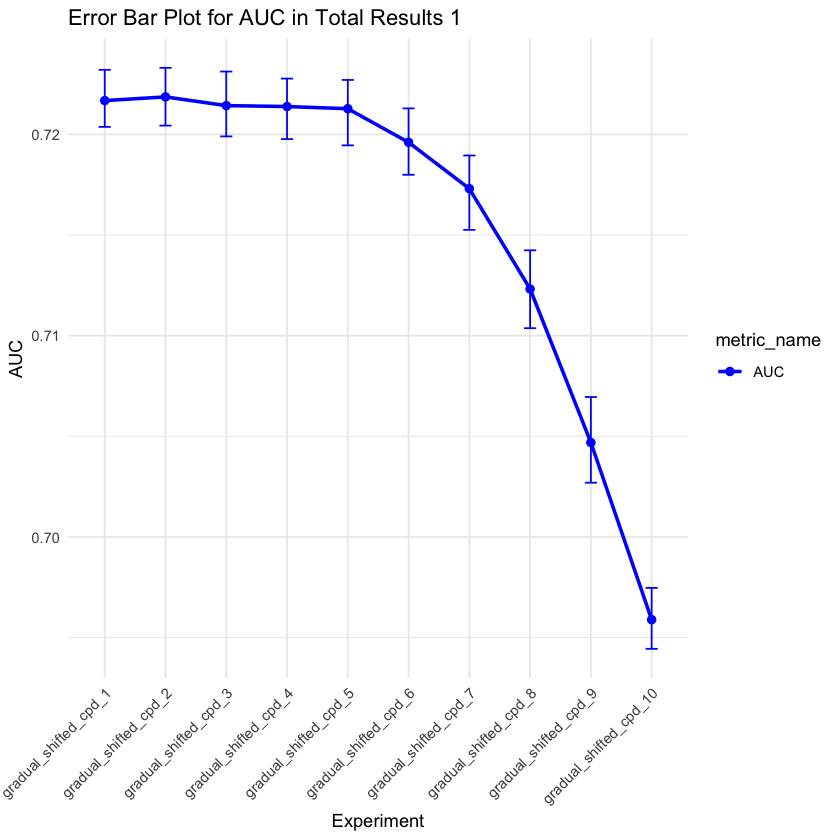

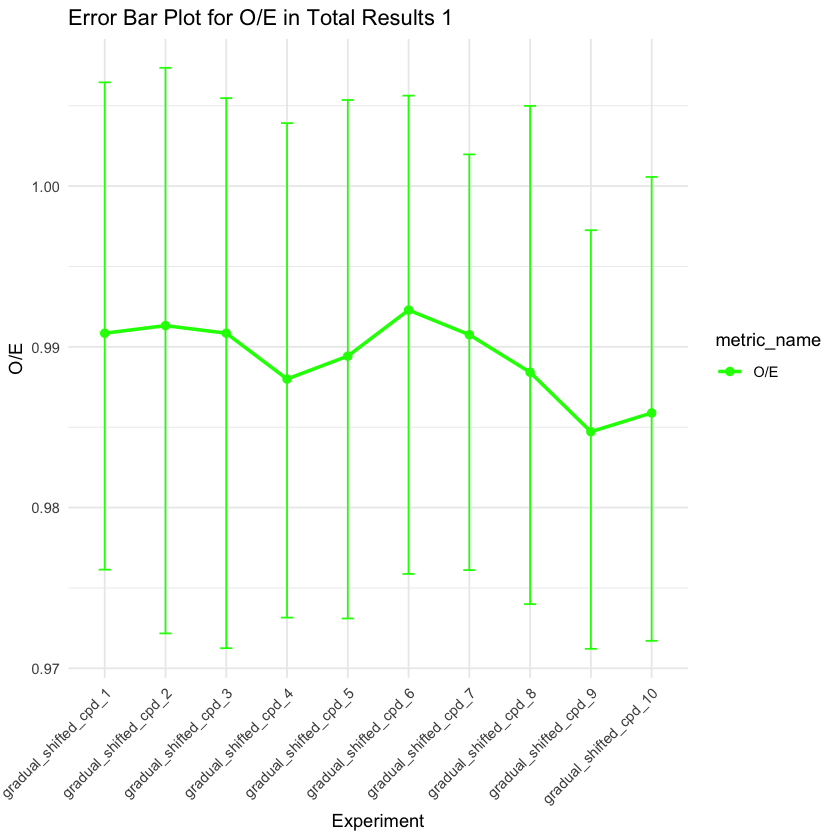

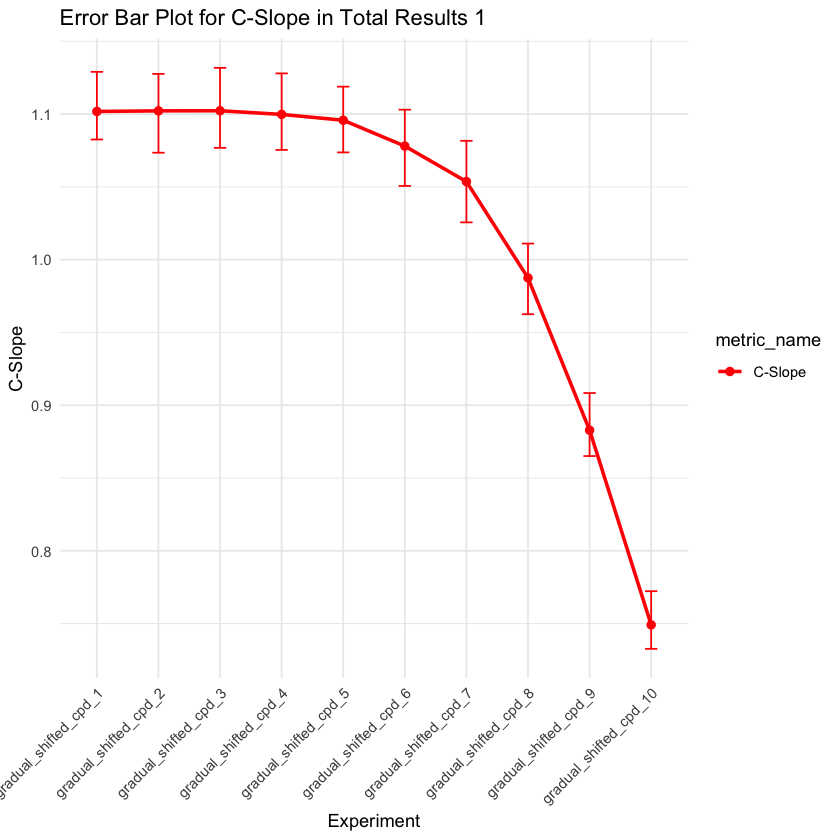

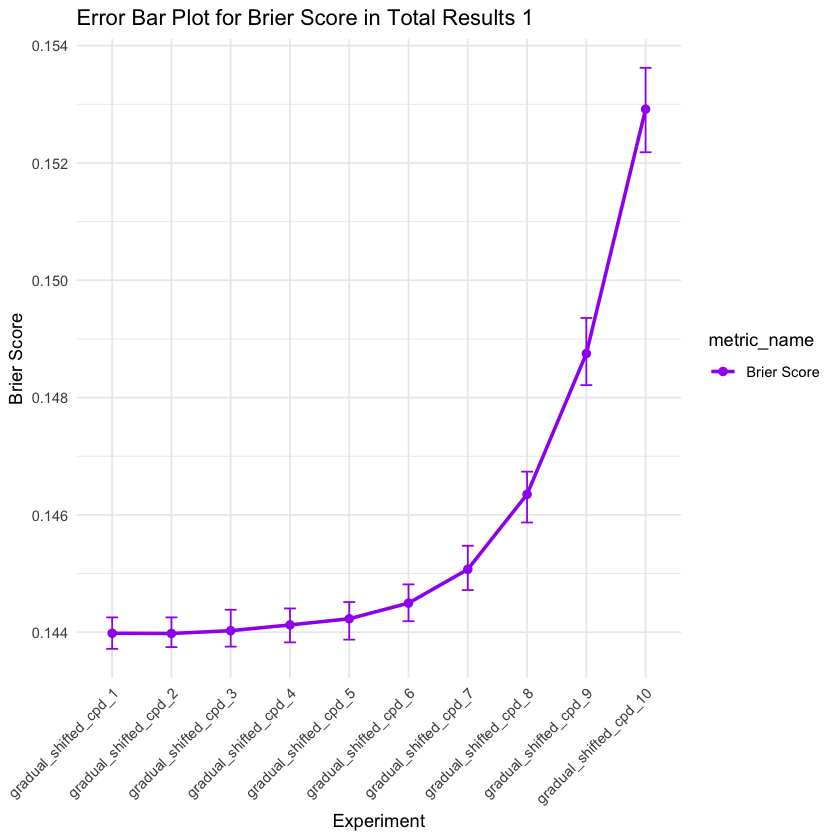

In [6]:
create_error_bar_plots(results_shifted_cpd_2_ml, "Total Results 1")